# Ciencia De Datos Aplicada (ITBA): Tercer Entregable

## Entrenamiento y validación de Modelos de Machine Learning

**Equipo:** Uriel Arias - 63504, Cristian Tepedino - 62830

**Nombre del proyecto**: Sistema de predicción de resultados de carreras de Fórmula 1

## 🧾 Carga de datos y preparación

Cargamos los dataset de la misma forma que en el entregable anterior. También se generan nuevas features que pueden aportar valor al modelo, y se separa el dataset en conjuntos de train y test.

### Importación y carga de librerias

In [1]:
!pip install kagglehub
!pip install fastf1

!pip install lightgbm shap joblib tqdm
!pip install optuna


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [2]:
from tqdm import tqdm
import kagglehub
import pandas as pd
import os
import fastf1
import warnings
import joblib
import optuna
from lightgbm import LGBMClassifier
from sklearn.preprocessing import LabelEncoder
from lightgbm.callback import early_stopping, log_evaluation
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.metrics import f1_score, accuracy_score, classification_report
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import GridSearchCV
import random

warnings.filterwarnings(
    "ignore",
    category=UserWarning,
    module="sklearn.impute._base"
)

cache_dir = './cache'
os.makedirs(cache_dir, exist_ok=True)
fastf1.Cache.enable_cache(cache_dir)


SEED = 42

# Seeds globales
np.random.seed(SEED)
random.seed(SEED)
optuna.logging.set_verbosity(optuna.logging.WARNING)


/home/cnt/PyCharmMiscProject/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Carga de datos

#### Dataset de resultados historicos de F1 (Kaggle)

In [3]:
path = kagglehub.dataset_download("rohanrao/formula-1-world-championship-1950-2020")
files_to_load = [
    "races.csv",
    "results.csv",
    "qualifying.csv",
    "drivers.csv",
    "constructors.csv",
    "circuits.csv",
    "driver_standings.csv",
    "constructor_standings.csv"
]

dfs = {}
for fname in files_to_load:
    fpath = os.path.join(path, fname)
    if os.path.exists(fpath):
        dfs[fname.replace(".csv", "")] = pd.read_csv(fpath, na_values="\\N")
    else:
        print(f"⚠️ No encontrado: {fname}")

races = dfs["races"]
results = dfs["results"]
qualifying = dfs["qualifying"]
drivers = dfs["drivers"]
constructors = dfs["constructors"]
circuits = dfs["circuits"]
driver_standings = dfs["driver_standings"]
constructor_standings = dfs["constructor_standings"]


results.head()

,resultId,raceId,driverId,constructorId,number,grid,position,positionText,positionOrder,points,laps,time,milliseconds,fastestLap,rank,fastestLapTime,fastestLapSpeed,statusId
0,1,18,1,1,22.0,1,1.0,1,1,10.0,58,1:34:50.616,5690616.0,39.0,2.0,1:27.452,218.300,1
1,2,18,2,2,3.0,5,2.0,2,2,8.0,58,+5.478,5696094.0,41.0,3.0,1:27.739,217.586,1
2,3,18,3,3,7.0,7,3.0,3,3,6.0,58,+8.163,5698779.0,41.0,5.0,1:28.090,216.719,1
3,4,18,4,4,5.0,11,4.0,4,4,5.0,58,+17.181,5707797.0,58.0,7.0,1:28.603,215.464,1
4,5,18,5,1,23.0,3,5.0,5,5,4.0,58,+18.014,5708630.0,43.0,1.0,1:27.418,218.385,1


#### Dataset de información climática de carreras (FastF1 API)

In [4]:
#Para evitar tener que volver a cargar todo desde la API (es lento, incluso con cache, y probablemente cause un rate limit), guardamos el dataset de clima en un archivo aparte

climate_csv = 'climate_data.csv'
if os.path.exists(climate_csv):
    climate_df = pd.read_csv(climate_csv)
else:
    climate_df = pd.DataFrame(columns=['raceId','year','name','AirTemp','TrackTemp','Humidity','Rainfall','WindSpeed'])

    modern_races = races[races['year']>=2018][['raceId','year','name']].drop_duplicates()

    for _, race in modern_races.iterrows():
        race_id = race['raceId']
        if race_id in climate_df['raceId'].values:
            continue

        try:
            session = fastf1.get_session(race['year'], race['name'], 'R')
            session.load()


            weather_avg = session.weather_data[['AirTemp','TrackTemp','Humidity','Rainfall','WindSpeed']].mean()

            new_row = {
                'raceId': race_id,
                'year': race['year'],
                'name': race['name'],
                'AirTemp': weather_avg['AirTemp'],
                'TrackTemp': weather_avg['TrackTemp'],
                'Humidity': weather_avg['Humidity'],
                'Rainfall': weather_avg['Rainfall'],
                'WindSpeed': weather_avg['WindSpeed']
            }
            climate_df = pd.concat([climate_df, pd.DataFrame([new_row])], ignore_index=True)

        except Exception as e:
            pass

climate_df.to_csv(climate_csv, index=False)

climate_df.head()


,raceId,year,name,AirTemp,TrackTemp,Humidity,Rainfall,WindSpeed
0,989,2018,Australian Grand Prix,24.077477,36.324324,30.915315,0.045045,3.691892
1,990,2018,Bahrain Grand Prix,27.982524,32.198058,47.363107,0.000000,0.958252
2,991,2018,Chinese Grand Prix,19.446429,37.019643,24.089286,0.017857,1.837500
3,992,2018,Azerbaijan Grand Prix,16.661404,25.251754,45.651754,0.000000,2.222807
4,993,2018,Spanish Grand Prix,16.050476,32.339048,52.286667,0.790476,1.952381


### Merge de datasets

In [5]:
results_df = results.copy()
races_df = races.copy()
qual_df = qualifying.copy()
driver_st = driver_standings.copy()
constructor_st = constructor_standings.copy()
climate = climate_df.copy()

races_df = races_df.sort_values(['year', 'round']).reset_index(drop=True)
race_order_map = {rid: i for i, rid in enumerate(races_df['raceId'].tolist())}

results_df['race_order'] = results_df['raceId'].map(race_order_map)
qual_df['race_order'] = qual_df['raceId'].map(race_order_map)
driver_st['race_order'] = driver_st['raceId'].map(race_order_map)
constructor_st['race_order'] = constructor_st['raceId'].map(race_order_map)
climate['race_order'] = climate['raceId'].map(race_order_map)

# ----- Base: una fila por piloto por carrera -----
df = results_df[
    ['raceId', 'driverId', 'constructorId', 'grid', 'positionOrder', 'statusId',
     'points', 'race_order']
].copy()

# ----- Merge datos de carrera -----
df = df.merge(
    races_df[['raceId', 'year', 'round', 'circuitId']],
    on='raceId', how='left'
)

# ----- Merge datos climaticos, y rellenamos con la media en las carreras para las que no tenemos datos -----
df = df.merge(
    climate[['raceId','AirTemp','TrackTemp','Humidity','Rainfall','WindSpeed']],
    on='raceId', how='left'
)

climate_cols = ['AirTemp','TrackTemp','Humidity','Rainfall','WindSpeed']

for col in climate_cols:
    df[col] = df[col].fillna(df[col].median())


# ----- Merge datos de clasificación -----
qual_small = qual_df[['raceId','driverId','position','q1','q2','q3']].copy()
qual_small = qual_small.rename(columns={'position':'qual_position'})

df = df.merge(qual_small, on=['raceId','driverId'], how='left')

# ----- Merge datos de standings de pilotos y constructores -----

driver_st = driver_st.sort_values(['driverId','race_order'])
driver_st = driver_st[['raceId','driverId','points','position','wins']]
driver_st = driver_st.rename(columns={
    'points':'driver_points_before',
    'position':'driver_champ_position_before',
    'wins':'driver_wins_before'
})

df = df.merge(driver_st, on=['raceId','driverId'], how='left')

constructor_st = constructor_st.sort_values(['constructorId','race_order'])
constructor_st = constructor_st[['raceId','constructorId','points','position','wins']]
constructor_st = constructor_st.rename(columns={
    'points':'constructor_points_before',
    'position':'constructor_champ_position_before',
    'wins':'constructor_wins_before'
})

df = df.merge(constructor_st, on=['raceId','constructorId'], how='left')


df.head()

,raceId,driverId,constructorId,grid,positionOrder,statusId,points,race_order,year,round,...,qual_position,q1,q2,q3,driver_points_before,driver_champ_position_before,driver_wins_before,constructor_points_before,constructor_champ_position_before,constructor_wins_before
0,18,1,1,1,1,1,10.0,785,2008,1,...,1.0,1:26.572,1:25.187,1:26.714,10.0,1.0,1.0,14.0,1.0,1.0
1,18,2,2,5,2,1,8.0,785,2008,1,...,5.0,1:25.960,1:25.518,1:27.236,8.0,2.0,0.0,8.0,3.0,0.0
2,18,3,3,7,3,1,6.0,785,2008,1,...,7.0,1:26.295,1:26.059,1:28.687,6.0,3.0,0.0,9.0,2.0,0.0
3,18,4,4,11,4,1,5.0,785,2008,1,...,12.0,1:26.907,1:26.188,NaN,5.0,4.0,0.0,5.0,4.0,0.0
4,18,5,1,3,5,1,4.0,785,2008,1,...,3.0,1:25.664,1:25.452,1:27.079,4.0,5.0,0.0,14.0,1.0,1.0


#### Agregamos features adicionales:

Creamos nuevas features que puedan aportar valor al modelo.

- Clasificación final (Ganador/Podio/No Podio) - Variable objetivo en el entrenamiento
- Gap de clasificación respecto al pole position
- ELO de piloto y constructor antes de la carrera
- Gap vs compañero de equipo (clasificación y carrera)

In [6]:
# Gap al pole basado en Q3 (mejor tiempo)
def time_to_ms(t):
    if pd.isna(t): return None
    m, s = t.split(':')
    return float(m)*60000 + float(s)*1000

qual_small['q_best_ms'] = qual_small.apply(
    lambda r: min(
        [time_to_ms(r['q1']), time_to_ms(r['q2']), time_to_ms(r['q3'])]
    ) if all(pd.notna([r['q1'],r['q2'],r['q3']])) else None,
    axis=1
)

pole_times = qual_small.groupby('raceId')['q_best_ms'].min().rename('pole_ms')
qual_small = qual_small.merge(pole_times, on='raceId', how='left')
qual_small['qualifying_gap'] = qual_small['q_best_ms'] - qual_small['pole_ms']

df = df.merge(qual_small[['raceId','driverId','qualifying_gap']], on=['raceId','driverId'], how='left')


In [7]:
def classify_position(pos):
    if pos == 1:
        return 'Winner'
    elif pos in [2, 3]:
        return 'Podium'
    else:
        return 'No_Podium'

df['position_category'] = df['positionOrder'].apply(classify_position)
df['is_winner'] = (df['positionOrder'] == 1).astype(int)

In [8]:
def elo_update_pair(elo_winner, elo_loser, k=20):
    expected = 1 / (1 + 10 ** ((elo_loser - elo_winner) / 400))
    new_w = elo_winner + k * (1 - expected)
    new_l = elo_loser + k * (0 - (1 - expected))
    return new_w, new_l

def compute_elos(df_results, k_driver=16, k_constructor=12, base_elo=1500.0):
    driver_elo = {}
    constructor_elo = {}
    elo_rows = []
    # races ordered by race_order
    races_ordered = df_results[['raceId','race_order']].drop_duplicates().sort_values('race_order')['raceId'].tolist()

    for rid in tqdm(races_ordered, desc="Calculando ELOs"):
        race = df_results[df_results['raceId']==rid].sort_values('positionOrder')
        race_list = race.to_dict('records')
        # store elo_before for each driver
        for rec in race_list:
            d = rec['driverId']
            c = rec['constructorId']
            if d not in driver_elo:
                driver_elo[d] = base_elo
            if c not in constructor_elo:
                constructor_elo[c] = base_elo
            elo_rows.append({
                'raceId': rid,
                'race_order': rec['race_order'],
                'driverId': d,
                'elo_driver_before': driver_elo[d],
                'elo_constructor_before': constructor_elo[c]
            })
        # update elos AFTER storing
        for i in range(len(race_list)):
            for j in range(i+1, len(race_list)):
                win = race_list[i]
                lose = race_list[j]
                # drivers
                new_w, new_l = elo_update_pair(driver_elo[win['driverId']], driver_elo[lose['driverId']], k=k_driver)
                driver_elo[win['driverId']] = new_w
                driver_elo[lose['driverId']] = new_l
                # constructors
                new_wc, new_lc = elo_update_pair(constructor_elo[win['constructorId']], constructor_elo[lose['constructorId']], k=k_constructor)
                constructor_elo[win['constructorId']] = new_wc
                constructor_elo[lose['constructorId']] = new_lc

    elo_df = pd.DataFrame(elo_rows)
    return elo_df

# Run ELO calculation (this may take some time, depending on dataset size)
elo_df = compute_elos(df[['raceId','race_order','driverId','constructorId','positionOrder']].drop_duplicates())
# Merge elo_before into df (only elo_before)
df = df.merge(elo_df[['raceId','driverId','elo_driver_before','elo_constructor_before']], on=['raceId','driverId'], how='left')

# Fill missing elos with base value
df['elo_driver_before'] = df['elo_driver_before'].fillna(1500.0)
df['elo_constructor_before'] = df['elo_constructor_before'].fillna(1500.0)

df.head()

Calculando ELOs: 100%|██████████| 1125/1125 [00:00<00:00, 1282.75it/s]


,raceId,driverId,constructorId,grid,positionOrder,statusId,points,race_order,year,round,...,driver_champ_position_before,driver_wins_before,constructor_points_before,constructor_champ_position_before,constructor_wins_before,qualifying_gap,position_category,is_winner,elo_driver_before,elo_constructor_before
0,18,1,1,1,1,1,10.0,785,2008,1,...,1.0,1.0,14.0,1.0,1.0,0.0,Winner,1,1848.076624,1111.516715
1,18,2,2,5,2,1,8.0,785,2008,1,...,2.0,0.0,8.0,3.0,0.0,331.0,Podium,0,1842.868366,1061.276436
2,18,3,3,7,3,1,6.0,785,2008,1,...,3.0,0.0,9.0,2.0,0.0,872.0,Podium,0,1707.096146,917.885160
3,18,4,4,11,4,1,5.0,785,2008,1,...,4.0,0.0,5.0,4.0,0.0,NaN,No_Podium,0,1944.563006,812.684403
4,18,5,1,3,5,1,4.0,785,2008,1,...,5.0,0.0,14.0,1.0,1.0,265.0,No_Podium,0,1705.401687,1111.516715


In [9]:
if 'qual_position' in df.columns:
    # get qual positions per race and constructor
    qual = qual_df.copy()
    qual = qual[['raceId','driverId','constructorId','position']].rename(columns={'position':'qual_position'})
    # merge qual into qual to get teammate pair
    qual_pairs = qual.merge(qual, on=['raceId','constructorId'], suffixes=('_a','_b'))
    qual_pairs = qual_pairs[qual_pairs['driverId_a'] != qual_pairs['driverId_b']]
    qual_pairs['qual_gap_vs_teammate'] = qual_pairs['qual_position_a'] - qual_pairs['qual_position_b']
    # average (should be unique per pair direction)
    qual_gap = qual_pairs.groupby(['raceId','driverId_a'])['qual_gap_vs_teammate'].mean().reset_index().rename(columns={'driverId_a':'driverId'})
    df = df.merge(qual_gap, on=['raceId','driverId'], how='left')
else:
    df['qual_gap_vs_teammate'] = np.nan

race_pairs = results.merge(results, on=['raceId','constructorId'], suffixes=('_a','_b'))
race_pairs = race_pairs[race_pairs['driverId_a'] != race_pairs['driverId_b']]
race_pairs['race_gap_vs_teammate'] = race_pairs['positionOrder_a'] - race_pairs['positionOrder_b']
race_gap = race_pairs.groupby(['raceId','driverId_a'])['race_gap_vs_teammate'].mean().reset_index().rename(columns={'driverId_a':'driverId'})
df = df.merge(race_gap, on=['raceId','driverId'], how='left')

df.head()

,raceId,driverId,constructorId,grid,positionOrder,statusId,points,race_order,year,round,...,constructor_points_before,constructor_champ_position_before,constructor_wins_before,qualifying_gap,position_category,is_winner,elo_driver_before,elo_constructor_before,qual_gap_vs_teammate,race_gap_vs_teammate
0,18,1,1,1,1,1,10.0,785,2008,1,...,14.0,1.0,1.0,0.0,Winner,1,1848.076624,1111.516715,-2.0,-4.0
1,18,2,2,5,2,1,8.0,785,2008,1,...,8.0,3.0,0.0,331.0,Podium,0,1842.868366,1061.276436,3.0,-7.0
2,18,3,3,7,3,1,6.0,785,2008,1,...,9.0,2.0,0.0,872.0,Podium,0,1707.096146,917.885160,-7.0,-3.0
3,18,4,4,11,4,1,5.0,785,2008,1,...,5.0,4.0,0.0,NaN,No_Podium,0,1944.563006,812.684403,-9.0,-8.0
4,18,5,1,3,5,1,4.0,785,2008,1,...,14.0,1.0,1.0,265.0,No_Podium,0,1705.401687,1111.516715,2.0,4.0


### Selección de features a utilizar (eliminamos columnas irrelevantes o que producen data leakage)

In [10]:
features = [
    'grid',
    'elo_driver_before','elo_constructor_before',
    'driver_points_before','driver_wins_before',
    'constructor_points_before','constructor_wins_before',
    'qual_position','qualifying_gap','qual_gap_vs_teammate',
    'race_gap_vs_teammate',
    'year','circuitId',
    'AirTemp','TrackTemp','Humidity','Rainfall','WindSpeed'
]
X = df[features]
y = df['position_category']

### Separación en conjuntos de train y test

Nuestro dataset de F1 es dependiente del tiempo, dado que cada carrera ocurre en un orden secuencial. Por lo tanto, creemos que el uso de muestreo aleatorio no sería apropiado para demostrar correctamente el rendimiento del modelo en datos futuros. En su lugar, dividimos los datos en conjuntos de entrenamiento y prueba basándonos en el año de la carrera. Utilizamos carreras hasta 2022 para el conjunto de entrenamiento y carreras de 2023 en adelante para el conjunto de prueba.
En otras palabras, sufririamos de data leakage, ya que el modelo estaria viendo el futuro para predecir el pasado. La accuracy en el conjunto de prueba sería artificialmente alta, y no reflejaria el rendimiento real del modelo en datos futuros.

In [15]:
train = df['year'] <= 2022
test = df['year'] > 2022

X_train = X[train]
y_train = y[train]
X_test = X[test]
y_test = y[test]



26034       Winner
26035       Podium
26036       Podium
26037    No_Podium
26038    No_Podium
Name: position_category, dtype: object


,grid,elo_driver_before,elo_constructor_before,driver_points_before,driver_wins_before,constructor_points_before,constructor_wins_before,qual_position,qualifying_gap,qual_gap_vs_teammate,race_gap_vs_teammate,year,circuitId,AirTemp,TrackTemp,Humidity,Rainfall,WindSpeed
26034,1,2203.081727,744.012201,25.0,1.0,43.0,1.0,1.0,0.0,-1.0,-1.0,2023,3,27.431677,31.011801,21.496894,0.0,0.68323
26035,2,2050.801858,744.012201,18.0,0.0,43.0,1.0,2.0,138.0,1.0,1.0,2023,3,27.431677,31.011801,21.496894,0.0,0.68323
26036,5,1566.167158,324.968304,15.0,0.0,23.0,0.0,5.0,628.0,-3.0,-3.0,2023,3,27.431677,31.011801,21.496894,0.0,0.68323
26037,4,1869.265062,611.428611,12.0,0.0,12.0,0.0,4.0,446.0,1.0,-15.0,2023,3,27.431677,31.011801,21.496894,0.0,0.68323
26038,7,1848.329026,523.633211,10.0,0.0,16.0,0.0,7.0,676.0,1.0,-2.0,2023,3,27.431677,31.011801,21.496894,0.0,0.68323


## 🏋️ Entrenamiento del Modelo

Para poder comparar el rendimiento de diferentes tecnicas, se van a entrenar modelos a partir de tres estrategias diferentes de Machine Learning para clasificación:

- SVM
- Random Forest
- Gradient Boosting con LightGBM

Luego, para cada modelo, se realizara una optimización de hiperparametros, con el objetivo de obtener el mejor rendimiento posible.

Luego, vamos a comparar sus resultados y quedarnos con aquel que nos de los mejores resultados

### 🏋️ Entrenamiento del Modelo con SVM

In [14]:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

svm_model = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("svc", SVC(
        kernel="rbf",
        C=3,
        gamma="scale",
        class_weight="balanced"
    ))
])

svm_model.fit(X_train, y_train_enc)
pred_svm = svm_model.predict(X_test)

print("📌 SVM Results:")
print(classification_report(y_test_enc, pred_svm, target_names=le.classes_))


📌 SVM Results:
              precision    recall  f1-score   support

   No_Podium       0.92      0.94      0.93       781
      Podium       0.45      0.48      0.46        92
      Winner       0.76      0.35      0.48        46

    accuracy                           0.87       919
   macro avg       0.71      0.59      0.62       919
weighted avg       0.86      0.87      0.86       919



#### Optimización de hiperparametros

Buscamos el mejor SVM cambiando el kernel, C y gamma (cuando aplica)

In [15]:
pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("svc", SVC(class_weight="balanced"))
])

param_grid = {
    "svc__kernel": ["linear", "rbf"],
    "svc__C": [0.1, 1, 3, 10],
    "svc__gamma": ["scale", "auto"]  # usada solo cuando kernel="rbf"
}

grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring="f1_macro",
    cv=3,
    n_jobs=-1,
    verbose=False
)


grid.fit(X_train, y_train_enc)

best_svm_params = grid.best_params_
best_svm_params = {
    k.split("__")[1]: v
    for k, v in best_svm_params.items()
    if k.startswith("svc__")
}

print("🔎 Mejor combinación encontrada:")
print(grid.best_params_)
print(f"Mejor F1 macro (val): {grid.best_score_:.4f}")


🔎 Mejor combinación encontrada:
{'svc__C': 3, 'svc__gamma': 'auto', 'svc__kernel': 'rbf'}
Mejor F1 macro (val): 0.6165


#### Modelo con los mejores hiperparámetros encontrados

In [16]:
best_svm = grid.best_estimator_

pred_svm = best_svm.predict(X_test)

print("\n📌 SVM Results (BEST MODEL):")
print(classification_report(y_test_enc, pred_svm, target_names=le.classes_))


📌 SVM Results (BEST MODEL):
              precision    recall  f1-score   support

   No_Podium       0.92      0.94      0.93       781
      Podium       0.45      0.48      0.46        92
      Winner       0.76      0.35      0.48        46

    accuracy                           0.87       919
   macro avg       0.71      0.59      0.62       919
weighted avg       0.86      0.87      0.86       919



### 🏋️ Entrenamiento del Modelo con Random Forest

In [17]:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

rf = RandomForestClassifier(
    n_estimators=500,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train_enc)
pred_rf = rf.predict(X_test)

print("📌 Random Forest Results:")
print(classification_report(y_test_enc, pred_rf, target_names=le.classes_))



📌 Random Forest Results:
              precision    recall  f1-score   support

   No_Podium       0.93      0.98      0.95       781
      Podium       0.57      0.38      0.46        92
      Winner       0.81      0.65      0.72        46

    accuracy                           0.90       919
   macro avg       0.77      0.67      0.71       919
weighted avg       0.89      0.90      0.89       919



#### Optimización de hiperparametros

Buscamos el mejor modelo de Random Forest, variando la cantidad de arboles, profundidad, minimo de muestras por split y leaf, maximo de features y si usamos bootstrap o no.

In [18]:
def temporal_cv_splits(df, n_splits=4):
    unique_orders = sorted(df['race_order'].unique())
    fold_sizes = np.linspace(0, len(unique_orders), n_splits + 1, dtype=int)

    splits = []
    for i in range(n_splits):
        train_orders = unique_orders[:fold_sizes[i+1]]
        valid_orders = unique_orders[fold_sizes[i+1]:fold_sizes[i+2]] if i+2 <= n_splits else []
        if not valid_orders:
            continue
        train_idx = df['race_order'].isin(train_orders)
        valid_idx = df['race_order'].isin(valid_orders)
        splits.append((train_idx, valid_idx))
    return splits


df_train = df[df['year'] <= 2022].copy()

def objective_rf(trial):

    # hiperparámetros a optimizar
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 300, 1500),
        "max_depth": trial.suggest_int("max_depth", 4, 40),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 15),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2", 0.3, 0.5, 0.7, None]),
        "bootstrap": trial.suggest_categorical("bootstrap", [True, False]),
        "class_weight": "balanced",
        "n_jobs": -1,
        "random_state": SEED,
        "bagging_seed": SEED,
        "feature_fraction_seed": SEED,
    }

    f1_scores = []
    splits = temporal_cv_splits(df_train)

    for train_idx, valid_idx in splits:
        X_tr = df_train.loc[train_idx, features]
        X_va = df_train.loc[valid_idx, features]
        y_tr = le.transform(df_train.loc[train_idx, "position_category"])
        y_va = le.transform(df_train.loc[valid_idx, "position_category"])

        pipe = Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("rf", RandomForestClassifier(**params, verbose=False))
        ])

        pipe.fit(X_tr, y_tr)
        preds = pipe.predict(X_va)

        f1_macro = f1_score(y_va, preds, average='macro')
        f1_scores.append(f1_macro)

    return np.mean(f1_scores)

study_rf = optuna.create_study(
    direction="maximize",
    study_name="rf_multiclass_temporal"
)

study_rf.optimize(objective_rf, n_trials=100, show_progress_bar=True)

print(study_rf.best_params)
print("Mejor F1 macro temporal:", study_rf.best_value)



[I 2025-11-23 15:05:50,375] A new study created in memory with name: rf_multiclass_temporal
Best trial: 0. Best value: 0.709957:   1%|          | 1/100 [00:04<07:53,  4.78s/it]

[I 2025-11-23 15:05:55,153] Trial 0 finished with value: 0.7099566515727306 and parameters: {'n_estimators': 647, 'max_depth': 28, 'min_samples_split': 6, 'min_samples_leaf': 12, 'max_features': 0.5, 'bootstrap': False}. Best is trial 0 with value: 0.7099566515727306.


Best trial: 1. Best value: 0.734626:   2%|▏         | 2/100 [00:12<10:38,  6.51s/it]

[I 2025-11-23 15:06:02,876] Trial 1 finished with value: 0.7346263966673678 and parameters: {'n_estimators': 1262, 'max_depth': 19, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_features': 0.5, 'bootstrap': True}. Best is trial 1 with value: 0.7346263966673678.


Best trial: 1. Best value: 0.734626:   3%|▎         | 3/100 [00:18<10:28,  6.48s/it]

[I 2025-11-23 15:06:09,328] Trial 2 finished with value: 0.7193605229292245 and parameters: {'n_estimators': 1390, 'max_depth': 27, 'min_samples_split': 14, 'min_samples_leaf': 7, 'max_features': 'log2', 'bootstrap': True}. Best is trial 1 with value: 0.7346263966673678.


Best trial: 1. Best value: 0.734626:   4%|▍         | 4/100 [00:24<09:28,  5.93s/it]

[I 2025-11-23 15:06:14,399] Trial 3 finished with value: 0.7189713536451219 and parameters: {'n_estimators': 602, 'max_depth': 35, 'min_samples_split': 16, 'min_samples_leaf': 10, 'max_features': None, 'bootstrap': True}. Best is trial 1 with value: 0.7346263966673678.


Best trial: 1. Best value: 0.734626:   5%|▌         | 5/100 [00:31<10:18,  6.51s/it]

[I 2025-11-23 15:06:21,958] Trial 4 finished with value: 0.7108125739227603 and parameters: {'n_estimators': 1334, 'max_depth': 29, 'min_samples_split': 10, 'min_samples_leaf': 15, 'max_features': 0.5, 'bootstrap': True}. Best is trial 1 with value: 0.7346263966673678.


Best trial: 1. Best value: 0.734626:   6%|▌         | 6/100 [00:37<09:39,  6.17s/it]

[I 2025-11-23 15:06:27,445] Trial 5 finished with value: 0.6809678117838388 and parameters: {'n_estimators': 439, 'max_depth': 40, 'min_samples_split': 6, 'min_samples_leaf': 7, 'max_features': None, 'bootstrap': False}. Best is trial 1 with value: 0.7346263966673678.


Best trial: 1. Best value: 0.734626:   7%|▋         | 7/100 [00:39<07:36,  4.91s/it]

[I 2025-11-23 15:06:29,775] Trial 6 finished with value: 0.715506053573472 and parameters: {'n_estimators': 390, 'max_depth': 22, 'min_samples_split': 13, 'min_samples_leaf': 12, 'max_features': 0.5, 'bootstrap': True}. Best is trial 1 with value: 0.7346263966673678.


Best trial: 1. Best value: 0.734626:   8%|▊         | 8/100 [00:45<07:56,  5.18s/it]

[I 2025-11-23 15:06:35,515] Trial 7 finished with value: 0.7225459619614877 and parameters: {'n_estimators': 1100, 'max_depth': 37, 'min_samples_split': 4, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 1 with value: 0.7346263966673678.


Best trial: 1. Best value: 0.734626:   9%|▉         | 9/100 [00:47<06:17,  4.15s/it]

[I 2025-11-23 15:06:37,398] Trial 8 finished with value: 0.7133667472219489 and parameters: {'n_estimators': 301, 'max_depth': 32, 'min_samples_split': 11, 'min_samples_leaf': 8, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 1 with value: 0.7346263966673678.


Best trial: 1. Best value: 0.734626:  10%|█         | 10/100 [00:51<06:24,  4.27s/it]

[I 2025-11-23 15:06:41,956] Trial 9 finished with value: 0.7206631354987388 and parameters: {'n_estimators': 692, 'max_depth': 13, 'min_samples_split': 15, 'min_samples_leaf': 8, 'max_features': 0.5, 'bootstrap': True}. Best is trial 1 with value: 0.7346263966673678.


Best trial: 1. Best value: 0.734626:  11%|█         | 11/100 [00:57<07:18,  4.92s/it]

[I 2025-11-23 15:06:48,355] Trial 10 finished with value: 0.6452660136584015 and parameters: {'n_estimators': 1047, 'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.7, 'bootstrap': True}. Best is trial 1 with value: 0.7346263966673678.


Best trial: 1. Best value: 0.734626:  12%|█▏        | 12/100 [01:04<07:47,  5.31s/it]

[I 2025-11-23 15:06:54,552] Trial 11 finished with value: 0.7189148070944013 and parameters: {'n_estimators': 1127, 'max_depth': 16, 'min_samples_split': 20, 'min_samples_leaf': 3, 'max_features': 0.3, 'bootstrap': False}. Best is trial 1 with value: 0.7346263966673678.


Best trial: 1. Best value: 0.734626:  13%|█▎        | 13/100 [01:10<08:03,  5.55s/it]

[I 2025-11-23 15:07:00,665] Trial 12 finished with value: 0.7287548470699342 and parameters: {'n_estimators': 1171, 'max_depth': 20, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 1 with value: 0.7346263966673678.


Best trial: 1. Best value: 0.734626:  14%|█▍        | 14/100 [01:18<08:54,  6.22s/it]

[I 2025-11-23 15:07:08,420] Trial 13 finished with value: 0.7302689315902615 and parameters: {'n_estimators': 1496, 'max_depth': 18, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 1 with value: 0.7346263966673678.


Best trial: 1. Best value: 0.734626:  15%|█▌        | 15/100 [01:32<12:20,  8.71s/it]

[I 2025-11-23 15:07:22,890] Trial 14 finished with value: 0.7030555140817448 and parameters: {'n_estimators': 1405, 'max_depth': 11, 'min_samples_split': 9, 'min_samples_leaf': 1, 'max_features': 0.7, 'bootstrap': False}. Best is trial 1 with value: 0.7346263966673678.


Best trial: 15. Best value: 0.734728:  16%|█▌        | 16/100 [01:38<11:08,  7.95s/it]

[I 2025-11-23 15:07:29,096] Trial 15 finished with value: 0.7347284835822226 and parameters: {'n_estimators': 1256, 'max_depth': 19, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_features': 'log2', 'bootstrap': True}. Best is trial 15 with value: 0.7347284835822226.


Best trial: 15. Best value: 0.734728:  17%|█▋        | 17/100 [01:42<09:21,  6.77s/it]

[I 2025-11-23 15:07:33,113] Trial 16 finished with value: 0.726796738968916 and parameters: {'n_estimators': 801, 'max_depth': 24, 'min_samples_split': 8, 'min_samples_leaf': 5, 'max_features': 'log2', 'bootstrap': True}. Best is trial 15 with value: 0.7347284835822226.


Best trial: 15. Best value: 0.734728:  18%|█▊        | 18/100 [01:46<08:08,  5.95s/it]

[I 2025-11-23 15:07:37,166] Trial 17 finished with value: 0.6153681274940935 and parameters: {'n_estimators': 942, 'max_depth': 5, 'min_samples_split': 12, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': True}. Best is trial 15 with value: 0.7347284835822226.


Best trial: 15. Best value: 0.734728:  19%|█▉        | 19/100 [01:52<08:02,  5.96s/it]

[I 2025-11-23 15:07:43,139] Trial 18 finished with value: 0.7083211516544287 and parameters: {'n_estimators': 1211, 'max_depth': 10, 'min_samples_split': 17, 'min_samples_leaf': 5, 'max_features': 0.3, 'bootstrap': True}. Best is trial 15 with value: 0.7347284835822226.


Best trial: 15. Best value: 0.734728:  20%|██        | 20/100 [01:57<07:22,  5.53s/it]

[I 2025-11-23 15:07:47,653] Trial 19 finished with value: 0.7302239413139148 and parameters: {'n_estimators': 925, 'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 'log2', 'bootstrap': True}. Best is trial 15 with value: 0.7347284835822226.


Best trial: 15. Best value: 0.734728:  21%|██        | 21/100 [02:04<08:07,  6.18s/it]

[I 2025-11-23 15:07:55,349] Trial 20 finished with value: 0.7267445522618341 and parameters: {'n_estimators': 1249, 'max_depth': 24, 'min_samples_split': 7, 'min_samples_leaf': 6, 'max_features': 0.5, 'bootstrap': True}. Best is trial 15 with value: 0.7347284835822226.


Best trial: 15. Best value: 0.734728:  22%|██▏       | 22/100 [02:12<08:40,  6.67s/it]

[I 2025-11-23 15:08:03,161] Trial 21 finished with value: 0.7275486997175887 and parameters: {'n_estimators': 1495, 'max_depth': 18, 'min_samples_split': 9, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 15 with value: 0.7347284835822226.


Best trial: 15. Best value: 0.734728:  23%|██▎       | 23/100 [02:19<08:35,  6.69s/it]

[I 2025-11-23 15:08:09,909] Trial 22 finished with value: 0.7315662404482718 and parameters: {'n_estimators': 1299, 'max_depth': 18, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 15 with value: 0.7347284835822226.


Best trial: 15. Best value: 0.734728:  24%|██▍       | 24/100 [02:25<08:22,  6.62s/it]

[I 2025-11-23 15:08:16,353] Trial 23 finished with value: 0.7259357947702636 and parameters: {'n_estimators': 1304, 'max_depth': 21, 'min_samples_split': 11, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': True}. Best is trial 15 with value: 0.7347284835822226.


Best trial: 15. Best value: 0.734728:  25%|██▌       | 25/100 [02:33<08:34,  6.86s/it]

[I 2025-11-23 15:08:23,767] Trial 24 finished with value: 0.721561123152607 and parameters: {'n_estimators': 988, 'max_depth': 16, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 0.7, 'bootstrap': True}. Best is trial 15 with value: 0.7347284835822226.


Best trial: 15. Best value: 0.734728:  26%|██▌       | 26/100 [02:37<07:28,  6.06s/it]

[I 2025-11-23 15:08:27,960] Trial 25 finished with value: 0.7326564653589972 and parameters: {'n_estimators': 803, 'max_depth': 24, 'min_samples_split': 7, 'min_samples_leaf': 4, 'max_features': 0.3, 'bootstrap': True}. Best is trial 15 with value: 0.7347284835822226.


Best trial: 15. Best value: 0.734728:  27%|██▋       | 27/100 [02:41<06:40,  5.49s/it]

[I 2025-11-23 15:08:32,117] Trial 26 finished with value: 0.7331866177603762 and parameters: {'n_estimators': 792, 'max_depth': 25, 'min_samples_split': 6, 'min_samples_leaf': 4, 'max_features': 0.3, 'bootstrap': True}. Best is trial 15 with value: 0.7347284835822226.


Best trial: 15. Best value: 0.734728:  28%|██▊       | 28/100 [02:48<07:08,  5.95s/it]

[I 2025-11-23 15:08:39,138] Trial 27 finished with value: 0.7239488898770264 and parameters: {'n_estimators': 775, 'max_depth': 26, 'min_samples_split': 4, 'min_samples_leaf': 6, 'max_features': None, 'bootstrap': True}. Best is trial 15 with value: 0.7347284835822226.


Best trial: 15. Best value: 0.734728:  29%|██▉       | 29/100 [02:54<06:57,  5.88s/it]

[I 2025-11-23 15:08:44,857] Trial 28 finished with value: 0.7314512257636648 and parameters: {'n_estimators': 1027, 'max_depth': 30, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 0.3, 'bootstrap': True}. Best is trial 15 with value: 0.7347284835822226.


Best trial: 15. Best value: 0.734728:  30%|███       | 30/100 [02:57<05:50,  5.01s/it]

[I 2025-11-23 15:08:47,837] Trial 29 finished with value: 0.7131922614816449 and parameters: {'n_estimators': 580, 'max_depth': 32, 'min_samples_split': 6, 'min_samples_leaf': 11, 'max_features': 0.3, 'bootstrap': True}. Best is trial 15 with value: 0.7347284835822226.


Best trial: 15. Best value: 0.734728:  31%|███       | 31/100 [03:02<05:50,  5.08s/it]

[I 2025-11-23 15:08:53,076] Trial 30 finished with value: 0.7216783836125709 and parameters: {'n_estimators': 870, 'max_depth': 21, 'min_samples_split': 6, 'min_samples_leaf': 9, 'max_features': 0.5, 'bootstrap': True}. Best is trial 15 with value: 0.7347284835822226.


Best trial: 15. Best value: 0.734728:  32%|███▏      | 32/100 [03:06<05:21,  4.73s/it]

[I 2025-11-23 15:08:56,985] Trial 31 finished with value: 0.734124001994827 and parameters: {'n_estimators': 719, 'max_depth': 25, 'min_samples_split': 7, 'min_samples_leaf': 4, 'max_features': 0.3, 'bootstrap': True}. Best is trial 15 with value: 0.7347284835822226.


Best trial: 15. Best value: 0.734728:  33%|███▎      | 33/100 [03:10<05:06,  4.58s/it]

[I 2025-11-23 15:09:01,214] Trial 32 finished with value: 0.7245061924454653 and parameters: {'n_estimators': 708, 'max_depth': 26, 'min_samples_split': 5, 'min_samples_leaf': 6, 'max_features': 0.3, 'bootstrap': True}. Best is trial 15 with value: 0.7347284835822226.


Best trial: 15. Best value: 0.734728:  34%|███▍      | 34/100 [03:13<04:32,  4.13s/it]

[I 2025-11-23 15:09:04,290] Trial 33 finished with value: 0.7299381418978514 and parameters: {'n_estimators': 564, 'max_depth': 23, 'min_samples_split': 9, 'min_samples_leaf': 4, 'max_features': 0.3, 'bootstrap': True}. Best is trial 15 with value: 0.7347284835822226.


Best trial: 15. Best value: 0.734728:  35%|███▌      | 35/100 [03:18<04:33,  4.21s/it]

[I 2025-11-23 15:09:08,681] Trial 34 finished with value: 0.728152040770953 and parameters: {'n_estimators': 857, 'max_depth': 28, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': True}. Best is trial 15 with value: 0.7347284835822226.


Best trial: 15. Best value: 0.734728:  36%|███▌      | 36/100 [03:21<04:11,  3.93s/it]

[I 2025-11-23 15:09:11,955] Trial 35 finished with value: 0.7058402868517413 and parameters: {'n_estimators': 652, 'max_depth': 19, 'min_samples_split': 10, 'min_samples_leaf': 14, 'max_features': 0.3, 'bootstrap': True}. Best is trial 15 with value: 0.7347284835822226.


Best trial: 15. Best value: 0.734728:  37%|███▋      | 37/100 [03:24<03:50,  3.66s/it]

[I 2025-11-23 15:09:14,985] Trial 36 finished with value: 0.7236314024804588 and parameters: {'n_estimators': 490, 'max_depth': 26, 'min_samples_split': 5, 'min_samples_leaf': 7, 'max_features': 0.5, 'bootstrap': True}. Best is trial 15 with value: 0.7347284835822226.


Best trial: 15. Best value: 0.734728:  38%|███▊      | 38/100 [03:31<04:42,  4.56s/it]

[I 2025-11-23 15:09:21,642] Trial 37 finished with value: 0.7266669326944063 and parameters: {'n_estimators': 739, 'max_depth': 16, 'min_samples_split': 13, 'min_samples_leaf': 5, 'max_features': None, 'bootstrap': True}. Best is trial 15 with value: 0.7347284835822226.


Best trial: 15. Best value: 0.734728:  39%|███▉      | 39/100 [03:38<05:24,  5.32s/it]

[I 2025-11-23 15:09:28,738] Trial 38 finished with value: 0.7339338826643206 and parameters: {'n_estimators': 1112, 'max_depth': 31, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': 0.5, 'bootstrap': True}. Best is trial 15 with value: 0.7347284835822226.


Best trial: 15. Best value: 0.734728:  40%|████      | 40/100 [03:47<06:25,  6.43s/it]

[I 2025-11-23 15:09:37,745] Trial 39 finished with value: 0.7319335844975816 and parameters: {'n_estimators': 1416, 'max_depth': 36, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': 0.5, 'bootstrap': True}. Best is trial 15 with value: 0.7347284835822226.


Best trial: 15. Best value: 0.734728:  41%|████      | 41/100 [03:54<06:31,  6.64s/it]

[I 2025-11-23 15:09:44,882] Trial 40 finished with value: 0.714448847607494 and parameters: {'n_estimators': 1099, 'max_depth': 39, 'min_samples_split': 12, 'min_samples_leaf': 1, 'max_features': 0.5, 'bootstrap': True}. Best is trial 15 with value: 0.7347284835822226.


Best trial: 15. Best value: 0.734728:  42%|████▏     | 42/100 [04:02<06:44,  6.98s/it]

[I 2025-11-23 15:09:52,642] Trial 41 finished with value: 0.732908201943797 and parameters: {'n_estimators': 1245, 'max_depth': 22, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_features': 0.5, 'bootstrap': True}. Best is trial 15 with value: 0.7347284835822226.


Best trial: 15. Best value: 0.734728:  43%|████▎     | 43/100 [04:11<07:09,  7.53s/it]

[I 2025-11-23 15:10:01,471] Trial 42 finished with value: 0.7277271321936324 and parameters: {'n_estimators': 1356, 'max_depth': 31, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': 0.5, 'bootstrap': True}. Best is trial 15 with value: 0.7347284835822226.


Best trial: 43. Best value: 0.735453:  44%|████▍     | 44/100 [04:17<06:39,  7.13s/it]

[I 2025-11-23 15:10:07,652] Trial 43 finished with value: 0.7354530699947351 and parameters: {'n_estimators': 1178, 'max_depth': 28, 'min_samples_split': 7, 'min_samples_leaf': 3, 'max_features': 0.3, 'bootstrap': True}. Best is trial 43 with value: 0.7354530699947351.


Best trial: 43. Best value: 0.735453:  45%|████▌     | 45/100 [04:22<06:08,  6.70s/it]

[I 2025-11-23 15:10:13,373] Trial 44 finished with value: 0.734246104126136 and parameters: {'n_estimators': 1158, 'max_depth': 34, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_features': 'log2', 'bootstrap': True}. Best is trial 43 with value: 0.7354530699947351.


Best trial: 43. Best value: 0.735453:  46%|████▌     | 46/100 [04:28<05:48,  6.45s/it]

[I 2025-11-23 15:10:19,213] Trial 45 finished with value: 0.7247074293588023 and parameters: {'n_estimators': 1166, 'max_depth': 33, 'min_samples_split': 8, 'min_samples_leaf': 5, 'max_features': 'log2', 'bootstrap': True}. Best is trial 43 with value: 0.7354530699947351.


Best trial: 43. Best value: 0.735453:  47%|████▋     | 47/100 [04:34<05:25,  6.14s/it]

[I 2025-11-23 15:10:24,644] Trial 46 finished with value: 0.7170411468762233 and parameters: {'n_estimators': 1053, 'max_depth': 34, 'min_samples_split': 9, 'min_samples_leaf': 7, 'max_features': 'log2', 'bootstrap': False}. Best is trial 43 with value: 0.7354530699947351.


Best trial: 43. Best value: 0.735453:  48%|████▊     | 48/100 [04:40<05:16,  6.08s/it]

[I 2025-11-23 15:10:30,595] Trial 47 finished with value: 0.7314273530266372 and parameters: {'n_estimators': 1182, 'max_depth': 38, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': True}. Best is trial 43 with value: 0.7354530699947351.


Best trial: 43. Best value: 0.735453:  49%|████▉     | 49/100 [04:46<05:15,  6.18s/it]

[I 2025-11-23 15:10:37,013] Trial 48 finished with value: 0.7271840880645878 and parameters: {'n_estimators': 1277, 'max_depth': 28, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': True}. Best is trial 43 with value: 0.7354530699947351.


Best trial: 43. Best value: 0.735453:  50%|█████     | 50/100 [05:07<08:42, 10.45s/it]

[I 2025-11-23 15:10:57,412] Trial 49 finished with value: 0.6523078494485862 and parameters: {'n_estimators': 1441, 'max_depth': 29, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_features': None, 'bootstrap': False}. Best is trial 43 with value: 0.7354530699947351.


Best trial: 43. Best value: 0.735453:  51%|█████     | 51/100 [05:17<08:34, 10.51s/it]

[I 2025-11-23 15:11:08,050] Trial 50 finished with value: 0.7273176579003109 and parameters: {'n_estimators': 1370, 'max_depth': 35, 'min_samples_split': 11, 'min_samples_leaf': 6, 'max_features': 0.7, 'bootstrap': True}. Best is trial 43 with value: 0.7354530699947351.


Best trial: 43. Best value: 0.735453:  52%|█████▏    | 52/100 [05:24<07:36,  9.50s/it]

[I 2025-11-23 15:11:15,210] Trial 51 finished with value: 0.7338033274262671 and parameters: {'n_estimators': 1121, 'max_depth': 30, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 0.5, 'bootstrap': True}. Best is trial 43 with value: 0.7354530699947351.


Best trial: 43. Best value: 0.735453:  53%|█████▎    | 53/100 [05:31<06:43,  8.58s/it]

[I 2025-11-23 15:11:21,627] Trial 52 finished with value: 0.735179821927597 and parameters: {'n_estimators': 1207, 'max_depth': 33, 'min_samples_split': 7, 'min_samples_leaf': 3, 'max_features': 0.3, 'bootstrap': True}. Best is trial 43 with value: 0.7354530699947351.


Best trial: 43. Best value: 0.735453:  54%|█████▍    | 54/100 [05:37<06:03,  7.90s/it]

[I 2025-11-23 15:11:27,938] Trial 53 finished with value: 0.7292752914126787 and parameters: {'n_estimators': 1223, 'max_depth': 33, 'min_samples_split': 7, 'min_samples_leaf': 5, 'max_features': 0.3, 'bootstrap': True}. Best is trial 43 with value: 0.7354530699947351.


Best trial: 43. Best value: 0.735453:  55%|█████▌    | 55/100 [05:44<05:46,  7.71s/it]

[I 2025-11-23 15:11:35,214] Trial 54 finished with value: 0.7314815586524847 and parameters: {'n_estimators': 1304, 'max_depth': 37, 'min_samples_split': 9, 'min_samples_leaf': 4, 'max_features': 0.3, 'bootstrap': True}. Best is trial 43 with value: 0.7354530699947351.


Best trial: 43. Best value: 0.735453:  56%|█████▌    | 56/100 [05:52<05:32,  7.56s/it]

[I 2025-11-23 15:11:42,427] Trial 55 finished with value: 0.7336875394695371 and parameters: {'n_estimators': 1190, 'max_depth': 20, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features': 0.3, 'bootstrap': True}. Best is trial 43 with value: 0.7354530699947351.


Best trial: 43. Best value: 0.735453:  57%|█████▋    | 57/100 [05:57<04:57,  6.91s/it]

[I 2025-11-23 15:11:47,815] Trial 56 finished with value: 0.7216149722458712 and parameters: {'n_estimators': 986, 'max_depth': 27, 'min_samples_split': 8, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': True}. Best is trial 43 with value: 0.7354530699947351.


Best trial: 43. Best value: 0.735453:  58%|█████▊    | 58/100 [06:03<04:43,  6.76s/it]

[I 2025-11-23 15:11:54,230] Trial 57 finished with value: 0.7145698282748834 and parameters: {'n_estimators': 1151, 'max_depth': 13, 'min_samples_split': 18, 'min_samples_leaf': 3, 'max_features': 0.3, 'bootstrap': False}. Best is trial 43 with value: 0.7354530699947351.


Best trial: 43. Best value: 0.735453:  59%|█████▉    | 59/100 [06:09<04:20,  6.35s/it]

[I 2025-11-23 15:11:59,623] Trial 58 finished with value: 0.7295782928736325 and parameters: {'n_estimators': 1075, 'max_depth': 40, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'log2', 'bootstrap': True}. Best is trial 43 with value: 0.7354530699947351.


Best trial: 43. Best value: 0.735453:  60%|██████    | 60/100 [06:15<04:18,  6.46s/it]

[I 2025-11-23 15:12:06,335] Trial 59 finished with value: 0.733169008588285 and parameters: {'n_estimators': 1261, 'max_depth': 23, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': 0.3, 'bootstrap': True}. Best is trial 43 with value: 0.7354530699947351.


Best trial: 43. Best value: 0.735453:  61%|██████    | 61/100 [06:24<04:36,  7.09s/it]

[I 2025-11-23 15:12:14,883] Trial 60 finished with value: 0.7060457463761404 and parameters: {'n_estimators': 1325, 'max_depth': 8, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 0.7, 'bootstrap': True}. Best is trial 43 with value: 0.7354530699947351.


Best trial: 43. Best value: 0.735453:  62%|██████▏   | 62/100 [06:30<04:19,  6.83s/it]

[I 2025-11-23 15:12:21,108] Trial 61 finished with value: 0.7321087535607775 and parameters: {'n_estimators': 987, 'max_depth': 32, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': 0.5, 'bootstrap': True}. Best is trial 43 with value: 0.7354530699947351.


Best trial: 43. Best value: 0.735453:  63%|██████▎   | 63/100 [06:36<04:03,  6.58s/it]

[I 2025-11-23 15:12:27,113] Trial 62 finished with value: 0.7326106665259978 and parameters: {'n_estimators': 1221, 'max_depth': 30, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 43 with value: 0.7354530699947351.


Best trial: 43. Best value: 0.735453:  64%|██████▍   | 64/100 [06:42<03:52,  6.44s/it]

[I 2025-11-23 15:12:33,240] Trial 63 finished with value: 0.7319370480845211 and parameters: {'n_estimators': 1136, 'max_depth': 31, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': 0.3, 'bootstrap': True}. Best is trial 43 with value: 0.7354530699947351.


Best trial: 43. Best value: 0.735453:  65%|██████▌   | 65/100 [06:49<03:44,  6.42s/it]

[I 2025-11-23 15:12:39,594] Trial 64 finished with value: 0.7333467527763905 and parameters: {'n_estimators': 1023, 'max_depth': 34, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_features': 0.5, 'bootstrap': True}. Best is trial 43 with value: 0.7354530699947351.


Best trial: 43. Best value: 0.735453:  66%|██████▌   | 66/100 [06:54<03:28,  6.13s/it]

[I 2025-11-23 15:12:45,057] Trial 65 finished with value: 0.7317808306826462 and parameters: {'n_estimators': 1104, 'max_depth': 29, 'min_samples_split': 9, 'min_samples_leaf': 4, 'max_features': 'log2', 'bootstrap': True}. Best is trial 43 with value: 0.7354530699947351.


Best trial: 43. Best value: 0.735453:  67%|██████▋   | 67/100 [06:56<02:40,  4.86s/it]

[I 2025-11-23 15:12:46,954] Trial 66 finished with value: 0.7137085584858065 and parameters: {'n_estimators': 337, 'max_depth': 27, 'min_samples_split': 7, 'min_samples_leaf': 1, 'max_features': 0.3, 'bootstrap': True}. Best is trial 43 with value: 0.7354530699947351.


Best trial: 43. Best value: 0.735453:  68%|██████▊   | 68/100 [07:06<03:28,  6.51s/it]

[I 2025-11-23 15:12:57,316] Trial 67 finished with value: 0.7205598274570869 and parameters: {'n_estimators': 1194, 'max_depth': 15, 'min_samples_split': 12, 'min_samples_leaf': 9, 'max_features': None, 'bootstrap': True}. Best is trial 43 with value: 0.7354530699947351.


Best trial: 43. Best value: 0.735453:  69%|██████▉   | 69/100 [07:17<03:58,  7.68s/it]

[I 2025-11-23 15:13:07,737] Trial 68 finished with value: 0.7266933596344322 and parameters: {'n_estimators': 1345, 'max_depth': 17, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': 0.5, 'bootstrap': False}. Best is trial 43 with value: 0.7354530699947351.


Best trial: 43. Best value: 0.735453:  70%|███████   | 70/100 [07:23<03:38,  7.29s/it]

[I 2025-11-23 15:13:14,098] Trial 69 finished with value: 0.7081179841677362 and parameters: {'n_estimators': 1276, 'max_depth': 25, 'min_samples_split': 5, 'min_samples_leaf': 13, 'max_features': 0.3, 'bootstrap': True}. Best is trial 43 with value: 0.7354530699947351.


Best trial: 43. Best value: 0.735453:  71%|███████   | 71/100 [07:28<03:07,  6.45s/it]

[I 2025-11-23 15:13:18,607] Trial 70 finished with value: 0.7288534686570759 and parameters: {'n_estimators': 930, 'max_depth': 19, 'min_samples_split': 15, 'min_samples_leaf': 3, 'max_features': 'log2', 'bootstrap': True}. Best is trial 43 with value: 0.7354530699947351.


Best trial: 43. Best value: 0.735453:  72%|███████▏  | 72/100 [07:35<03:05,  6.64s/it]

[I 2025-11-23 15:13:25,691] Trial 71 finished with value: 0.7328943573321375 and parameters: {'n_estimators': 1108, 'max_depth': 30, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 0.5, 'bootstrap': True}. Best is trial 43 with value: 0.7354530699947351.


Best trial: 43. Best value: 0.735453:  73%|███████▎  | 73/100 [07:42<03:05,  6.86s/it]

[I 2025-11-23 15:13:33,054] Trial 72 finished with value: 0.7286866421562989 and parameters: {'n_estimators': 1135, 'max_depth': 35, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': 0.5, 'bootstrap': True}. Best is trial 43 with value: 0.7354530699947351.


Best trial: 43. Best value: 0.735453:  74%|███████▍  | 74/100 [07:50<03:03,  7.08s/it]

[I 2025-11-23 15:13:40,634] Trial 73 finished with value: 0.7333867856394356 and parameters: {'n_estimators': 1228, 'max_depth': 31, 'min_samples_split': 7, 'min_samples_leaf': 5, 'max_features': 0.5, 'bootstrap': True}. Best is trial 43 with value: 0.7354530699947351.


Best trial: 43. Best value: 0.735453:  75%|███████▌  | 75/100 [07:57<02:55,  7.00s/it]

[I 2025-11-23 15:13:47,463] Trial 74 finished with value: 0.7319807639971038 and parameters: {'n_estimators': 1070, 'max_depth': 33, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_features': 0.5, 'bootstrap': True}. Best is trial 43 with value: 0.7354530699947351.


Best trial: 43. Best value: 0.735453:  76%|███████▌  | 76/100 [08:02<02:39,  6.64s/it]

[I 2025-11-23 15:13:53,259] Trial 75 finished with value: 0.7328694616043353 and parameters: {'n_estimators': 1161, 'max_depth': 28, 'min_samples_split': 8, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 43 with value: 0.7354530699947351.


Best trial: 43. Best value: 0.735453:  77%|███████▋  | 77/100 [08:11<02:45,  7.18s/it]

[I 2025-11-23 15:14:01,688] Trial 76 finished with value: 0.7233750877305442 and parameters: {'n_estimators': 1298, 'max_depth': 23, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 0.5, 'bootstrap': True}. Best is trial 43 with value: 0.7354530699947351.


Best trial: 43. Best value: 0.735453:  78%|███████▊  | 78/100 [08:15<02:15,  6.17s/it]

[I 2025-11-23 15:14:05,519] Trial 77 finished with value: 0.7280199261048171 and parameters: {'n_estimators': 513, 'max_depth': 29, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 0.7, 'bootstrap': True}. Best is trial 43 with value: 0.7354530699947351.


Best trial: 43. Best value: 0.735453:  79%|███████▉  | 79/100 [08:21<02:11,  6.27s/it]

[I 2025-11-23 15:14:12,023] Trial 78 finished with value: 0.733570769232108 and parameters: {'n_estimators': 1247, 'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 0.3, 'bootstrap': True}. Best is trial 43 with value: 0.7354530699947351.


Best trial: 43. Best value: 0.735453:  80%|████████  | 80/100 [08:26<01:54,  5.71s/it]

[I 2025-11-23 15:14:16,409] Trial 79 finished with value: 0.7136738277814917 and parameters: {'n_estimators': 847, 'max_depth': 35, 'min_samples_split': 7, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': True}. Best is trial 43 with value: 0.7354530699947351.


Best trial: 43. Best value: 0.735453:  81%|████████  | 81/100 [08:30<01:39,  5.25s/it]

[I 2025-11-23 15:14:20,601] Trial 80 finished with value: 0.7297690489714165 and parameters: {'n_estimators': 648, 'max_depth': 25, 'min_samples_split': 9, 'min_samples_leaf': 2, 'max_features': 0.5, 'bootstrap': True}. Best is trial 43 with value: 0.7354530699947351.


Best trial: 43. Best value: 0.735453:  82%|████████▏ | 82/100 [08:36<01:40,  5.58s/it]

[I 2025-11-23 15:14:26,937] Trial 81 finished with value: 0.73162346716513 and parameters: {'n_estimators': 1193, 'max_depth': 20, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': 0.3, 'bootstrap': True}. Best is trial 43 with value: 0.7354530699947351.


Best trial: 43. Best value: 0.735453:  83%|████████▎ | 83/100 [08:42<01:38,  5.78s/it]

[I 2025-11-23 15:14:33,175] Trial 82 finished with value: 0.7347438032754027 and parameters: {'n_estimators': 1202, 'max_depth': 17, 'min_samples_split': 7, 'min_samples_leaf': 3, 'max_features': 0.3, 'bootstrap': True}. Best is trial 43 with value: 0.7354530699947351.


Best trial: 43. Best value: 0.735453:  84%|████████▍ | 84/100 [08:48<01:30,  5.67s/it]

[I 2025-11-23 15:14:38,594] Trial 83 finished with value: 0.7338353873644695 and parameters: {'n_estimators': 1034, 'max_depth': 17, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_features': 0.3, 'bootstrap': True}. Best is trial 43 with value: 0.7354530699947351.


Best trial: 43. Best value: 0.735453:  85%|████████▌ | 85/100 [08:53<01:24,  5.64s/it]

[I 2025-11-23 15:14:44,163] Trial 84 finished with value: 0.7331113445353855 and parameters: {'n_estimators': 1073, 'max_depth': 17, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': 0.3, 'bootstrap': True}. Best is trial 43 with value: 0.7354530699947351.


Best trial: 43. Best value: 0.735453:  86%|████████▌ | 86/100 [08:59<01:19,  5.65s/it]

[I 2025-11-23 15:14:49,835] Trial 85 finished with value: 0.7256817470395659 and parameters: {'n_estimators': 1012, 'max_depth': 15, 'min_samples_split': 8, 'min_samples_leaf': 4, 'max_features': 0.3, 'bootstrap': False}. Best is trial 43 with value: 0.7354530699947351.


Best trial: 43. Best value: 0.735453:  87%|████████▋ | 87/100 [09:04<01:11,  5.48s/it]

[I 2025-11-23 15:14:54,919] Trial 86 finished with value: 0.7324611307676346 and parameters: {'n_estimators': 953, 'max_depth': 19, 'min_samples_split': 8, 'min_samples_leaf': 4, 'max_features': 0.3, 'bootstrap': True}. Best is trial 43 with value: 0.7354530699947351.


Best trial: 43. Best value: 0.735453:  88%|████████▊ | 88/100 [09:09<01:02,  5.25s/it]

[I 2025-11-23 15:14:59,628] Trial 87 finished with value: 0.7326043581059446 and parameters: {'n_estimators': 899, 'max_depth': 17, 'min_samples_split': 9, 'min_samples_leaf': 3, 'max_features': 0.3, 'bootstrap': True}. Best is trial 43 with value: 0.7354530699947351.


Best trial: 43. Best value: 0.735453:  89%|████████▉ | 89/100 [09:15<01:00,  5.49s/it]

[I 2025-11-23 15:15:05,667] Trial 88 finished with value: 0.7204297015256852 and parameters: {'n_estimators': 1215, 'max_depth': 11, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features': 0.3, 'bootstrap': True}. Best is trial 43 with value: 0.7354530699947351.


Best trial: 43. Best value: 0.735453:  90%|█████████ | 90/100 [09:22<00:59,  5.91s/it]

[I 2025-11-23 15:15:12,554] Trial 89 finished with value: 0.7025779162826233 and parameters: {'n_estimators': 1394, 'max_depth': 14, 'min_samples_split': 8, 'min_samples_leaf': 15, 'max_features': 0.3, 'bootstrap': True}. Best is trial 43 with value: 0.7354530699947351.


Best trial: 43. Best value: 0.735453:  91%|█████████ | 91/100 [09:34<01:09,  7.73s/it]

[I 2025-11-23 15:15:24,544] Trial 90 finished with value: 0.7261252857362611 and parameters: {'n_estimators': 1319, 'max_depth': 18, 'min_samples_split': 11, 'min_samples_leaf': 5, 'max_features': None, 'bootstrap': True}. Best is trial 43 with value: 0.7354530699947351.


Best trial: 91. Best value: 0.736193:  92%|█████████▏| 92/100 [09:40<00:58,  7.26s/it]

[I 2025-11-23 15:15:30,688] Trial 91 finished with value: 0.7361932479083652 and parameters: {'n_estimators': 1159, 'max_depth': 27, 'min_samples_split': 7, 'min_samples_leaf': 3, 'max_features': 0.3, 'bootstrap': True}. Best is trial 91 with value: 0.7361932479083652.


Best trial: 91. Best value: 0.736193:  93%|█████████▎| 93/100 [09:46<00:48,  6.91s/it]

[I 2025-11-23 15:15:36,797] Trial 92 finished with value: 0.733743808568808 and parameters: {'n_estimators': 1161, 'max_depth': 22, 'min_samples_split': 7, 'min_samples_leaf': 3, 'max_features': 0.3, 'bootstrap': True}. Best is trial 91 with value: 0.7361932479083652.


Best trial: 91. Best value: 0.736193:  94%|█████████▍| 94/100 [09:53<00:41,  6.86s/it]

[I 2025-11-23 15:15:43,552] Trial 93 finished with value: 0.7319631062871202 and parameters: {'n_estimators': 1277, 'max_depth': 21, 'min_samples_split': 9, 'min_samples_leaf': 3, 'max_features': 0.3, 'bootstrap': True}. Best is trial 91 with value: 0.7361932479083652.


Best trial: 91. Best value: 0.736193:  95%|█████████▌| 95/100 [09:58<00:32,  6.47s/it]

[I 2025-11-23 15:15:49,096] Trial 94 finished with value: 0.7330608038984493 and parameters: {'n_estimators': 1043, 'max_depth': 27, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features': 0.3, 'bootstrap': True}. Best is trial 91 with value: 0.7361932479083652.


Best trial: 91. Best value: 0.736193:  96%|█████████▌| 96/100 [10:04<00:25,  6.30s/it]

[I 2025-11-23 15:15:55,002] Trial 95 finished with value: 0.7328038291393861 and parameters: {'n_estimators': 1131, 'max_depth': 26, 'min_samples_split': 8, 'min_samples_leaf': 4, 'max_features': 'log2', 'bootstrap': True}. Best is trial 91 with value: 0.7361932479083652.


Best trial: 91. Best value: 0.736193:  97%|█████████▋| 97/100 [10:11<00:19,  6.37s/it]

[I 2025-11-23 15:16:01,546] Trial 96 finished with value: 0.7339746892024199 and parameters: {'n_estimators': 1187, 'max_depth': 24, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_features': 0.3, 'bootstrap': True}. Best is trial 91 with value: 0.7361932479083652.


Best trial: 91. Best value: 0.736193:  98%|█████████▊| 98/100 [10:17<00:12,  6.28s/it]

[I 2025-11-23 15:16:07,618] Trial 97 finished with value: 0.7144564111662843 and parameters: {'n_estimators': 1201, 'max_depth': 25, 'min_samples_split': 6, 'min_samples_leaf': 11, 'max_features': 0.3, 'bootstrap': True}. Best is trial 91 with value: 0.7361932479083652.


Best trial: 91. Best value: 0.736193:  99%|█████████▉| 99/100 [10:23<00:06,  6.33s/it]

[I 2025-11-23 15:16:14,045] Trial 98 finished with value: 0.7188649343412612 and parameters: {'n_estimators': 1239, 'max_depth': 24, 'min_samples_split': 7, 'min_samples_leaf': 6, 'max_features': 'log2', 'bootstrap': False}. Best is trial 91 with value: 0.7361932479083652.


Best trial: 91. Best value: 0.736193: 100%|██████████| 100/100 [10:29<00:00,  6.30s/it]

[I 2025-11-23 15:16:20,148] Trial 99 finished with value: 0.7218097667083283 and parameters: {'n_estimators': 1173, 'max_depth': 36, 'min_samples_split': 20, 'min_samples_leaf': 1, 'max_features': 0.3, 'bootstrap': True}. Best is trial 91 with value: 0.7361932479083652.
{'n_estimators': 1159, 'max_depth': 27, 'min_samples_split': 7, 'min_samples_leaf': 3, 'max_features': 0.3, 'bootstrap': True}
Mejor F1 macro temporal: 0.7361932479083652


#### Entrenamos el modelo con los mejores hiperparámetros encontrados

In [19]:
best_rf_params = study_rf.best_params
best_rf_params.update({
    "class_weight": "balanced",
    "random_state": 42,
    "n_jobs": -1
})

rf_final = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("rf", RandomForestClassifier(**best_rf_params, verbose=False))
])

rf_final.fit(X_train, y_train_enc)
pred_rf = rf_final.predict(X_test)

print("Random Forest Optimizado:")
print(classification_report(y_test_enc, pred_rf, target_names=le.classes_))


Random Forest Optimizado:
              precision    recall  f1-score   support

   No_Podium       0.96      0.94      0.95       781
      Podium       0.58      0.59      0.58        92
      Winner       0.68      0.85      0.76        46

    accuracy                           0.90       919
   macro avg       0.74      0.79      0.76       919
weighted avg       0.91      0.90      0.91       919



### 🏋️ Entrenamiento del Modelo con Gradient Boosting

In [20]:
model = LGBMClassifier(
    n_estimators=800,
    learning_rate=0.03,
    num_leaves=60,
    class_weight='balanced',
    subsample=0.8,
    colsample_bytree=0.8
)

model.fit(X_train, y_train)

pred = model.predict(X_test)
print(classification_report(y_test, pred))


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000724 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2258
[LightGBM] [Info] Number of data points in the train set: 26034, number of used features: 18
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
              precision    recall  f1-score   support

   No_Podium       0.97      0.93      0.95       781
      Podium       0.52      0.70      0.59        92
      Winner       0.76      0.67      0.71        46

    accuracy                           0.90       919
   macro avg       0.75      0.77      0.75       919
weighted avg       0.91      0.90      0.90       919



#### Optimización de hiperparámetros

Buscamos el mejor modelo de LightGBM variando los parametros de learning rate, cantidad de arboles y hojas, profundidad maxima, regularización y sampling

In [27]:
# LabelEncoder para LightGBM multiclass
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

# Para validación temporal, usamos race_order
df_train = df[df['year'] <= 2022].copy()

def temporal_cv_splits(df, n_splits=4):
    """Crea splits temporales usando race_order creciente."""
    unique_orders = sorted(df['race_order'].unique())
    fold_sizes = np.linspace(0, len(unique_orders), n_splits + 1, dtype=int)

    splits = []
    for i in range(n_splits):
        train_orders = unique_orders[:fold_sizes[i+1]]
        valid_orders = unique_orders[fold_sizes[i+1]:fold_sizes[i+2]] if i+2 <= n_splits else []
        if not valid_orders:
            continue
        train_idx = df['race_order'].isin(train_orders)
        valid_idx = df['race_order'].isin(valid_orders)
        splits.append((train_idx, valid_idx))
    return splits



# ============================================================
# OBJETIVO OPTUNA
# ============================================================

def objective(trial):

    # Espacio de búsqueda
    params = {
        "objective": "multiclass",
        "num_class": len(le.classes_),
        "metric": "multi_logloss",
        "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.05),
        "n_estimators": trial.suggest_int("n_estimators", 400, 1600),
        "num_leaves": trial.suggest_int("num_leaves", 20, 300),
        "max_depth": trial.suggest_int("max_depth", 3, 16),
        "min_child_samples": trial.suggest_int("min_child_samples", 3, 100),
        "subsample": trial.suggest_float("subsample", 0.4, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.3, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 2.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 2.0),
        "class_weight": "balanced",
        "random_state": SEED,
        "bagging_seed": SEED,
        "feature_fraction_seed": SEED,
    }

    # Para cada fold temporal
    f1_scores = []
    splits = temporal_cv_splits(df_train)

    for train_idx, valid_idx in splits:

        X_tr = df_train.loc[train_idx, features]
        y_tr = le.transform(df_train.loc[train_idx, 'position_category'])
        X_va = df_train.loc[valid_idx, features]
        y_va = le.transform(df_train.loc[valid_idx, 'position_category'])

        model = LGBMClassifier(**params, verbose=-1)
        model.fit(
            X_tr, y_tr,
            eval_set=[(X_va, y_va)],
            eval_metric="multi_logloss",
            callbacks=[
                early_stopping(stopping_rounds=50),
                log_evaluation(0)  # 0 = no logs, 1 = logs every iter
            ]
        )

        preds = model.predict(X_va)
        f1_macro = f1_score(y_va, preds, average='macro')
        f1_scores.append(f1_macro)

    return np.mean(f1_scores)

study = optuna.create_study(
    direction="maximize",
    study_name="f1_multiclass_f1_macro_temporal"
)

study.optimize(objective, n_trials=300, show_progress_bar=True)

print("Mejores hiperparámetros:")
print(study.best_params)

print("Mejor puntuación F1 macro:")
print(study.best_value)

[I 2025-11-23 15:49:06,908] A new study created in memory with name: f1_multiclass_f1_macro_temporal
  0%|          | 0/300 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[401]	valid_0's multi_logloss: 0.257355
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[516]	valid_0's multi_logloss: 0.276402
Training until validation scores don't improve for 50 rounds


Best trial: 0. Best value: 0.713764:   0%|          | 1/300 [00:02<10:30,  2.11s/it]

Early stopping, best iteration is:
[138]	valid_0's multi_logloss: 0.368285
[I 2025-11-23 15:49:09,017] Trial 0 finished with value: 0.7137635161102459 and parameters: {'learning_rate': 0.04417469108257674, 'n_estimators': 1297, 'num_leaves': 237, 'max_depth': 8, 'min_child_samples': 84, 'subsample': 0.6572639369543447, 'colsample_bytree': 0.8450157867717916, 'reg_alpha': 0.7820627748093214, 'reg_lambda': 1.0854789168192156}. Best is trial 0 with value: 0.7137635161102459.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[476]	valid_0's multi_logloss: 0.288465
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[702]	valid_0's multi_logloss: 0.309327
Training until validation scores don't improve for 50 rounds


Best trial: 0. Best value: 0.713764:   1%|          | 2/300 [00:04<10:01,  2.02s/it]

Early stopping, best iteration is:
[458]	valid_0's multi_logloss: 0.385178
[I 2025-11-23 15:49:10,971] Trial 1 finished with value: 0.7064820156528383 and parameters: {'learning_rate': 0.031760358217072515, 'n_estimators': 1213, 'num_leaves': 21, 'max_depth': 5, 'min_child_samples': 87, 'subsample': 0.6225357938464513, 'colsample_bytree': 0.3459136162079937, 'reg_alpha': 0.3250665402866595, 'reg_lambda': 0.3716444161623742}. Best is trial 0 with value: 0.7137635161102459.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[531]	valid_0's multi_logloss: 0.242173
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[491]	valid_0's multi_logloss: 0.275345
Training until validation scores don't improve for 50 rounds


Best trial: 0. Best value: 0.713764:   1%|          | 3/300 [00:06<10:43,  2.17s/it]

Early stopping, best iteration is:
[160]	valid_0's multi_logloss: 0.365461
[I 2025-11-23 15:49:13,312] Trial 2 finished with value: 0.7129226978105572 and parameters: {'learning_rate': 0.04372115925918826, 'n_estimators': 872, 'num_leaves': 273, 'max_depth': 7, 'min_child_samples': 53, 'subsample': 0.7608494038174545, 'colsample_bytree': 0.7780537390933535, 'reg_alpha': 1.1069507623753285, 'reg_lambda': 0.9558385911338356}. Best is trial 0 with value: 0.7137635161102459.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[507]	valid_0's multi_logloss: 0.316188
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[664]	valid_0's multi_logloss: 0.344977
Training until validation scores don't improve for 50 rounds


Best trial: 0. Best value: 0.713764:   1%|▏         | 4/300 [00:07<09:07,  1.85s/it]

Early stopping, best iteration is:
[417]	valid_0's multi_logloss: 0.436043
[I 2025-11-23 15:49:14,674] Trial 3 finished with value: 0.6934348977100392 and parameters: {'learning_rate': 0.03739668733874898, 'n_estimators': 724, 'num_leaves': 156, 'max_depth': 3, 'min_child_samples': 75, 'subsample': 0.8330476951236798, 'colsample_bytree': 0.41132499500678676, 'reg_alpha': 1.7550318622744723, 'reg_lambda': 1.3670622811543716}. Best is trial 0 with value: 0.7137635161102459.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[501]	valid_0's multi_logloss: 0.245123
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[376]	valid_0's multi_logloss: 0.270095
Training until validation scores don't improve for 50 rounds


Best trial: 0. Best value: 0.713764:   2%|▏         | 5/300 [00:10<09:52,  2.01s/it]

Early stopping, best iteration is:
[119]	valid_0's multi_logloss: 0.348689
[I 2025-11-23 15:49:16,969] Trial 4 finished with value: 0.7110424418486252 and parameters: {'learning_rate': 0.04679641810962265, 'n_estimators': 632, 'num_leaves': 49, 'max_depth': 11, 'min_child_samples': 64, 'subsample': 0.6800837481231325, 'colsample_bytree': 0.7251694094528311, 'reg_alpha': 1.2362227466843567, 'reg_lambda': 1.2325985590547652}. Best is trial 0 with value: 0.7137635161102459.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[990]	valid_0's multi_logloss: 0.243647
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[814]	valid_0's multi_logloss: 0.297032
Training until validation scores don't improve for 50 rounds


Best trial: 5. Best value: 0.716512:   2%|▏         | 6/300 [00:13<12:52,  2.63s/it]

Early stopping, best iteration is:
[302]	valid_0's multi_logloss: 0.336146
[I 2025-11-23 15:49:20,796] Trial 5 finished with value: 0.7165121311746642 and parameters: {'learning_rate': 0.031213261329320768, 'n_estimators': 1475, 'num_leaves': 213, 'max_depth': 7, 'min_child_samples': 47, 'subsample': 0.4652091497944858, 'colsample_bytree': 0.39663383948199743, 'reg_alpha': 1.240407529140152, 'reg_lambda': 1.4526306656674461}. Best is trial 5 with value: 0.7165121311746642.
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[523]	valid_0's multi_logloss: 0.234046
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[524]	valid_0's multi_logloss: 0.293407
Training until validation scores don't improve for 50 rounds


Best trial: 6. Best value: 0.717028:   2%|▏         | 7/300 [00:18<15:20,  3.14s/it]

Did not meet early stopping. Best iteration is:
[513]	valid_0's multi_logloss: 0.3121
[I 2025-11-23 15:49:24,991] Trial 6 finished with value: 0.7170283498966925 and parameters: {'learning_rate': 0.01948307038075736, 'n_estimators': 524, 'num_leaves': 42, 'max_depth': 15, 'min_child_samples': 7, 'subsample': 0.6766802977702255, 'colsample_bytree': 0.3679143396267989, 'reg_alpha': 0.998125798424514, 'reg_lambda': 0.07315825890776195}. Best is trial 6 with value: 0.7170283498966925.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[307]	valid_0's multi_logloss: 0.255795
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[380]	valid_0's multi_logloss: 0.263955
Training until validation scores don't improve for 50 rounds


Best trial: 7. Best value: 0.717809:   3%|▎         | 8/300 [00:20<14:18,  2.94s/it]

Early stopping, best iteration is:
[117]	valid_0's multi_logloss: 0.328412
[I 2025-11-23 15:49:27,506] Trial 7 finished with value: 0.7178094824280626 and parameters: {'learning_rate': 0.04194311169622157, 'n_estimators': 1492, 'num_leaves': 257, 'max_depth': 15, 'min_child_samples': 65, 'subsample': 0.8382289460305141, 'colsample_bytree': 0.6572419337529021, 'reg_alpha': 0.16874414096650137, 'reg_lambda': 1.419513312041051}. Best is trial 7 with value: 0.7178094824280626.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[854]	valid_0's multi_logloss: 0.333183
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1052]	valid_0's multi_logloss: 0.400488
Training until validation scores don't improve for 50 rounds


Best trial: 7. Best value: 0.717809:   3%|▎         | 9/300 [00:23<13:31,  2.79s/it]

Did not meet early stopping. Best iteration is:
[1052]	valid_0's multi_logloss: 0.485691
[I 2025-11-23 15:49:29,964] Trial 8 finished with value: 0.6624620593228929 and parameters: {'learning_rate': 0.006193344064699114, 'n_estimators': 1052, 'num_leaves': 60, 'max_depth': 3, 'min_child_samples': 34, 'subsample': 0.5950975944797053, 'colsample_bytree': 0.7091318827574606, 'reg_alpha': 0.39179956313701214, 'reg_lambda': 1.7765038176261587}. Best is trial 7 with value: 0.7178094824280626.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[380]	valid_0's multi_logloss: 0.242001
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[408]	valid_0's multi_logloss: 0.280887
Training until validation scores don't improve for 50 rounds


Best trial: 7. Best value: 0.717809:   3%|▎         | 10/300 [00:24<11:36,  2.40s/it]

Early stopping, best iteration is:
[135]	valid_0's multi_logloss: 0.377629
[I 2025-11-23 15:49:31,493] Trial 9 finished with value: 0.7142805183144761 and parameters: {'learning_rate': 0.039335697844746755, 'n_estimators': 1328, 'num_leaves': 292, 'max_depth': 6, 'min_child_samples': 34, 'subsample': 0.4660962694141756, 'colsample_bytree': 0.7519679085867534, 'reg_alpha': 0.503836467242502, 'reg_lambda': 0.3932254469630614}. Best is trial 7 with value: 0.7178094824280626.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[400]	valid_0's multi_logloss: 0.277102
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[774]	valid_0's multi_logloss: 0.270644
Training until validation scores don't improve for 50 rounds


Best trial: 7. Best value: 0.717809:   4%|▎         | 11/300 [00:28<13:22,  2.78s/it]

Early stopping, best iteration is:
[196]	valid_0's multi_logloss: 0.363745
[I 2025-11-23 15:49:35,127] Trial 10 finished with value: 0.7136969727209546 and parameters: {'learning_rate': 0.02066565851616169, 'n_estimators': 1569, 'num_leaves': 153, 'max_depth': 16, 'min_child_samples': 100, 'subsample': 0.994889991353922, 'colsample_bytree': 0.9933308786934968, 'reg_alpha': 0.043064230322655245, 'reg_lambda': 1.8740352888200271}. Best is trial 7 with value: 0.7178094824280626.
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[406]	valid_0's multi_logloss: 0.241499
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[406]	valid_0's multi_logloss: 0.283337
Training until validation scores don't improve for 50 rounds


Best trial: 7. Best value: 0.717809:   4%|▍         | 12/300 [00:33<17:21,  3.62s/it]

Did not meet early stopping. Best iteration is:
[406]	valid_0's multi_logloss: 0.294217
[I 2025-11-23 15:49:40,666] Trial 11 finished with value: 0.7154702947518986 and parameters: {'learning_rate': 0.018440995191902097, 'n_estimators': 406, 'num_leaves': 98, 'max_depth': 16, 'min_child_samples': 9, 'subsample': 0.8827063322967199, 'colsample_bytree': 0.5395192225286115, 'reg_alpha': 1.996095611205305, 'reg_lambda': 0.08327840686230162}. Best is trial 7 with value: 0.7178094824280626.
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[406]	valid_0's multi_logloss: 0.227805
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[406]	valid_0's multi_logloss: 0.264479
Training until validation scores don't improve for 50 rounds


Best trial: 12. Best value: 0.718118:   4%|▍         | 13/300 [00:37<17:56,  3.75s/it]

Early stopping, best iteration is:
[284]	valid_0's multi_logloss: 0.2911
[I 2025-11-23 15:49:44,727] Trial 12 finished with value: 0.7181177588121413 and parameters: {'learning_rate': 0.02059454030881219, 'n_estimators': 406, 'num_leaves': 116, 'max_depth': 13, 'min_child_samples': 15, 'subsample': 0.7821098158396381, 'colsample_bytree': 0.5570495140616958, 'reg_alpha': 0.8114885507606582, 'reg_lambda': 0.7916065870988284}. Best is trial 12 with value: 0.7181177588121413.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[702]	valid_0's multi_logloss: 0.227334
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[942]	valid_0's multi_logloss: 0.254929
Training until validation scores don't improve for 50 rounds


Best trial: 13. Best value: 0.721475:   5%|▍         | 14/300 [00:44<22:24,  4.70s/it]

Early stopping, best iteration is:
[442]	valid_0's multi_logloss: 0.294703
[I 2025-11-23 15:49:51,620] Trial 13 finished with value: 0.7214750888706046 and parameters: {'learning_rate': 0.012362878711199747, 'n_estimators': 1001, 'num_leaves': 110, 'max_depth': 13, 'min_child_samples': 24, 'subsample': 0.9078165968644598, 'colsample_bytree': 0.548828282951673, 'reg_alpha': 0.0396439267570351, 'reg_lambda': 0.7044348085207328}. Best is trial 13 with value: 0.7214750888706046.
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[956]	valid_0's multi_logloss: 0.22741
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[957]	valid_0's multi_logloss: 0.267488
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[598]	valid_0's multi_logloss: 0.293297


Best trial: 13. Best value: 0.721475:   5%|▌         | 15/300 [00:53<27:53,  5.87s/it]

[I 2025-11-23 15:50:00,201] Trial 14 finished with value: 0.7197578027392995 and parameters: {'learning_rate': 0.009415382754267707, 'n_estimators': 957, 'num_leaves': 112, 'max_depth': 12, 'min_child_samples': 21, 'subsample': 0.9584176197347783, 'colsample_bytree': 0.5280068791038492, 'reg_alpha': 0.6875752765907268, 'reg_lambda': 0.7640184668098559}. Best is trial 13 with value: 0.7214750888706046.
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[977]	valid_0's multi_logloss: 0.250612
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[977]	valid_0's multi_logloss: 0.298611
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[976]	valid_0's multi_logloss: 0.303846


Best trial: 13. Best value: 0.721475:   5%|▌         | 16/300 [01:02<32:52,  6.95s/it]

[I 2025-11-23 15:50:09,642] Trial 15 finished with value: 0.7163503659674357 and parameters: {'learning_rate': 0.005229623758613845, 'n_estimators': 977, 'num_leaves': 101, 'max_depth': 11, 'min_child_samples': 25, 'subsample': 0.9954949382370718, 'colsample_bytree': 0.5263233544974426, 'reg_alpha': 0.681362926752366, 'reg_lambda': 0.7198158582736696}. Best is trial 13 with value: 0.7214750888706046.
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[849]	valid_0's multi_logloss: 0.233879
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[849]	valid_0's multi_logloss: 0.273808
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[608]	valid_0's multi_logloss: 0.295458


Best trial: 13. Best value: 0.721475:   6%|▌         | 17/300 [01:10<34:01,  7.21s/it]

[I 2025-11-23 15:50:17,481] Trial 16 finished with value: 0.719153750710984 and parameters: {'learning_rate': 0.012999101005131082, 'n_estimators': 849, 'num_leaves': 189, 'max_depth': 12, 'min_child_samples': 21, 'subsample': 0.919738363921804, 'colsample_bytree': 0.46317388100714063, 'reg_alpha': 1.4803322437220339, 'reg_lambda': 0.4493811038302482}. Best is trial 13 with value: 0.7214750888706046.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1041]	valid_0's multi_logloss: 0.236323
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1121]	valid_0's multi_logloss: 0.262535
Training until validation scores don't improve for 50 rounds


Best trial: 13. Best value: 0.721475:   6%|▌         | 18/300 [01:18<35:06,  7.47s/it]

Early stopping, best iteration is:
[454]	valid_0's multi_logloss: 0.302379
[I 2025-11-23 15:50:25,542] Trial 17 finished with value: 0.7210868561503081 and parameters: {'learning_rate': 0.012173262725221679, 'n_estimators': 1129, 'num_leaves': 129, 'max_depth': 13, 'min_child_samples': 34, 'subsample': 0.9378793021168231, 'colsample_bytree': 0.6009008214568424, 'reg_alpha': 0.5414865015232692, 'reg_lambda': 0.6442857897585}. Best is trial 13 with value: 0.7214750888706046.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[818]	valid_0's multi_logloss: 0.253844
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1063]	valid_0's multi_logloss: 0.259791
Training until validation scores don't improve for 50 rounds


Best trial: 13. Best value: 0.721475:   6%|▋         | 19/300 [01:23<31:53,  6.81s/it]

Early stopping, best iteration is:
[371]	valid_0's multi_logloss: 0.332122
[I 2025-11-23 15:50:30,819] Trial 18 finished with value: 0.717765421506043 and parameters: {'learning_rate': 0.013984572237162724, 'n_estimators': 1130, 'num_leaves': 140, 'max_depth': 9, 'min_child_samples': 39, 'subsample': 0.891218456265956, 'colsample_bytree': 0.6210111782262618, 'reg_alpha': 0.035334975937801306, 'reg_lambda': 0.6339458779894265}. Best is trial 13 with value: 0.7214750888706046.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[366]	valid_0's multi_logloss: 0.249014
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[533]	valid_0's multi_logloss: 0.265459
Training until validation scores don't improve for 50 rounds


Best trial: 13. Best value: 0.721475:   7%|▋         | 20/300 [01:27<27:20,  5.86s/it]

Early stopping, best iteration is:
[175]	valid_0's multi_logloss: 0.323354
[I 2025-11-23 15:50:34,459] Trial 19 finished with value: 0.7144538454769059 and parameters: {'learning_rate': 0.02678550142058731, 'n_estimators': 1138, 'num_leaves': 187, 'max_depth': 14, 'min_child_samples': 44, 'subsample': 0.7680805356117842, 'colsample_bytree': 0.8787121310717891, 'reg_alpha': 0.2476097427467171, 'reg_lambda': 1.0074870255747714}. Best is trial 13 with value: 0.7214750888706046.
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[796]	valid_0's multi_logloss: 0.252724
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[795]	valid_0's multi_logloss: 0.277544
Training until validation scores don't improve for 50 rounds


Best trial: 13. Best value: 0.721475:   7%|▋         | 21/300 [01:32<25:44,  5.54s/it]

Early stopping, best iteration is:
[453]	valid_0's multi_logloss: 0.33536
[I 2025-11-23 15:50:39,247] Trial 20 finished with value: 0.717358791960078 and parameters: {'learning_rate': 0.013366029481718248, 'n_estimators': 796, 'num_leaves': 130, 'max_depth': 10, 'min_child_samples': 57, 'subsample': 0.5228428707651742, 'colsample_bytree': 0.6342420587798414, 'reg_alpha': 0.5342723440716877, 'reg_lambda': 0.5486927617754033}. Best is trial 13 with value: 0.7214750888706046.
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[942]	valid_0's multi_logloss: 0.228672
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[942]	valid_0's multi_logloss: 0.269916
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[688]	valid_0's multi_logloss: 0.297581


Best trial: 13. Best value: 0.721475:   7%|▋         | 22/300 [01:40<29:15,  6.32s/it]

[I 2025-11-23 15:50:47,381] Trial 21 finished with value: 0.719989126577754 and parameters: {'learning_rate': 0.00939783521785931, 'n_estimators': 942, 'num_leaves': 87, 'max_depth': 13, 'min_child_samples': 24, 'subsample': 0.9516310407086407, 'colsample_bytree': 0.485720516077724, 'reg_alpha': 0.5173690310383418, 'reg_lambda': 0.7930993395198959}. Best is trial 13 with value: 0.7214750888706046.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1018]	valid_0's multi_logloss: 0.227968
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1077]	valid_0's multi_logloss: 0.260906
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[663]	valid_0's multi_logloss: 0.301868


Best trial: 22. Best value: 0.722429:   8%|▊         | 23/300 [01:50<33:50,  7.33s/it]

[I 2025-11-23 15:50:57,080] Trial 22 finished with value: 0.7224290759771419 and parameters: {'learning_rate': 0.00994992471139676, 'n_estimators': 1077, 'num_leaves': 80, 'max_depth': 13, 'min_child_samples': 29, 'subsample': 0.9268781681310598, 'colsample_bytree': 0.45569142228223053, 'reg_alpha': 0.4970855017031719, 'reg_lambda': 0.23330449398202535}. Best is trial 22 with value: 0.7224290759771419.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[399]	valid_0's multi_logloss: 0.239762
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[478]	valid_0's multi_logloss: 0.254674
Training until validation scores don't improve for 50 rounds


Best trial: 22. Best value: 0.722429:   8%|▊         | 24/300 [01:53<28:16,  6.15s/it]

Early stopping, best iteration is:
[213]	valid_0's multi_logloss: 0.30689
[I 2025-11-23 15:51:00,467] Trial 23 finished with value: 0.7174633333771835 and parameters: {'learning_rate': 0.02470396655864086, 'n_estimators': 1070, 'num_leaves': 78, 'max_depth': 14, 'min_child_samples': 31, 'subsample': 0.8713773380842129, 'colsample_bytree': 0.5962970942938096, 'reg_alpha': 0.13685369655129564, 'reg_lambda': 0.26281518152330263}. Best is trial 22 with value: 0.7224290759771419.
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1229]	valid_0's multi_logloss: 0.234287
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1214]	valid_0's multi_logloss: 0.269768
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[679]	valid_0's multi_logloss: 0.317138


Best trial: 22. Best value: 0.722429:   8%|▊         | 25/300 [02:03<33:40,  7.35s/it]

[I 2025-11-23 15:51:10,612] Trial 24 finished with value: 0.7185153782363755 and parameters: {'learning_rate': 0.00999539367423058, 'n_estimators': 1241, 'num_leaves': 73, 'max_depth': 13, 'min_child_samples': 41, 'subsample': 0.8197231319948455, 'colsample_bytree': 0.45126441881897533, 'reg_alpha': 0.9105995488984063, 'reg_lambda': 0.262393909834695}. Best is trial 22 with value: 0.7224290759771419.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[834]	valid_0's multi_logloss: 0.22274
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[890]	valid_0's multi_logloss: 0.261749
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[692]	valid_0's multi_logloss: 0.318709


Best trial: 22. Best value: 0.722429:   9%|▊         | 26/300 [02:12<35:41,  7.82s/it]

[I 2025-11-23 15:51:19,519] Trial 25 finished with value: 0.7151342179329387 and parameters: {'learning_rate': 0.017411539257629942, 'n_estimators': 1411, 'num_leaves': 177, 'max_depth': 10, 'min_child_samples': 14, 'subsample': 0.9308307044746025, 'colsample_bytree': 0.3150070127277713, 'reg_alpha': 0.368538382986113, 'reg_lambda': 0.544379633262212}. Best is trial 22 with value: 0.7224290759771419.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[463]	valid_0's multi_logloss: 0.212394
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[583]	valid_0's multi_logloss: 0.248436
Training until validation scores don't improve for 50 rounds


Best trial: 26. Best value: 0.725715:   9%|▉         | 27/300 [02:18<33:11,  7.29s/it]

Early stopping, best iteration is:
[320]	valid_0's multi_logloss: 0.262975
[I 2025-11-23 15:51:25,598] Trial 26 finished with value: 0.7257145992905162 and parameters: {'learning_rate': 0.0157823072988491, 'n_estimators': 1166, 'num_leaves': 124, 'max_depth': 12, 'min_child_samples': 3, 'subsample': 0.7193656932016852, 'colsample_bytree': 0.6739910965086944, 'reg_alpha': 0.601825662388359, 'reg_lambda': 0.20443302408918704}. Best is trial 26 with value: 0.7257145992905162.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[634]	valid_0's multi_logloss: 0.241928
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1221]	valid_0's multi_logloss: 0.262185
Training until validation scores don't improve for 50 rounds


Best trial: 26. Best value: 0.725715:   9%|▉         | 28/300 [02:22<28:45,  6.34s/it]

Early stopping, best iteration is:
[384]	valid_0's multi_logloss: 0.338538
[I 2025-11-23 15:51:29,721] Trial 27 finished with value: 0.7163244556359438 and parameters: {'learning_rate': 0.01554274119049969, 'n_estimators': 1222, 'num_leaves': 30, 'max_depth': 11, 'min_child_samples': 4, 'subsample': 0.7301124613171175, 'colsample_bytree': 0.6924776853827425, 'reg_alpha': 0.21189990152106658, 'reg_lambda': 0.21360695738852062}. Best is trial 26 with value: 0.7257145992905162.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[319]	valid_0's multi_logloss: 0.234028
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[440]	valid_0's multi_logloss: 0.265565
Training until validation scores don't improve for 50 rounds


Best trial: 26. Best value: 0.725715:  10%|▉         | 29/300 [02:25<24:06,  5.34s/it]

Early stopping, best iteration is:
[217]	valid_0's multi_logloss: 0.311924
[I 2025-11-23 15:51:32,708] Trial 28 finished with value: 0.7117048724683673 and parameters: {'learning_rate': 0.02384788283770329, 'n_estimators': 1023, 'num_leaves': 64, 'max_depth': 12, 'min_child_samples': 13, 'subsample': 0.5463776925937474, 'colsample_bytree': 0.8289505465161634, 'reg_alpha': 0.6343944906966424, 'reg_lambda': 0.15476338692472727}. Best is trial 26 with value: 0.7257145992905162.
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1332]	valid_0's multi_logloss: 0.214424
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1332]	valid_0's multi_logloss: 0.259908
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1028]	valid_0's multi_logloss: 0.26967


Best trial: 26. Best value: 0.725715:  10%|█         | 30/300 [02:36<31:46,  7.06s/it]

[I 2025-11-23 15:51:43,796] Trial 29 finished with value: 0.7236471520245202 and parameters: {'learning_rate': 0.007600491302834838, 'n_estimators': 1332, 'num_leaves': 93, 'max_depth': 9, 'min_child_samples': 4, 'subsample': 0.8089679520150558, 'colsample_bytree': 0.48419188145956715, 'reg_alpha': 0.9132567694320386, 'reg_lambda': 0.004773189131207806}. Best is trial 26 with value: 0.7257145992905162.
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1322]	valid_0's multi_logloss: 0.215842
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1341]	valid_0's multi_logloss: 0.259402
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[890]	valid_0's multi_logloss: 0.273548


Best trial: 26. Best value: 0.725715:  10%|█         | 31/300 [02:47<35:54,  8.01s/it]

[I 2025-11-23 15:51:54,017] Trial 30 finished with value: 0.7247434578894212 and parameters: {'learning_rate': 0.00868663361400102, 'n_estimators': 1341, 'num_leaves': 88, 'max_depth': 9, 'min_child_samples': 5, 'subsample': 0.7253889515397269, 'colsample_bytree': 0.4549003847056419, 'reg_alpha': 0.8838168718202405, 'reg_lambda': 0.07898928993400467}. Best is trial 26 with value: 0.7257145992905162.
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1310]	valid_0's multi_logloss: 0.217883
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1309]	valid_0's multi_logloss: 0.270954
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1017]	valid_0's multi_logloss: 0.269828


Best trial: 26. Best value: 0.725715:  11%|█         | 32/300 [02:57<38:25,  8.60s/it]

[I 2025-11-23 15:52:04,003] Trial 31 finished with value: 0.7237321356795063 and parameters: {'learning_rate': 0.007544193658985828, 'n_estimators': 1310, 'num_leaves': 82, 'max_depth': 9, 'min_child_samples': 3, 'subsample': 0.7144684906234335, 'colsample_bytree': 0.43229880147833655, 'reg_alpha': 0.8329763574821594, 'reg_lambda': 0.008454191811815281}. Best is trial 26 with value: 0.7257145992905162.
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1323]	valid_0's multi_logloss: 0.222118
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1324]	valid_0's multi_logloss: 0.281546
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1306]	valid_0's multi_logloss: 0.264884


Best trial: 26. Best value: 0.725715:  11%|█         | 33/300 [03:07<40:19,  9.06s/it]

[I 2025-11-23 15:52:14,142] Trial 32 finished with value: 0.7206263644087763 and parameters: {'learning_rate': 0.006927785565666138, 'n_estimators': 1324, 'num_leaves': 92, 'max_depth': 8, 'min_child_samples': 3, 'subsample': 0.6341968843463467, 'colsample_bytree': 0.41571631963274686, 'reg_alpha': 0.7947233924369407, 'reg_lambda': 0.020683607161154048}. Best is trial 26 with value: 0.7257145992905162.
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1384]	valid_0's multi_logloss: 0.233523
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1386]	valid_0's multi_logloss: 0.279893
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1386]	valid_0's multi_logloss: 0.317327


Best trial: 26. Best value: 0.725715:  11%|█▏        | 34/300 [03:19<44:18, 10.00s/it]

[I 2025-11-23 15:52:26,312] Trial 33 finished with value: 0.7098927030155197 and parameters: {'learning_rate': 0.00801301903205026, 'n_estimators': 1386, 'num_leaves': 129, 'max_depth': 9, 'min_child_samples': 10, 'subsample': 0.7117600280444889, 'colsample_bytree': 0.3276417305416136, 'reg_alpha': 1.0967099773434978, 'reg_lambda': 0.026773081757590966}. Best is trial 26 with value: 0.7257145992905162.
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1275]	valid_0's multi_logloss: 0.24372
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1275]	valid_0's multi_logloss: 0.303625
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1249]	valid_0's multi_logloss: 0.313486


Best trial: 26. Best value: 0.725715:  12%|█▏        | 35/300 [03:27<41:45,  9.45s/it]

[I 2025-11-23 15:52:34,501] Trial 34 finished with value: 0.7141685277626207 and parameters: {'learning_rate': 0.005180207756810459, 'n_estimators': 1275, 'num_leaves': 58, 'max_depth': 8, 'min_child_samples': 17, 'subsample': 0.7484270364130822, 'colsample_bytree': 0.48848770485280474, 'reg_alpha': 0.923366741928667, 'reg_lambda': 0.2975871609207825}. Best is trial 26 with value: 0.7257145992905162.
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1392]	valid_0's multi_logloss: 0.230731
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1399]	valid_0's multi_logloss: 0.279794
Training until validation scores don't improve for 50 rounds


Best trial: 26. Best value: 0.725715:  12%|█▏        | 36/300 [03:33<36:40,  8.33s/it]

Early stopping, best iteration is:
[570]	valid_0's multi_logloss: 0.309742
[I 2025-11-23 15:52:40,223] Trial 35 finished with value: 0.7242776229509778 and parameters: {'learning_rate': 0.016150066866233534, 'n_estimators': 1401, 'num_leaves': 38, 'max_depth': 7, 'min_child_samples': 3, 'subsample': 0.8097407381823959, 'colsample_bytree': 0.357698287593456, 'reg_alpha': 1.2795750873954495, 'reg_lambda': 0.12876158738864443}. Best is trial 26 with value: 0.7257145992905162.
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1594]	valid_0's multi_logloss: 0.251865
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1316]	valid_0's multi_logloss: 0.304486
Training until validation scores don't improve for 50 rounds


Best trial: 26. Best value: 0.725715:  12%|█▏        | 37/300 [03:37<31:02,  7.08s/it]

Early stopping, best iteration is:
[664]	valid_0's multi_logloss: 0.359625
[I 2025-11-23 15:52:44,377] Trial 36 finished with value: 0.7117713688141203 and parameters: {'learning_rate': 0.015748450296058317, 'n_estimators': 1594, 'num_leaves': 20, 'max_depth': 5, 'min_child_samples': 10, 'subsample': 0.707603397977116, 'colsample_bytree': 0.36203291551338523, 'reg_alpha': 1.3097932488716186, 'reg_lambda': 0.4087542773903637}. Best is trial 26 with value: 0.7257145992905162.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[995]	valid_0's multi_logloss: 0.23585
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1031]	valid_0's multi_logloss: 0.292203
Training until validation scores don't improve for 50 rounds


Best trial: 26. Best value: 0.725715:  13%|█▎        | 38/300 [03:41<26:45,  6.13s/it]

Early stopping, best iteration is:
[379]	valid_0's multi_logloss: 0.32742
[I 2025-11-23 15:52:48,282] Trial 37 finished with value: 0.7178518079331672 and parameters: {'learning_rate': 0.022710020858018137, 'n_estimators': 1438, 'num_leaves': 36, 'max_depth': 7, 'min_child_samples': 18, 'subsample': 0.7888113075069412, 'colsample_bytree': 0.3906163824534241, 'reg_alpha': 1.4432157992809895, 'reg_lambda': 0.14660732291402823}. Best is trial 26 with value: 0.7257145992905162.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1140]	valid_0's multi_logloss: 0.229804
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1272]	valid_0's multi_logloss: 0.276174
Training until validation scores don't improve for 50 rounds


Best trial: 26. Best value: 0.725715:  13%|█▎        | 39/300 [03:47<26:32,  6.10s/it]

Early stopping, best iteration is:
[708]	valid_0's multi_logloss: 0.300265
[I 2025-11-23 15:52:54,325] Trial 38 finished with value: 0.724149135678902 and parameters: {'learning_rate': 0.01567582606900003, 'n_estimators': 1518, 'num_leaves': 44, 'max_depth': 8, 'min_child_samples': 8, 'subsample': 0.6537450712604567, 'colsample_bytree': 0.4205788818738352, 'reg_alpha': 1.114803521689704, 'reg_lambda': 0.32872055312793846}. Best is trial 26 with value: 0.7257145992905162.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[714]	valid_0's multi_logloss: 0.241522
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[985]	valid_0's multi_logloss: 0.293043
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1122]	valid_0's multi_logloss: 0.303825


Best trial: 26. Best value: 0.725715:  13%|█▎        | 40/300 [03:52<24:52,  5.74s/it]

[I 2025-11-23 15:52:59,219] Trial 39 finished with value: 0.7163377871531842 and parameters: {'learning_rate': 0.03304335972894898, 'n_estimators': 1534, 'num_leaves': 46, 'max_depth': 6, 'min_child_samples': 9, 'subsample': 0.6642509189936671, 'colsample_bytree': 0.3571376543871834, 'reg_alpha': 1.5654033084642593, 'reg_lambda': 0.4912591048933832}. Best is trial 26 with value: 0.7257145992905162.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1432]	valid_0's multi_logloss: 0.2482
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1486]	valid_0's multi_logloss: 0.278629
Training until validation scores don't improve for 50 rounds


Best trial: 26. Best value: 0.725715:  14%|█▎        | 41/300 [03:57<24:37,  5.70s/it]

Early stopping, best iteration is:
[408]	valid_0's multi_logloss: 0.360855
[I 2025-11-23 15:53:04,840] Trial 40 finished with value: 0.7146476363378168 and parameters: {'learning_rate': 0.016014507227593285, 'n_estimators': 1495, 'num_leaves': 51, 'max_depth': 8, 'min_child_samples': 83, 'subsample': 0.6122277528903877, 'colsample_bytree': 0.6771263082453682, 'reg_alpha': 1.123291074849352, 'reg_lambda': 0.32933080791548963}. Best is trial 26 with value: 0.7257145992905162.
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1378]	valid_0's multi_logloss: 0.233935
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1378]	valid_0's multi_logloss: 0.286954
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1346]	valid_0's multi_logloss: 0.319402


Best trial: 26. Best value: 0.725715:  14%|█▍        | 42/300 [04:06<27:40,  6.44s/it]

[I 2025-11-23 15:53:12,987] Trial 41 finished with value: 0.7127741489172447 and parameters: {'learning_rate': 0.011542721204748006, 'n_estimators': 1378, 'num_leaves': 68, 'max_depth': 7, 'min_child_samples': 5, 'subsample': 0.6928903769080007, 'colsample_bytree': 0.3004027619693366, 'reg_alpha': 1.051173948756861, 'reg_lambda': 0.15193816958443174}. Best is trial 26 with value: 0.7257145992905162.
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1168]	valid_0's multi_logloss: 0.23806
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1168]	valid_0's multi_logloss: 0.294793
Training until validation scores don't improve for 50 rounds


Best trial: 26. Best value: 0.725715:  14%|█▍        | 43/300 [04:10<24:44,  5.78s/it]

Early stopping, best iteration is:
[561]	valid_0's multi_logloss: 0.331072
[I 2025-11-23 15:53:17,221] Trial 42 finished with value: 0.7179503352991015 and parameters: {'learning_rate': 0.017561762492791514, 'n_estimators': 1169, 'num_leaves': 39, 'max_depth': 6, 'min_child_samples': 13, 'subsample': 0.7359648060420438, 'colsample_bytree': 0.40976573459870375, 'reg_alpha': 1.2141577945372062, 'reg_lambda': 0.12661896327886038}. Best is trial 26 with value: 0.7257145992905162.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[722]	valid_0's multi_logloss: 0.230526
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[679]	valid_0's multi_logloss: 0.285001
Training until validation scores don't improve for 50 rounds


Best trial: 26. Best value: 0.725715:  15%|█▍        | 44/300 [04:14<22:18,  5.23s/it]

Early stopping, best iteration is:
[331]	valid_0's multi_logloss: 0.311283
[I 2025-11-23 15:53:21,169] Trial 43 finished with value: 0.7170671899552744 and parameters: {'learning_rate': 0.02925902778935425, 'n_estimators': 1451, 'num_leaves': 52, 'max_depth': 10, 'min_child_samples': 8, 'subsample': 0.646155581955603, 'colsample_bytree': 0.4294795395879748, 'reg_alpha': 1.3080861879576906, 'reg_lambda': 1.163849488973551}. Best is trial 26 with value: 0.7257145992905162.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[650]	valid_0's multi_logloss: 0.243693
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[979]	valid_0's multi_logloss: 0.282793
Training until validation scores don't improve for 50 rounds


Best trial: 26. Best value: 0.725715:  15%|█▌        | 45/300 [04:17<20:04,  4.73s/it]

Early stopping, best iteration is:
[954]	valid_0's multi_logloss: 0.318366
[I 2025-11-23 15:53:24,722] Trial 44 finished with value: 0.7160101071645796 and parameters: {'learning_rate': 0.04910172518938967, 'n_estimators': 1280, 'num_leaves': 28, 'max_depth': 5, 'min_child_samples': 3, 'subsample': 0.5725153593032031, 'colsample_bytree': 0.3873261794126732, 'reg_alpha': 0.9651853154085318, 'reg_lambda': 1.6386782003051048}. Best is trial 26 with value: 0.7257145992905162.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[540]	valid_0's multi_logloss: 0.236953
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[802]	valid_0's multi_logloss: 0.268394
Training until validation scores don't improve for 50 rounds


Best trial: 26. Best value: 0.725715:  15%|█▌        | 46/300 [04:21<19:01,  4.49s/it]

Early stopping, best iteration is:
[305]	valid_0's multi_logloss: 0.334305
[I 2025-11-23 15:53:28,671] Trial 45 finished with value: 0.7161468178638413 and parameters: {'learning_rate': 0.02034521373606967, 'n_estimators': 1363, 'num_leaves': 147, 'max_depth': 8, 'min_child_samples': 18, 'subsample': 0.6775808288654248, 'colsample_bytree': 0.7477756978287196, 'reg_alpha': 0.8185881849012979, 'reg_lambda': 0.3965335862201854}. Best is trial 26 with value: 0.7257145992905162.
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1193]	valid_0's multi_logloss: 0.28198
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1160]	valid_0's multi_logloss: 0.326134
Training until validation scores don't improve for 50 rounds


Best trial: 26. Best value: 0.725715:  16%|█▌        | 47/300 [04:25<17:24,  4.13s/it]

Early stopping, best iteration is:
[915]	valid_0's multi_logloss: 0.411103
[I 2025-11-23 15:53:31,945] Trial 46 finished with value: 0.6994265547081812 and parameters: {'learning_rate': 0.01468530347067222, 'n_estimators': 1193, 'num_leaves': 231, 'max_depth': 4, 'min_child_samples': 11, 'subsample': 0.8593612111902926, 'colsample_bytree': 0.3358288050653121, 'reg_alpha': 1.1684120950275632, 'reg_lambda': 0.09833250628657997}. Best is trial 26 with value: 0.7257145992905162.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[472]	valid_0's multi_logloss: 0.231053
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[535]	valid_0's multi_logloss: 0.264225
Training until validation scores don't improve for 50 rounds


Best trial: 26. Best value: 0.725715:  16%|█▌        | 48/300 [04:28<16:55,  4.03s/it]

Early stopping, best iteration is:
[174]	valid_0's multi_logloss: 0.308971
[I 2025-11-23 15:53:35,748] Trial 47 finished with value: 0.7199087261333146 and parameters: {'learning_rate': 0.021801830819541897, 'n_estimators': 1539, 'num_leaves': 107, 'max_depth': 9, 'min_child_samples': 7, 'subsample': 0.7923189551319693, 'colsample_bytree': 0.8060081218005257, 'reg_alpha': 0.7440556451055859, 'reg_lambda': 0.8841399405815891}. Best is trial 26 with value: 0.7257145992905162.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1151]	valid_0's multi_logloss: 0.241448
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[809]	valid_0's multi_logloss: 0.278805
Training until validation scores don't improve for 50 rounds


Best trial: 26. Best value: 0.725715:  16%|█▋        | 49/300 [04:34<18:49,  4.50s/it]

Early stopping, best iteration is:
[370]	valid_0's multi_logloss: 0.334258
[I 2025-11-23 15:53:41,345] Trial 48 finished with value: 0.7190197435150812 and parameters: {'learning_rate': 0.018529385326082885, 'n_estimators': 1497, 'num_leaves': 119, 'max_depth': 11, 'min_child_samples': 52, 'subsample': 0.76374122919677, 'colsample_bytree': 0.5705734533426843, 'reg_alpha': 1.6700397661427666, 'reg_lambda': 0.32669557604363497}. Best is trial 26 with value: 0.7257145992905162.
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1263]	valid_0's multi_logloss: 0.251016
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1267]	valid_0's multi_logloss: 0.307974
Training until validation scores don't improve for 50 rounds


Best trial: 26. Best value: 0.725715:  17%|█▋        | 50/300 [04:39<18:52,  4.53s/it]

Early stopping, best iteration is:
[729]	valid_0's multi_logloss: 0.35415
[I 2025-11-23 15:53:45,945] Trial 49 finished with value: 0.7111355763405541 and parameters: {'learning_rate': 0.01073351114545014, 'n_estimators': 1267, 'num_leaves': 79, 'max_depth': 6, 'min_child_samples': 21, 'subsample': 0.6017122158241042, 'colsample_bytree': 0.43654467503714545, 'reg_alpha': 1.3480124694671107, 'reg_lambda': 0.20647929668588938}. Best is trial 26 with value: 0.7257145992905162.
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1424]	valid_0's multi_logloss: 0.279076
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1420]	valid_0's multi_logloss: 0.310449
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1034]	valid_0's multi_logloss: 0.358952


Best trial: 26. Best value: 0.725715:  17%|█▋        | 51/300 [04:44<20:06,  4.84s/it]

[I 2025-11-23 15:53:51,521] Trial 50 finished with value: 0.7098352135098683 and parameters: {'learning_rate': 0.007084896030164191, 'n_estimators': 1424, 'num_leaves': 66, 'max_depth': 7, 'min_child_samples': 100, 'subsample': 0.8491205209149049, 'colsample_bytree': 0.5048950170739096, 'reg_alpha': 1.033055250504292, 'reg_lambda': 0.007700096290212288}. Best is trial 26 with value: 0.7257145992905162.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1279]	valid_0's multi_logloss: 0.213034
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1339]	valid_0's multi_logloss: 0.254986
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[896]	valid_0's multi_logloss: 0.267491


Best trial: 26. Best value: 0.725715:  17%|█▋        | 52/300 [04:55<27:10,  6.57s/it]

[I 2025-11-23 15:54:02,130] Trial 51 finished with value: 0.7227077578988871 and parameters: {'learning_rate': 0.008839523451374844, 'n_estimators': 1340, 'num_leaves': 95, 'max_depth': 9, 'min_child_samples': 4, 'subsample': 0.8196149549317951, 'colsample_bytree': 0.4993770127721676, 'reg_alpha': 0.8737130954808149, 'reg_lambda': 0.0032804053788923204}. Best is trial 26 with value: 0.7257145992905162.
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1323]	valid_0's multi_logloss: 0.257
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1322]	valid_0's multi_logloss: 0.287861
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1003]	valid_0's multi_logloss: 0.32052


Best trial: 26. Best value: 0.725715:  18%|█▊        | 53/300 [05:02<27:59,  6.80s/it]

[I 2025-11-23 15:54:09,461] Trial 52 finished with value: 0.7201913982037231 and parameters: {'learning_rate': 0.007953806152889487, 'n_estimators': 1323, 'num_leaves': 91, 'max_depth': 10, 'min_child_samples': 70, 'subsample': 0.7265545012605558, 'colsample_bytree': 0.39002722344457397, 'reg_alpha': 0.6463338786557685, 'reg_lambda': 0.09709029913579592}. Best is trial 26 with value: 0.7257145992905162.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1017]	valid_0's multi_logloss: 0.218686
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1278]	valid_0's multi_logloss: 0.259647
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[728]	valid_0's multi_logloss: 0.274109


Best trial: 26. Best value: 0.725715:  18%|█▊        | 54/300 [05:12<31:13,  7.62s/it]

[I 2025-11-23 15:54:18,981] Trial 53 finished with value: 0.7218547190786725 and parameters: {'learning_rate': 0.011200656535706914, 'n_estimators': 1463, 'num_leaves': 171, 'max_depth': 9, 'min_child_samples': 7, 'subsample': 0.8052507364375309, 'colsample_bytree': 0.46443262710775984, 'reg_alpha': 0.8625539210609282, 'reg_lambda': 0.17857793725641957}. Best is trial 26 with value: 0.7257145992905162.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1007]	valid_0's multi_logloss: 0.226123
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1225]	valid_0's multi_logloss: 0.271603
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[596]	valid_0's multi_logloss: 0.289674


Best trial: 26. Best value: 0.725715:  18%|█▊        | 55/300 [05:19<30:40,  7.51s/it]

[I 2025-11-23 15:54:26,255] Trial 54 finished with value: 0.7212041482227608 and parameters: {'learning_rate': 0.013311847190168646, 'n_estimators': 1389, 'num_leaves': 122, 'max_depth': 8, 'min_child_samples': 15, 'subsample': 0.6604047675012351, 'colsample_bytree': 0.3705329599539511, 'reg_alpha': 0.7374917050498082, 'reg_lambda': 0.09100143264619483}. Best is trial 26 with value: 0.7257145992905162.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[531]	valid_0's multi_logloss: 0.231449
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[639]	valid_0's multi_logloss: 0.26835
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[711]	valid_0's multi_logloss: 0.300143


Best trial: 26. Best value: 0.725715:  19%|█▊        | 56/300 [05:23<26:43,  6.57s/it]

[I 2025-11-23 15:54:30,625] Trial 55 finished with value: 0.7160869250963405 and parameters: {'learning_rate': 0.03484154674956446, 'n_estimators': 1302, 'num_leaves': 100, 'max_depth': 7, 'min_child_samples': 10, 'subsample': 0.689725911446341, 'colsample_bytree': 0.5759320068909989, 'reg_alpha': 1.0009601864245607, 'reg_lambda': 1.317159733474213}. Best is trial 26 with value: 0.7257145992905162.
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1218]	valid_0's multi_logloss: 0.21382
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1220]	valid_0's multi_logloss: 0.266619
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1060]	valid_0's multi_logloss: 0.271348


Best trial: 56. Best value: 0.727682:  19%|█▉        | 57/300 [05:35<32:21,  7.99s/it]

[I 2025-11-23 15:54:41,932] Trial 56 finished with value: 0.7276817788545222 and parameters: {'learning_rate': 0.005852180105345561, 'n_estimators': 1220, 'num_leaves': 84, 'max_depth': 10, 'min_child_samples': 3, 'subsample': 0.7672779528411627, 'colsample_bytree': 0.5215634775303604, 'reg_alpha': 0.6042738543110364, 'reg_lambda': 0.24821392208896914}. Best is trial 56 with value: 0.7276817788545222.
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1166]	valid_0's multi_logloss: 0.244023
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1162]	valid_0's multi_logloss: 0.299434
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1100]	valid_0's multi_logloss: 0.311784


Best trial: 56. Best value: 0.727682:  19%|█▉        | 58/300 [05:43<32:45,  8.12s/it]

[I 2025-11-23 15:54:50,360] Trial 57 finished with value: 0.7155865126191413 and parameters: {'learning_rate': 0.005359957038453231, 'n_estimators': 1166, 'num_leaves': 59, 'max_depth': 11, 'min_child_samples': 27, 'subsample': 0.7568603545201786, 'colsample_bytree': 0.5314768140087867, 'reg_alpha': 0.5942089628452458, 'reg_lambda': 0.35413910259254994}. Best is trial 56 with value: 0.7276817788545222.
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1114]	valid_0's multi_logloss: 0.244107
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1114]	valid_0's multi_logloss: 0.276368
Training until validation scores don't improve for 50 rounds


Best trial: 56. Best value: 0.727682:  20%|█▉        | 59/300 [05:49<29:36,  7.37s/it]

Early stopping, best iteration is:
[559]	valid_0's multi_logloss: 0.328509
[I 2025-11-23 15:54:55,977] Trial 58 finished with value: 0.7173274006653939 and parameters: {'learning_rate': 0.012178327616274395, 'n_estimators': 1114, 'num_leaves': 83, 'max_depth': 10, 'min_child_samples': 58, 'subsample': 0.7055974702909305, 'colsample_bytree': 0.4265420195400124, 'reg_alpha': 0.7166855429032231, 'reg_lambda': 0.48761210823655654}. Best is trial 56 with value: 0.7276817788545222.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[498]	valid_0's multi_logloss: 0.226136
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[580]	valid_0's multi_logloss: 0.250807
Training until validation scores don't improve for 50 rounds


Best trial: 56. Best value: 0.727682:  20%|██        | 60/300 [05:54<26:48,  6.70s/it]

Early stopping, best iteration is:
[294]	valid_0's multi_logloss: 0.284855
[I 2025-11-23 15:55:01,120] Trial 59 finished with value: 0.721470696844003 and parameters: {'learning_rate': 0.016854300221450833, 'n_estimators': 1229, 'num_leaves': 140, 'max_depth': 12, 'min_child_samples': 17, 'subsample': 0.7754277373239514, 'colsample_bytree': 0.6489507436828573, 'reg_alpha': 0.40907028325036265, 'reg_lambda': 0.277657107713732}. Best is trial 56 with value: 0.7276817788545222.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[635]	valid_0's multi_logloss: 0.234293
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1152]	valid_0's multi_logloss: 0.255531
Training until validation scores don't improve for 50 rounds


Best trial: 56. Best value: 0.727682:  20%|██        | 61/300 [05:59<25:27,  6.39s/it]

Early stopping, best iteration is:
[288]	valid_0's multi_logloss: 0.315011
[I 2025-11-23 15:55:06,789] Trial 60 finished with value: 0.7201078374050893 and parameters: {'learning_rate': 0.014402202497296209, 'n_estimators': 1538, 'num_leaves': 108, 'max_depth': 8, 'min_child_samples': 7, 'subsample': 0.7404185630375835, 'colsample_bytree': 0.6059752855003251, 'reg_alpha': 0.5934215135024895, 'reg_lambda': 0.6105249639326795}. Best is trial 56 with value: 0.7276817788545222.
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1339]	valid_0's multi_logloss: 0.217534
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1347]	valid_0's multi_logloss: 0.269208
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1151]	valid_0's multi_logloss: 0.280758


Best trial: 56. Best value: 0.727682:  21%|██        | 62/300 [06:10<30:13,  7.62s/it]

[I 2025-11-23 15:55:17,275] Trial 61 finished with value: 0.7223152385386951 and parameters: {'learning_rate': 0.006849300422340987, 'n_estimators': 1347, 'num_leaves': 71, 'max_depth': 9, 'min_child_samples': 3, 'subsample': 0.7913392700896746, 'colsample_bytree': 0.4644619665820075, 'reg_alpha': 0.9581633285411754, 'reg_lambda': 0.06275404442212988}. Best is trial 56 with value: 0.7276817788545222.
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1231]	valid_0's multi_logloss: 0.230621
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1251]	valid_0's multi_logloss: 0.278289
Training until validation scores don't improve for 50 rounds


Best trial: 56. Best value: 0.727682:  21%|██        | 63/300 [06:16<28:53,  7.32s/it]

Early stopping, best iteration is:
[694]	valid_0's multi_logloss: 0.309665
[I 2025-11-23 15:55:23,880] Trial 62 finished with value: 0.7194141440995668 and parameters: {'learning_rate': 0.009871127649158205, 'n_estimators': 1251, 'num_leaves': 44, 'max_depth': 9, 'min_child_samples': 12, 'subsample': 0.419560707868629, 'colsample_bytree': 0.4997204595703875, 'reg_alpha': 0.8184544105284852, 'reg_lambda': 0.24233064251564365}. Best is trial 56 with value: 0.7276817788545222.
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1178]	valid_0's multi_logloss: 0.22523
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1187]	valid_0's multi_logloss: 0.26511
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[698]	valid_0's multi_logloss: 0.293203


Best trial: 56. Best value: 0.727682:  21%|██▏       | 64/300 [06:25<30:44,  7.82s/it]

[I 2025-11-23 15:55:32,863] Trial 63 finished with value: 0.7188525928152952 and parameters: {'learning_rate': 0.007854060714183398, 'n_estimators': 1187, 'num_leaves': 86, 'max_depth': 10, 'min_child_samples': 6, 'subsample': 0.8299707598475716, 'colsample_bytree': 0.7122236208396797, 'reg_alpha': 1.1749800930505125, 'reg_lambda': 0.18909938203981472}. Best is trial 56 with value: 0.7276817788545222.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[447]	valid_0's multi_logloss: 0.238379
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[627]	valid_0's multi_logloss: 0.265191
Training until validation scores don't improve for 50 rounds


Best trial: 56. Best value: 0.727682:  22%|██▏       | 65/300 [06:29<25:17,  6.46s/it]

Early stopping, best iteration is:
[251]	valid_0's multi_logloss: 0.340047
[I 2025-11-23 15:55:36,157] Trial 64 finished with value: 0.7104977773047404 and parameters: {'learning_rate': 0.025868380970629407, 'n_estimators': 640, 'num_leaves': 101, 'max_depth': 7, 'min_child_samples': 3, 'subsample': 0.8084895479257223, 'colsample_bytree': 0.9707132389782815, 'reg_alpha': 1.086527610736898, 'reg_lambda': 0.07467335189242665}. Best is trial 56 with value: 0.7276817788545222.
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1296]	valid_0's multi_logloss: 0.257476
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1296]	valid_0's multi_logloss: 0.315342
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1098]	valid_0's multi_logloss: 0.338335


Best trial: 56. Best value: 0.727682:  22%|██▏       | 66/300 [06:35<24:51,  6.37s/it]

[I 2025-11-23 15:55:42,334] Trial 65 finished with value: 0.7098915223904445 and parameters: {'learning_rate': 0.006146119894847387, 'n_estimators': 1296, 'num_leaves': 30, 'max_depth': 12, 'min_child_samples': 21, 'subsample': 0.7225632333751884, 'colsample_bytree': 0.4427337033411798, 'reg_alpha': 0.419253214953817, 'reg_lambda': 0.42723404173571167}. Best is trial 56 with value: 0.7276817788545222.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[869]	valid_0's multi_logloss: 0.219053
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1221]	valid_0's multi_logloss: 0.256952
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[693]	valid_0's multi_logloss: 0.269919


Best trial: 56. Best value: 0.727682:  22%|██▏       | 67/300 [06:45<28:43,  7.40s/it]

[I 2025-11-23 15:55:52,119] Trial 66 finished with value: 0.7259070173917218 and parameters: {'learning_rate': 0.00899579930904188, 'n_estimators': 1403, 'num_leaves': 300, 'max_depth': 10, 'min_child_samples': 14, 'subsample': 0.626079646502067, 'colsample_bytree': 0.4735193529382443, 'reg_alpha': 0.3157360563087731, 'reg_lambda': 0.21002266308770343}. Best is trial 56 with value: 0.7276817788545222.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1030]	valid_0's multi_logloss: 0.215348
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1163]	valid_0's multi_logloss: 0.255094
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[638]	valid_0's multi_logloss: 0.272454


Best trial: 56. Best value: 0.727682:  23%|██▎       | 68/300 [06:56<32:44,  8.47s/it]

[I 2025-11-23 15:56:03,089] Trial 67 finished with value: 0.723069179649266 and parameters: {'learning_rate': 0.008759691544274747, 'n_estimators': 1416, 'num_leaves': 260, 'max_depth': 11, 'min_child_samples': 14, 'subsample': 0.641673813957331, 'colsample_bytree': 0.5147801288967925, 'reg_alpha': 0.3247955778790182, 'reg_lambda': 0.34436952353766237}. Best is trial 56 with value: 0.7276817788545222.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[933]	valid_0's multi_logloss: 0.210291
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1094]	valid_0's multi_logloss: 0.244034
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[713]	valid_0's multi_logloss: 0.247356


Best trial: 56. Best value: 0.727682:  23%|██▎       | 69/300 [07:07<35:34,  9.24s/it]

[I 2025-11-23 15:56:14,129] Trial 68 finished with value: 0.7275294854545454 and parameters: {'learning_rate': 0.011193361147634483, 'n_estimators': 1486, 'num_leaves': 297, 'max_depth': 10, 'min_child_samples': 7, 'subsample': 0.5845007282275863, 'colsample_bytree': 0.4026136097726191, 'reg_alpha': 0.31235885044994177, 'reg_lambda': 0.22894830178442543}. Best is trial 56 with value: 0.7276817788545222.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[785]	valid_0's multi_logloss: 0.217169
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[922]	valid_0's multi_logloss: 0.247221
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[570]	valid_0's multi_logloss: 0.254415


Best trial: 69. Best value: 0.728095:  23%|██▎       | 70/300 [07:15<34:39,  9.04s/it]

[I 2025-11-23 15:56:22,703] Trial 69 finished with value: 0.728095282226925 and parameters: {'learning_rate': 0.013186456161657763, 'n_estimators': 1573, 'num_leaves': 299, 'max_depth': 10, 'min_child_samples': 11, 'subsample': 0.5651893463195832, 'colsample_bytree': 0.40494128953005454, 'reg_alpha': 0.13959103340317836, 'reg_lambda': 0.26648737390122884}. Best is trial 69 with value: 0.728095282226925.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[932]	valid_0's multi_logloss: 0.218885
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1088]	valid_0's multi_logloss: 0.250885
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[713]	valid_0's multi_logloss: 0.264215


Best trial: 69. Best value: 0.728095:  24%|██▎       | 71/300 [07:26<36:13,  9.49s/it]

[I 2025-11-23 15:56:33,250] Trial 70 finished with value: 0.7243645027060263 and parameters: {'learning_rate': 0.011042159785565166, 'n_estimators': 1588, 'num_leaves': 290, 'max_depth': 11, 'min_child_samples': 16, 'subsample': 0.4976648204098246, 'colsample_bytree': 0.3719950775641906, 'reg_alpha': 0.26691984234756855, 'reg_lambda': 0.2394479310741004}. Best is trial 69 with value: 0.728095282226925.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[756]	valid_0's multi_logloss: 0.217697
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[922]	valid_0's multi_logloss: 0.251125
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[570]	valid_0's multi_logloss: 0.259879


Best trial: 69. Best value: 0.728095:  24%|██▍       | 72/300 [07:35<35:20,  9.30s/it]

[I 2025-11-23 15:56:42,098] Trial 71 finished with value: 0.723931098663055 and parameters: {'learning_rate': 0.012871059918282532, 'n_estimators': 1597, 'num_leaves': 294, 'max_depth': 11, 'min_child_samples': 16, 'subsample': 0.48910416918613325, 'colsample_bytree': 0.4043475319788325, 'reg_alpha': 0.13956249463065795, 'reg_lambda': 0.24501020400976045}. Best is trial 69 with value: 0.728095282226925.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1005]	valid_0's multi_logloss: 0.215927
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1163]	valid_0's multi_logloss: 0.248922
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[732]	valid_0's multi_logloss: 0.260906


Best trial: 69. Best value: 0.728095:  24%|██▍       | 73/300 [07:45<36:45,  9.71s/it]

[I 2025-11-23 15:56:52,783] Trial 72 finished with value: 0.7254293260188872 and parameters: {'learning_rate': 0.010283515546725882, 'n_estimators': 1477, 'num_leaves': 280, 'max_depth': 10, 'min_child_samples': 12, 'subsample': 0.53016464196032, 'colsample_bytree': 0.37247776346196065, 'reg_alpha': 0.283992442310998, 'reg_lambda': 0.19236710700312118}. Best is trial 69 with value: 0.728095282226925.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[844]	valid_0's multi_logloss: 0.225106
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1145]	valid_0's multi_logloss: 0.26033
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[603]	valid_0's multi_logloss: 0.284791


Best trial: 69. Best value: 0.728095:  25%|██▍       | 74/300 [07:53<34:35,  9.19s/it]

[I 2025-11-23 15:57:00,732] Trial 73 finished with value: 0.7213319020213348 and parameters: {'learning_rate': 0.010686585700206978, 'n_estimators': 1565, 'num_leaves': 282, 'max_depth': 10, 'min_child_samples': 22, 'subsample': 0.5351517754653442, 'colsample_bytree': 0.4726567995832061, 'reg_alpha': 0.27787329862753474, 'reg_lambda': 0.4670896298627469}. Best is trial 69 with value: 0.728095282226925.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[213]	valid_0's multi_logloss: 0.215794
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[277]	valid_0's multi_logloss: 0.243488
Training until validation scores don't improve for 50 rounds


Best trial: 69. Best value: 0.728095:  25%|██▌       | 75/300 [07:57<28:00,  7.47s/it]

Early stopping, best iteration is:
[192]	valid_0's multi_logloss: 0.253085
[I 2025-11-23 15:57:04,196] Trial 74 finished with value: 0.7258932234361949 and parameters: {'learning_rate': 0.04245694455429401, 'n_estimators': 1471, 'num_leaves': 283, 'max_depth': 11, 'min_child_samples': 11, 'subsample': 0.5691221890002969, 'colsample_bytree': 0.3804036159385564, 'reg_alpha': 0.07511454317785463, 'reg_lambda': 0.285725542965478}. Best is trial 69 with value: 0.728095282226925.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[244]	valid_0's multi_logloss: 0.21417
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[289]	valid_0's multi_logloss: 0.24783
Training until validation scores don't improve for 50 rounds


Best trial: 69. Best value: 0.728095:  25%|██▌       | 76/300 [08:01<24:19,  6.52s/it]

Early stopping, best iteration is:
[269]	valid_0's multi_logloss: 0.305217
[I 2025-11-23 15:57:08,495] Trial 75 finished with value: 0.7103870811681506 and parameters: {'learning_rate': 0.04239610031280187, 'n_estimators': 1474, 'num_leaves': 272, 'max_depth': 12, 'min_child_samples': 12, 'subsample': 0.5736312638757288, 'colsample_bytree': 0.3379433072832513, 'reg_alpha': 0.08931317247221454, 'reg_lambda': 0.5642151056126998}. Best is trial 69 with value: 0.728095282226925.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1126]	valid_0's multi_logloss: 0.221497
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1442]	valid_0's multi_logloss: 0.254332
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[790]	valid_0's multi_logloss: 0.273519


Best trial: 69. Best value: 0.728095:  26%|██▌       | 77/300 [08:12<29:36,  7.97s/it]

[I 2025-11-23 15:57:19,836] Trial 76 finished with value: 0.7227542230527241 and parameters: {'learning_rate': 0.009285634824975283, 'n_estimators': 1502, 'num_leaves': 272, 'max_depth': 10, 'min_child_samples': 19, 'subsample': 0.5746940954253292, 'colsample_bytree': 0.3858873153583631, 'reg_alpha': 0.18131206183789556, 'reg_lambda': 0.18570035371377455}. Best is trial 69 with value: 0.728095282226925.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[213]	valid_0's multi_logloss: 0.21824
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[317]	valid_0's multi_logloss: 0.241627
Training until validation scores don't improve for 50 rounds


Best trial: 69. Best value: 0.728095:  26%|██▌       | 78/300 [08:16<24:31,  6.63s/it]

Early stopping, best iteration is:
[151]	valid_0's multi_logloss: 0.26123
[I 2025-11-23 15:57:23,347] Trial 77 finished with value: 0.7255543668863624 and parameters: {'learning_rate': 0.03914360426841168, 'n_estimators': 1450, 'num_leaves': 299, 'max_depth': 11, 'min_child_samples': 10, 'subsample': 0.5479207784815926, 'colsample_bytree': 0.4462778501947654, 'reg_alpha': 0.007902349215847593, 'reg_lambda': 0.3685986348705409}. Best is trial 69 with value: 0.728095282226925.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[244]	valid_0's multi_logloss: 0.218029
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[304]	valid_0's multi_logloss: 0.249397
Training until validation scores don't improve for 50 rounds


Best trial: 69. Best value: 0.728095:  26%|██▋       | 79/300 [08:20<21:12,  5.76s/it]

Early stopping, best iteration is:
[200]	valid_0's multi_logloss: 0.258061
[I 2025-11-23 15:57:27,071] Trial 78 finished with value: 0.7137630439087269 and parameters: {'learning_rate': 0.03896918886836068, 'n_estimators': 1448, 'num_leaves': 300, 'max_depth': 11, 'min_child_samples': 12, 'subsample': 0.5527265465334162, 'colsample_bytree': 0.34938955602012345, 'reg_alpha': 0.008707525501353924, 'reg_lambda': 0.38632906718509297}. Best is trial 69 with value: 0.728095282226925.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[264]	valid_0's multi_logloss: 0.245889
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[288]	valid_0's multi_logloss: 0.258915
Training until validation scores don't improve for 50 rounds


Best trial: 69. Best value: 0.728095:  27%|██▋       | 80/300 [08:22<17:20,  4.73s/it]

Early stopping, best iteration is:
[171]	valid_0's multi_logloss: 0.298742
[I 2025-11-23 15:57:29,409] Trial 79 finished with value: 0.7186203374146337 and parameters: {'learning_rate': 0.04438773263614029, 'n_estimators': 908, 'num_leaves': 260, 'max_depth': 12, 'min_child_samples': 48, 'subsample': 0.5170588439317907, 'colsample_bytree': 0.4052317040331597, 'reg_alpha': 0.08617520805605039, 'reg_lambda': 0.29262269112553174}. Best is trial 69 with value: 0.728095282226925.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[195]	valid_0's multi_logloss: 0.248087
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[324]	valid_0's multi_logloss: 0.264319
Training until validation scores don't improve for 50 rounds


Best trial: 69. Best value: 0.728095:  27%|██▋       | 81/300 [08:24<14:27,  3.96s/it]

Early stopping, best iteration is:
[129]	valid_0's multi_logloss: 0.311165
[I 2025-11-23 15:57:31,579] Trial 80 finished with value: 0.7161165956521055 and parameters: {'learning_rate': 0.04446761484270471, 'n_estimators': 1565, 'num_leaves': 285, 'max_depth': 11, 'min_child_samples': 32, 'subsample': 0.6212972472677822, 'colsample_bytree': 0.5551184483827819, 'reg_alpha': 0.21405536327077215, 'reg_lambda': 1.9732233217472546}. Best is trial 69 with value: 0.728095282226925.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[202]	valid_0's multi_logloss: 0.214598
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[284]	valid_0's multi_logloss: 0.24682
Training until validation scores don't improve for 50 rounds


Best trial: 69. Best value: 0.728095:  27%|██▋       | 82/300 [08:27<13:16,  3.65s/it]

Early stopping, best iteration is:
[170]	valid_0's multi_logloss: 0.264988
[I 2025-11-23 15:57:34,512] Trial 81 finished with value: 0.7263128309287171 and parameters: {'learning_rate': 0.04027528705063749, 'n_estimators': 1461, 'num_leaves': 279, 'max_depth': 10, 'min_child_samples': 9, 'subsample': 0.592436858705836, 'colsample_bytree': 0.45459206842533734, 'reg_alpha': 0.3527488740093587, 'reg_lambda': 0.30482151958754633}. Best is trial 69 with value: 0.728095282226925.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[172]	valid_0's multi_logloss: 0.226299
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[281]	valid_0's multi_logloss: 0.255192
Training until validation scores don't improve for 50 rounds


Best trial: 69. Best value: 0.728095:  28%|██▊       | 83/300 [08:30<11:57,  3.31s/it]

Early stopping, best iteration is:
[120]	valid_0's multi_logloss: 0.275113
[I 2025-11-23 15:57:37,004] Trial 82 finished with value: 0.7203245988789684 and parameters: {'learning_rate': 0.040138559960425084, 'n_estimators': 1466, 'num_leaves': 279, 'max_depth': 10, 'min_child_samples': 9, 'subsample': 0.5584435863557891, 'colsample_bytree': 0.6659720279144966, 'reg_alpha': 0.32790933391483246, 'reg_lambda': 0.2865475190100359}. Best is trial 69 with value: 0.728095282226925.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[306]	valid_0's multi_logloss: 0.229382
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[350]	valid_0's multi_logloss: 0.268394
Training until validation scores don't improve for 50 rounds


Best trial: 69. Best value: 0.728095:  28%|██▊       | 84/300 [08:33<11:46,  3.27s/it]

Early stopping, best iteration is:
[270]	valid_0's multi_logloss: 0.333767
[I 2025-11-23 15:57:40,197] Trial 83 finished with value: 0.7091043453496609 and parameters: {'learning_rate': 0.04171511268963109, 'n_estimators': 1518, 'num_leaves': 241, 'max_depth': 10, 'min_child_samples': 24, 'subsample': 0.5848732461456402, 'colsample_bytree': 0.31278680869747344, 'reg_alpha': 0.10050614964681572, 'reg_lambda': 0.5101521694631324}. Best is trial 69 with value: 0.728095282226925.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[326]	valid_0's multi_logloss: 0.210255
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[384]	valid_0's multi_logloss: 0.240854
Training until validation scores don't improve for 50 rounds


Best trial: 69. Best value: 0.728095:  28%|██▊       | 85/300 [08:37<12:44,  3.56s/it]

Early stopping, best iteration is:
[180]	valid_0's multi_logloss: 0.255072
[I 2025-11-23 15:57:44,419] Trial 84 finished with value: 0.7237539904924023 and parameters: {'learning_rate': 0.03643258812944016, 'n_estimators': 1435, 'num_leaves': 300, 'max_depth': 11, 'min_child_samples': 6, 'subsample': 0.5997095230336127, 'colsample_bytree': 0.445861788850999, 'reg_alpha': 0.4560094305987612, 'reg_lambda': 0.43495322508908185}. Best is trial 69 with value: 0.728095282226925.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[224]	valid_0's multi_logloss: 0.215046
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[227]	valid_0's multi_logloss: 0.245292
Training until validation scores don't improve for 50 rounds


Best trial: 69. Best value: 0.728095:  29%|██▊       | 86/300 [08:40<12:36,  3.53s/it]

Early stopping, best iteration is:
[170]	valid_0's multi_logloss: 0.265676
[I 2025-11-23 15:57:47,896] Trial 85 finished with value: 0.7221840365577733 and parameters: {'learning_rate': 0.038252649183141585, 'n_estimators': 1558, 'num_leaves': 253, 'max_depth': 14, 'min_child_samples': 14, 'subsample': 0.5257241175055826, 'colsample_bytree': 0.48126909254224204, 'reg_alpha': 0.34531210216868885, 'reg_lambda': 0.15895402551671617}. Best is trial 69 with value: 0.728095282226925.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[226]	valid_0's multi_logloss: 0.214024
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[226]	valid_0's multi_logloss: 0.238126
Training until validation scores don't improve for 50 rounds


Best trial: 69. Best value: 0.728095:  29%|██▉       | 87/300 [08:44<12:26,  3.51s/it]

Early stopping, best iteration is:
[160]	valid_0's multi_logloss: 0.248247
[I 2025-11-23 15:57:51,339] Trial 86 finished with value: 0.7257187258267171 and parameters: {'learning_rate': 0.04567850790135863, 'n_estimators': 1487, 'num_leaves': 268, 'max_depth': 12, 'min_child_samples': 10, 'subsample': 0.62947620639958, 'colsample_bytree': 0.3735665233558636, 'reg_alpha': 0.22233268593998554, 'reg_lambda': 0.21421742755260756}. Best is trial 69 with value: 0.728095282226925.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[216]	valid_0's multi_logloss: 0.211079
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[269]	valid_0's multi_logloss: 0.24286
Training until validation scores don't improve for 50 rounds


Best trial: 69. Best value: 0.728095:  29%|██▉       | 88/300 [08:48<12:44,  3.61s/it]

Early stopping, best iteration is:
[195]	valid_0's multi_logloss: 0.247357
[I 2025-11-23 15:57:55,186] Trial 87 finished with value: 0.7244982086568298 and parameters: {'learning_rate': 0.04616368050673043, 'n_estimators': 1391, 'num_leaves': 267, 'max_depth': 12, 'min_child_samples': 9, 'subsample': 0.6156407068858414, 'colsample_bytree': 0.41553844755508795, 'reg_alpha': 0.22493820546270885, 'reg_lambda': 0.38489403383384485}. Best is trial 69 with value: 0.728095282226925.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[173]	valid_0's multi_logloss: 0.220042
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[215]	valid_0's multi_logloss: 0.251974
Training until validation scores don't improve for 50 rounds


Best trial: 69. Best value: 0.728095:  30%|██▉       | 89/300 [08:50<11:43,  3.33s/it]

Early stopping, best iteration is:
[129]	valid_0's multi_logloss: 0.271451
[I 2025-11-23 15:57:57,876] Trial 88 finished with value: 0.7236846637127994 and parameters: {'learning_rate': 0.046675154947694836, 'n_estimators': 1522, 'num_leaves': 291, 'max_depth': 13, 'min_child_samples': 19, 'subsample': 0.5906248369103753, 'colsample_bytree': 0.4515243244343783, 'reg_alpha': 0.17009898582829575, 'reg_lambda': 0.31043885164087864}. Best is trial 69 with value: 0.728095282226925.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[133]	valid_0's multi_logloss: 0.20833
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[173]	valid_0's multi_logloss: 0.241546
Training until validation scores don't improve for 50 rounds


Best trial: 89. Best value: 0.730497:  30%|███       | 90/300 [08:53<11:07,  3.18s/it]

Early stopping, best iteration is:
[106]	valid_0's multi_logloss: 0.245187
[I 2025-11-23 15:58:00,701] Trial 89 finished with value: 0.7304965444738031 and parameters: {'learning_rate': 0.04323108031768665, 'n_estimators': 1040, 'num_leaves': 211, 'max_depth': 12, 'min_child_samples': 6, 'subsample': 0.6322973027169269, 'colsample_bytree': 0.5151104183601771, 'reg_alpha': 0.0027988536067401846, 'reg_lambda': 0.2443404117612969}. Best is trial 89 with value: 0.7304965444738031.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[202]	valid_0's multi_logloss: 0.214684
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[214]	valid_0's multi_logloss: 0.252097
Training until validation scores don't improve for 50 rounds


Best trial: 89. Best value: 0.730497:  30%|███       | 91/300 [08:57<11:13,  3.22s/it]

Early stopping, best iteration is:
[111]	valid_0's multi_logloss: 0.256461
[I 2025-11-23 15:58:04,014] Trial 90 finished with value: 0.7275910201114962 and parameters: {'learning_rate': 0.0498552312854552, 'n_estimators': 1057, 'num_leaves': 228, 'max_depth': 13, 'min_child_samples': 6, 'subsample': 0.6323534081312994, 'colsample_bytree': 0.5174411798246291, 'reg_alpha': 0.4516371321282803, 'reg_lambda': 1.506718588851791}. Best is trial 89 with value: 0.7304965444738031.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[231]	valid_0's multi_logloss: 0.215293
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[208]	valid_0's multi_logloss: 0.252186
Training until validation scores don't improve for 50 rounds


Best trial: 89. Best value: 0.730497:  31%|███       | 92/300 [09:00<11:23,  3.29s/it]

Early stopping, best iteration is:
[120]	valid_0's multi_logloss: 0.250899
[I 2025-11-23 15:58:07,459] Trial 91 finished with value: 0.729418712480074 and parameters: {'learning_rate': 0.049926836937442196, 'n_estimators': 1024, 'num_leaves': 249, 'max_depth': 13, 'min_child_samples': 6, 'subsample': 0.6279398034002497, 'colsample_bytree': 0.5214164424812097, 'reg_alpha': 0.47291240385096467, 'reg_lambda': 1.648309960893767}. Best is trial 89 with value: 0.7304965444738031.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[231]	valid_0's multi_logloss: 0.212926
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[222]	valid_0's multi_logloss: 0.251932
Training until validation scores don't improve for 50 rounds


Best trial: 89. Best value: 0.730497:  31%|███       | 93/300 [09:03<11:28,  3.32s/it]

Early stopping, best iteration is:
[106]	valid_0's multi_logloss: 0.256058
[I 2025-11-23 15:58:10,868] Trial 92 finished with value: 0.7264764501387585 and parameters: {'learning_rate': 0.04856925975250275, 'n_estimators': 1050, 'num_leaves': 211, 'max_depth': 14, 'min_child_samples': 6, 'subsample': 0.6258081024605617, 'colsample_bytree': 0.5189373772784279, 'reg_alpha': 0.45486988129872197, 'reg_lambda': 1.6168273214992959}. Best is trial 89 with value: 0.7304965444738031.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[198]	valid_0's multi_logloss: 0.213663
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[222]	valid_0's multi_logloss: 0.251641
Training until validation scores don't improve for 50 rounds


Best trial: 89. Best value: 0.730497:  31%|███▏      | 94/300 [09:07<11:30,  3.35s/it]

Early stopping, best iteration is:
[111]	valid_0's multi_logloss: 0.253594
[I 2025-11-23 15:58:14,290] Trial 93 finished with value: 0.7279498295862431 and parameters: {'learning_rate': 0.049952255788821495, 'n_estimators': 1045, 'num_leaves': 209, 'max_depth': 15, 'min_child_samples': 6, 'subsample': 0.6077102524176176, 'colsample_bytree': 0.5408554779628214, 'reg_alpha': 0.4773009945122834, 'reg_lambda': 1.602490077331855}. Best is trial 89 with value: 0.7304965444738031.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[294]	valid_0's multi_logloss: 0.250915
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[400]	valid_0's multi_logloss: 0.263133
Training until validation scores don't improve for 50 rounds


Best trial: 89. Best value: 0.730497:  32%|███▏      | 95/300 [09:09<10:15,  3.00s/it]

Early stopping, best iteration is:
[133]	valid_0's multi_logloss: 0.337882
[I 2025-11-23 15:58:16,480] Trial 94 finished with value: 0.7205852323959019 and parameters: {'learning_rate': 0.04972627301540576, 'n_estimators': 1027, 'num_leaves': 208, 'max_depth': 15, 'min_child_samples': 93, 'subsample': 0.6670897232024764, 'colsample_bytree': 0.5179207130910323, 'reg_alpha': 0.446128276119051, 'reg_lambda': 1.5730503105840796}. Best is trial 89 with value: 0.7304965444738031.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[198]	valid_0's multi_logloss: 0.222501
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[214]	valid_0's multi_logloss: 0.25524
Training until validation scores don't improve for 50 rounds


Best trial: 89. Best value: 0.730497:  32%|███▏      | 96/300 [09:12<10:33,  3.10s/it]

Early stopping, best iteration is:
[111]	valid_0's multi_logloss: 0.257293
[I 2025-11-23 15:58:19,819] Trial 95 finished with value: 0.7251450198405996 and parameters: {'learning_rate': 0.04851933096014781, 'n_estimators': 1096, 'num_leaves': 214, 'max_depth': 15, 'min_child_samples': 6, 'subsample': 0.6096779590927976, 'colsample_bytree': 0.5680038114973097, 'reg_alpha': 0.5462034964066873, 'reg_lambda': 1.7184477774467466}. Best is trial 89 with value: 0.7304965444738031.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[202]	valid_0's multi_logloss: 0.214482
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[288]	valid_0's multi_logloss: 0.249185
Training until validation scores don't improve for 50 rounds


Best trial: 89. Best value: 0.730497:  32%|███▏      | 97/300 [09:16<11:13,  3.32s/it]

Early stopping, best iteration is:
[120]	valid_0's multi_logloss: 0.256631
[I 2025-11-23 15:58:23,630] Trial 96 finished with value: 0.729306547942237 and parameters: {'learning_rate': 0.04779013795945021, 'n_estimators': 982, 'num_leaves': 209, 'max_depth': 14, 'min_child_samples': 5, 'subsample': 0.6323547989411307, 'colsample_bytree': 0.5387153639535168, 'reg_alpha': 0.48399727830523603, 'reg_lambda': 1.8001408182723206}. Best is trial 89 with value: 0.7304965444738031.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[200]	valid_0's multi_logloss: 0.215008
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[215]	valid_0's multi_logloss: 0.249108
Training until validation scores don't improve for 50 rounds


Best trial: 89. Best value: 0.730497:  33%|███▎      | 98/300 [09:20<11:22,  3.38s/it]

Early stopping, best iteration is:
[120]	valid_0's multi_logloss: 0.257336
[I 2025-11-23 15:58:27,150] Trial 97 finished with value: 0.7295054144048051 and parameters: {'learning_rate': 0.04810634511100474, 'n_estimators': 981, 'num_leaves': 200, 'max_depth': 14, 'min_child_samples': 6, 'subsample': 0.646310040660691, 'colsample_bytree': 0.5430076425883783, 'reg_alpha': 0.36516197234227493, 'reg_lambda': 1.4999570588951348}. Best is trial 89 with value: 0.7304965444738031.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[231]	valid_0's multi_logloss: 0.211984
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[236]	valid_0's multi_logloss: 0.249662
Training until validation scores don't improve for 50 rounds


Best trial: 89. Best value: 0.730497:  33%|███▎      | 99/300 [09:23<11:28,  3.43s/it]

Early stopping, best iteration is:
[120]	valid_0's multi_logloss: 0.256922
[I 2025-11-23 15:58:30,692] Trial 98 finished with value: 0.7266198735948753 and parameters: {'learning_rate': 0.04796038018635742, 'n_estimators': 981, 'num_leaves': 201, 'max_depth': 14, 'min_child_samples': 5, 'subsample': 0.6468230560440619, 'colsample_bytree': 0.5439711212236229, 'reg_alpha': 0.47282969729507707, 'reg_lambda': 1.5339912160549456}. Best is trial 89 with value: 0.7304965444738031.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[231]	valid_0's multi_logloss: 0.213085
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[222]	valid_0's multi_logloss: 0.252191
Training until validation scores don't improve for 50 rounds


Best trial: 89. Best value: 0.730497:  33%|███▎      | 100/300 [09:27<11:28,  3.44s/it]

Early stopping, best iteration is:
[120]	valid_0's multi_logloss: 0.257238
[I 2025-11-23 15:58:34,164] Trial 99 finished with value: 0.7287551788736694 and parameters: {'learning_rate': 0.04774628864264536, 'n_estimators': 968, 'num_leaves': 200, 'max_depth': 16, 'min_child_samples': 5, 'subsample': 0.6544866575625852, 'colsample_bytree': 0.5466578790137926, 'reg_alpha': 0.49298342378684684, 'reg_lambda': 1.5385423635416635}. Best is trial 89 with value: 0.7304965444738031.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[224]	valid_0's multi_logloss: 0.223287
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[261]	valid_0's multi_logloss: 0.251854
Training until validation scores don't improve for 50 rounds


Best trial: 89. Best value: 0.730497:  34%|███▎      | 101/300 [09:30<11:17,  3.40s/it]

Early stopping, best iteration is:
[105]	valid_0's multi_logloss: 0.273219
[I 2025-11-23 15:58:37,478] Trial 100 finished with value: 0.7201739991405466 and parameters: {'learning_rate': 0.04985572662507082, 'n_estimators': 848, 'num_leaves': 221, 'max_depth': 16, 'min_child_samples': 8, 'subsample': 0.6801733154421779, 'colsample_bytree': 0.5864146400453345, 'reg_alpha': 0.5172000717274303, 'reg_lambda': 1.781777567670676}. Best is trial 89 with value: 0.7304965444738031.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[199]	valid_0's multi_logloss: 0.212183
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[215]	valid_0's multi_logloss: 0.254041
Training until validation scores don't improve for 50 rounds


Best trial: 89. Best value: 0.730497:  34%|███▍      | 102/300 [09:33<11:01,  3.34s/it]

Early stopping, best iteration is:
[120]	valid_0's multi_logloss: 0.255389
[I 2025-11-23 15:58:40,678] Trial 101 finished with value: 0.7254684825285055 and parameters: {'learning_rate': 0.04749952059331505, 'n_estimators': 975, 'num_leaves': 190, 'max_depth': 14, 'min_child_samples': 5, 'subsample': 0.652354576898155, 'colsample_bytree': 0.5475977785324475, 'reg_alpha': 0.5457296378186772, 'reg_lambda': 1.424365637257657}. Best is trial 89 with value: 0.7304965444738031.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[231]	valid_0's multi_logloss: 0.211609
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[235]	valid_0's multi_logloss: 0.249489
Training until validation scores don't improve for 50 rounds


Best trial: 89. Best value: 0.730497:  34%|███▍      | 103/300 [09:37<11:07,  3.39s/it]

Early stopping, best iteration is:
[120]	valid_0's multi_logloss: 0.256066
[I 2025-11-23 15:58:44,174] Trial 102 finished with value: 0.7269397735960839 and parameters: {'learning_rate': 0.0474290425086849, 'n_estimators': 932, 'num_leaves': 199, 'max_depth': 15, 'min_child_samples': 5, 'subsample': 0.643263144456771, 'colsample_bytree': 0.5376368314297003, 'reg_alpha': 0.4878885557784499, 'reg_lambda': 1.5089853600916632}. Best is trial 89 with value: 0.7304965444738031.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[231]	valid_0's multi_logloss: 0.214271
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[221]	valid_0's multi_logloss: 0.249647
Training until validation scores don't improve for 50 rounds


Best trial: 89. Best value: 0.730497:  35%|███▍      | 104/300 [09:40<10:59,  3.36s/it]

Early stopping, best iteration is:
[120]	valid_0's multi_logloss: 0.265394
[I 2025-11-23 15:58:47,480] Trial 103 finished with value: 0.7288069082753242 and parameters: {'learning_rate': 0.04552081170440943, 'n_estimators': 934, 'num_leaves': 196, 'max_depth': 15, 'min_child_samples': 7, 'subsample': 0.6378468111061717, 'colsample_bytree': 0.5332927421003032, 'reg_alpha': 0.38650417711191104, 'reg_lambda': 1.356742864985213}. Best is trial 89 with value: 0.7304965444738031.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[203]	valid_0's multi_logloss: 0.219876
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[215]	valid_0's multi_logloss: 0.25305
Training until validation scores don't improve for 50 rounds


Best trial: 89. Best value: 0.730497:  35%|███▌      | 105/300 [09:43<10:43,  3.30s/it]

Early stopping, best iteration is:
[120]	valid_0's multi_logloss: 0.270266
[I 2025-11-23 15:58:50,640] Trial 104 finished with value: 0.7223666443909637 and parameters: {'learning_rate': 0.045379139196991894, 'n_estimators': 1014, 'num_leaves': 180, 'max_depth': 16, 'min_child_samples': 7, 'subsample': 0.6065116271032411, 'colsample_bytree': 0.5610252653376236, 'reg_alpha': 0.3899790754223284, 'reg_lambda': 1.3515687430234342}. Best is trial 89 with value: 0.7304965444738031.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[204]	valid_0's multi_logloss: 0.213602
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[202]	valid_0's multi_logloss: 0.247229
Training until validation scores don't improve for 50 rounds


Best trial: 89. Best value: 0.730497:  35%|███▌      | 106/300 [09:47<10:58,  3.40s/it]

Early stopping, best iteration is:
[106]	valid_0's multi_logloss: 0.260012
[I 2025-11-23 15:58:54,257] Trial 105 finished with value: 0.7246656716181614 and parameters: {'learning_rate': 0.04891527687717629, 'n_estimators': 893, 'num_leaves': 235, 'max_depth': 15, 'min_child_samples': 3, 'subsample': 0.6740385264831223, 'colsample_bytree': 0.6157063262113898, 'reg_alpha': 0.39105669914785, 'reg_lambda': 1.7470744242086829}. Best is trial 89 with value: 0.7304965444738031.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[272]	valid_0's multi_logloss: 0.224806
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[262]	valid_0's multi_logloss: 0.258458
Training until validation scores don't improve for 50 rounds


Best trial: 89. Best value: 0.730497:  36%|███▌      | 107/300 [09:50<10:34,  3.29s/it]

Early stopping, best iteration is:
[106]	valid_0's multi_logloss: 0.277728
[I 2025-11-23 15:58:57,291] Trial 106 finished with value: 0.7192124452605034 and parameters: {'learning_rate': 0.046615252581774055, 'n_estimators': 1051, 'num_leaves': 224, 'max_depth': 13, 'min_child_samples': 8, 'subsample': 0.6933972406131793, 'colsample_bytree': 0.632540450753916, 'reg_alpha': 0.648682873474058, 'reg_lambda': 1.4649008964317125}. Best is trial 89 with value: 0.7304965444738031.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[197]	valid_0's multi_logloss: 0.221304
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[202]	valid_0's multi_logloss: 0.253192
Training until validation scores don't improve for 50 rounds


Best trial: 89. Best value: 0.730497:  36%|███▌      | 108/300 [09:53<10:21,  3.24s/it]

Early stopping, best iteration is:
[106]	valid_0's multi_logloss: 0.269314
[I 2025-11-23 15:59:00,416] Trial 107 finished with value: 0.7228933238742492 and parameters: {'learning_rate': 0.043755638471124375, 'n_estimators': 780, 'num_leaves': 244, 'max_depth': 14, 'min_child_samples': 7, 'subsample': 0.636242602314214, 'colsample_bytree': 0.5887683662403054, 'reg_alpha': 0.42073538527739157, 'reg_lambda': 1.265386058642461}. Best is trial 89 with value: 0.7304965444738031.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[253]	valid_0's multi_logloss: 0.217321
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[222]	valid_0's multi_logloss: 0.253975
Training until validation scores don't improve for 50 rounds


Best trial: 89. Best value: 0.730497:  36%|███▋      | 109/300 [09:56<10:08,  3.19s/it]

Early stopping, best iteration is:
[131]	valid_0's multi_logloss: 0.275726
[I 2025-11-23 15:59:03,476] Trial 108 finished with value: 0.7271616309499223 and parameters: {'learning_rate': 0.04526331064254121, 'n_estimators': 947, 'num_leaves': 168, 'max_depth': 15, 'min_child_samples': 11, 'subsample': 0.6595445631013364, 'colsample_bytree': 0.4992754885650891, 'reg_alpha': 0.2969239409199916, 'reg_lambda': 1.6730607952387175}. Best is trial 89 with value: 0.7304965444738031.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[262]	valid_0's multi_logloss: 0.215389
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[312]	valid_0's multi_logloss: 0.252381
Training until validation scores don't improve for 50 rounds


Best trial: 89. Best value: 0.730497:  37%|███▋      | 110/300 [10:00<10:35,  3.34s/it]

Early stopping, best iteration is:
[120]	valid_0's multi_logloss: 0.264328
[I 2025-11-23 15:59:07,188] Trial 109 finished with value: 0.7270280136875443 and parameters: {'learning_rate': 0.04769179677320742, 'n_estimators': 1081, 'num_leaves': 195, 'max_depth': 16, 'min_child_samples': 5, 'subsample': 0.6203239168153927, 'colsample_bytree': 0.5324761778106288, 'reg_alpha': 0.5945997849793669, 'reg_lambda': 1.868531399818663}. Best is trial 89 with value: 0.7304965444738031.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[208]	valid_0's multi_logloss: 0.227965
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[253]	valid_0's multi_logloss: 0.263958
Training until validation scores don't improve for 50 rounds


Best trial: 89. Best value: 0.730497:  37%|███▋      | 111/300 [10:02<09:52,  3.13s/it]

Early stopping, best iteration is:
[106]	valid_0's multi_logloss: 0.288162
[I 2025-11-23 15:59:09,834] Trial 110 finished with value: 0.7167704362528741 and parameters: {'learning_rate': 0.04992200372752285, 'n_estimators': 997, 'num_leaves': 224, 'max_depth': 13, 'min_child_samples': 13, 'subsample': 0.5820889212216911, 'colsample_bytree': 0.5813063903607678, 'reg_alpha': 0.5619825836045234, 'reg_lambda': 1.5791754940962794}. Best is trial 89 with value: 0.7304965444738031.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[253]	valid_0's multi_logloss: 0.218091
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[220]	valid_0's multi_logloss: 0.255333
Training until validation scores don't improve for 50 rounds


Best trial: 89. Best value: 0.730497:  37%|███▋      | 112/300 [10:06<09:46,  3.12s/it]

Early stopping, best iteration is:
[151]	valid_0's multi_logloss: 0.279986
[I 2025-11-23 15:59:12,918] Trial 111 finished with value: 0.724804086331245 and parameters: {'learning_rate': 0.04482782021606993, 'n_estimators': 949, 'num_leaves': 162, 'max_depth': 15, 'min_child_samples': 11, 'subsample': 0.6590448710801983, 'colsample_bytree': 0.49540025309901586, 'reg_alpha': 0.36845600905070874, 'reg_lambda': 1.6725730211746468}. Best is trial 89 with value: 0.7304965444738031.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[231]	valid_0's multi_logloss: 0.215002
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[222]	valid_0's multi_logloss: 0.250965
Training until validation scores don't improve for 50 rounds


Best trial: 89. Best value: 0.730497:  38%|███▊      | 113/300 [10:09<09:53,  3.17s/it]

Early stopping, best iteration is:
[116]	valid_0's multi_logloss: 0.267593
[I 2025-11-23 15:59:16,214] Trial 112 finished with value: 0.7262606846201985 and parameters: {'learning_rate': 0.047095329105506026, 'n_estimators': 872, 'num_leaves': 205, 'max_depth': 15, 'min_child_samples': 8, 'subsample': 0.6808037862286109, 'colsample_bytree': 0.5151825187005928, 'reg_alpha': 0.29848331351018254, 'reg_lambda': 1.6916833810547598}. Best is trial 89 with value: 0.7304965444738031.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[208]	valid_0's multi_logloss: 0.214764
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[269]	valid_0's multi_logloss: 0.250256
Training until validation scores don't improve for 50 rounds


Best trial: 89. Best value: 0.730497:  38%|███▊      | 114/300 [10:13<10:31,  3.40s/it]

Early stopping, best iteration is:
[180]	valid_0's multi_logloss: 0.261878
[I 2025-11-23 15:59:20,136] Trial 113 finished with value: 0.7270063464129198 and parameters: {'learning_rate': 0.04560526378904756, 'n_estimators': 919, 'num_leaves': 177, 'max_depth': 14, 'min_child_samples': 3, 'subsample': 0.606740698670031, 'colsample_bytree': 0.5600966081214099, 'reg_alpha': 0.4903740691630565, 'reg_lambda': 1.8430394614136507}. Best is trial 89 with value: 0.7304965444738031.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[200]	valid_0's multi_logloss: 0.219562
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[217]	valid_0's multi_logloss: 0.252296
Training until validation scores don't improve for 50 rounds


Best trial: 89. Best value: 0.730497:  38%|███▊      | 115/300 [10:16<10:01,  3.25s/it]

Early stopping, best iteration is:
[119]	valid_0's multi_logloss: 0.275635
[I 2025-11-23 15:59:23,043] Trial 114 finished with value: 0.7235886872804832 and parameters: {'learning_rate': 0.048203383884613364, 'n_estimators': 960, 'num_leaves': 220, 'max_depth': 16, 'min_child_samples': 15, 'subsample': 0.6655400428716142, 'colsample_bytree': 0.5090926952253758, 'reg_alpha': 0.12759374427257636, 'reg_lambda': 1.48039668954247}. Best is trial 89 with value: 0.7304965444738031.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[198]	valid_0's multi_logloss: 0.217024
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[215]	valid_0's multi_logloss: 0.251347
Training until validation scores don't improve for 50 rounds


Best trial: 89. Best value: 0.730497:  39%|███▊      | 116/300 [10:19<09:44,  3.17s/it]

Early stopping, best iteration is:
[123]	valid_0's multi_logloss: 0.269561
[I 2025-11-23 15:59:26,042] Trial 115 finished with value: 0.7273075919927224 and parameters: {'learning_rate': 0.04335104253042642, 'n_estimators': 1027, 'num_leaves': 230, 'max_depth': 14, 'min_child_samples': 11, 'subsample': 0.6353323879448389, 'colsample_bytree': 0.5300167006647033, 'reg_alpha': 0.24695367167388593, 'reg_lambda': 1.402085789801394}. Best is trial 89 with value: 0.7304965444738031.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[317]	valid_0's multi_logloss: 0.208
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[359]	valid_0's multi_logloss: 0.244549
Training until validation scores don't improve for 50 rounds


Best trial: 89. Best value: 0.730497:  39%|███▉      | 117/300 [10:23<11:12,  3.68s/it]

Early stopping, best iteration is:
[180]	valid_0's multi_logloss: 0.256492
[I 2025-11-23 15:59:30,891] Trial 116 finished with value: 0.7276295594752016 and parameters: {'learning_rate': 0.030322850160106853, 'n_estimators': 1035, 'num_leaves': 215, 'max_depth': 13, 'min_child_samples': 5, 'subsample': 0.6345379306078228, 'colsample_bytree': 0.5310240711610532, 'reg_alpha': 0.25141775017073686, 'reg_lambda': 1.4052525551668933}. Best is trial 89 with value: 0.7304965444738031.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[231]	valid_0's multi_logloss: 0.21489
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[219]	valid_0's multi_logloss: 0.253846
Training until validation scores don't improve for 50 rounds


Best trial: 89. Best value: 0.730497:  39%|███▉      | 118/300 [10:26<10:31,  3.47s/it]

Early stopping, best iteration is:
[120]	valid_0's multi_logloss: 0.258886
[I 2025-11-23 15:59:33,882] Trial 117 finished with value: 0.726678764367143 and parameters: {'learning_rate': 0.049106092937981675, 'n_estimators': 1137, 'num_leaves': 185, 'max_depth': 13, 'min_child_samples': 5, 'subsample': 0.5634341822335065, 'colsample_bytree': 0.5444225693143608, 'reg_alpha': 0.6861392663187773, 'reg_lambda': 1.0815087474772882}. Best is trial 89 with value: 0.7304965444738031.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[360]	valid_0's multi_logloss: 0.242811
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[570]	valid_0's multi_logloss: 0.267418
Training until validation scores don't improve for 50 rounds


Best trial: 89. Best value: 0.730497:  40%|███▉      | 119/300 [10:30<10:33,  3.50s/it]

Early stopping, best iteration is:
[215]	valid_0's multi_logloss: 0.308422
[I 2025-11-23 15:59:37,453] Trial 118 finished with value: 0.7222849988074561 and parameters: {'learning_rate': 0.028800725717296173, 'n_estimators': 1103, 'num_leaves': 215, 'max_depth': 13, 'min_child_samples': 37, 'subsample': 0.5897011437116982, 'colsample_bytree': 0.4896387133242829, 'reg_alpha': 0.43450819944152225, 'reg_lambda': 1.5526106755567692}. Best is trial 89 with value: 0.7304965444738031.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[173]	valid_0's multi_logloss: 0.22221
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[203]	valid_0's multi_logloss: 0.252492
Training until validation scores don't improve for 50 rounds


Best trial: 89. Best value: 0.730497:  40%|████      | 120/300 [10:33<10:01,  3.34s/it]

Early stopping, best iteration is:
[123]	valid_0's multi_logloss: 0.2679
[I 2025-11-23 15:59:40,430] Trial 119 finished with value: 0.7190648085632053 and parameters: {'learning_rate': 0.046441489091216474, 'n_estimators': 988, 'num_leaves': 202, 'max_depth': 13, 'min_child_samples': 8, 'subsample': 0.6188516355778455, 'colsample_bytree': 0.5709806579019833, 'reg_alpha': 0.1858436162804154, 'reg_lambda': 1.2864961624097622}. Best is trial 89 with value: 0.7304965444738031.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[203]	valid_0's multi_logloss: 0.207112
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[200]	valid_0's multi_logloss: 0.245422
Training until validation scores don't improve for 50 rounds


Best trial: 89. Best value: 0.730497:  40%|████      | 121/300 [10:37<10:16,  3.44s/it]

Early stopping, best iteration is:
[170]	valid_0's multi_logloss: 0.253381
[I 2025-11-23 15:59:44,100] Trial 120 finished with value: 0.727151606881219 and parameters: {'learning_rate': 0.049175947989881966, 'n_estimators': 1070, 'num_leaves': 196, 'max_depth': 14, 'min_child_samples': 3, 'subsample': 0.6353152091801537, 'colsample_bytree': 0.478562209677926, 'reg_alpha': 0.37526343623874636, 'reg_lambda': 1.1997196841807274}. Best is trial 89 with value: 0.7304965444738031.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[287]	valid_0's multi_logloss: 0.213115
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[355]	valid_0's multi_logloss: 0.25073
Training until validation scores don't improve for 50 rounds


Best trial: 89. Best value: 0.730497:  41%|████      | 122/300 [10:41<10:57,  3.69s/it]

Early stopping, best iteration is:
[166]	valid_0's multi_logloss: 0.26371
[I 2025-11-23 15:59:48,381] Trial 121 finished with value: 0.7266670464841073 and parameters: {'learning_rate': 0.03246003480792242, 'n_estimators': 1030, 'num_leaves': 229, 'max_depth': 14, 'min_child_samples': 10, 'subsample': 0.6383519683452307, 'colsample_bytree': 0.5264618766734823, 'reg_alpha': 0.26359077759376015, 'reg_lambda': 1.3858763044464812}. Best is trial 89 with value: 0.7304965444738031.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[198]	valid_0's multi_logloss: 0.210473
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[222]	valid_0's multi_logloss: 0.245785
Training until validation scores don't improve for 50 rounds


Best trial: 89. Best value: 0.730497:  41%|████      | 123/300 [10:44<10:43,  3.64s/it]

Early stopping, best iteration is:
[120]	valid_0's multi_logloss: 0.254228
[I 2025-11-23 15:59:51,881] Trial 122 finished with value: 0.7292198253808181 and parameters: {'learning_rate': 0.04350911738189172, 'n_estimators': 1035, 'num_leaves': 246, 'max_depth': 14, 'min_child_samples': 6, 'subsample': 0.6489106881486905, 'colsample_bytree': 0.5329778113894856, 'reg_alpha': 0.24344771483941538, 'reg_lambda': 1.4228080891772459}. Best is trial 89 with value: 0.7304965444738031.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[154]	valid_0's multi_logloss: 0.217821
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[214]	valid_0's multi_logloss: 0.245052
Training until validation scores don't improve for 50 rounds


Best trial: 89. Best value: 0.730497:  41%|████▏     | 124/300 [10:48<10:37,  3.62s/it]

Early stopping, best iteration is:
[123]	valid_0's multi_logloss: 0.257144
[I 2025-11-23 15:59:55,470] Trial 123 finished with value: 0.7234935537885963 and parameters: {'learning_rate': 0.043371870413442266, 'n_estimators': 1009, 'num_leaves': 249, 'max_depth': 15, 'min_child_samples': 6, 'subsample': 0.6009884242701216, 'colsample_bytree': 0.5529927290725165, 'reg_alpha': 0.0401871414102698, 'reg_lambda': 1.6315815291159883}. Best is trial 89 with value: 0.7304965444738031.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[203]	valid_0's multi_logloss: 0.215654
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[211]	valid_0's multi_logloss: 0.244271
Training until validation scores don't improve for 50 rounds


Best trial: 89. Best value: 0.730497:  42%|████▏     | 125/300 [10:51<10:18,  3.53s/it]

Early stopping, best iteration is:
[115]	valid_0's multi_logloss: 0.262577
[I 2025-11-23 15:59:58,802] Trial 124 finished with value: 0.7218554632174411 and parameters: {'learning_rate': 0.040958770191357775, 'n_estimators': 1058, 'num_leaves': 217, 'max_depth': 13, 'min_child_samples': 5, 'subsample': 0.6511616583516824, 'colsample_bytree': 0.6010252561636612, 'reg_alpha': 0.1466151667578458, 'reg_lambda': 1.3468129994509757}. Best is trial 89 with value: 0.7304965444738031.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[230]	valid_0's multi_logloss: 0.212961
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[219]	valid_0's multi_logloss: 0.247653
Training until validation scores don't improve for 50 rounds


Best trial: 89. Best value: 0.730497:  42%|████▏     | 126/300 [10:55<10:03,  3.47s/it]

Early stopping, best iteration is:
[120]	valid_0's multi_logloss: 0.26782
[I 2025-11-23 16:00:02,123] Trial 125 finished with value: 0.7272684705214743 and parameters: {'learning_rate': 0.04775954287214141, 'n_estimators': 967, 'num_leaves': 210, 'max_depth': 15, 'min_child_samples': 8, 'subsample': 0.6710959402746468, 'colsample_bytree': 0.5402904072120933, 'reg_alpha': 0.3483755175507487, 'reg_lambda': 1.4877386397954029}. Best is trial 89 with value: 0.7304965444738031.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[359]	valid_0's multi_logloss: 0.220201
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[431]	valid_0's multi_logloss: 0.254866
Training until validation scores don't improve for 50 rounds


Best trial: 89. Best value: 0.730497:  42%|████▏     | 127/300 [10:59<10:49,  3.76s/it]

Early stopping, best iteration is:
[180]	valid_0's multi_logloss: 0.28006
[I 2025-11-23 16:00:06,545] Trial 126 finished with value: 0.7210995857890495 and parameters: {'learning_rate': 0.030717669116819224, 'n_estimators': 1045, 'num_leaves': 189, 'max_depth': 16, 'min_child_samples': 13, 'subsample': 0.6151865587875488, 'colsample_bytree': 0.5050252742226646, 'reg_alpha': 0.5231418370765398, 'reg_lambda': 1.5945472379839214}. Best is trial 89 with value: 0.7304965444738031.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[231]	valid_0's multi_logloss: 0.207185
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[288]	valid_0's multi_logloss: 0.24729
Training until validation scores don't improve for 50 rounds


Best trial: 89. Best value: 0.730497:  43%|████▎     | 128/300 [11:03<10:51,  3.79s/it]

Early stopping, best iteration is:
[120]	valid_0's multi_logloss: 0.251499
[I 2025-11-23 16:00:10,407] Trial 127 finished with value: 0.728001000560655 and parameters: {'learning_rate': 0.04630614646733413, 'n_estimators': 837, 'num_leaves': 206, 'max_depth': 14, 'min_child_samples': 3, 'subsample': 0.6965969300533932, 'colsample_bytree': 0.5219015507352599, 'reg_alpha': 0.4135238105225325, 'reg_lambda': 1.5308080771607036}. Best is trial 89 with value: 0.7304965444738031.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[235]	valid_0's multi_logloss: 0.20972
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[221]	valid_0's multi_logloss: 0.24708
Training until validation scores don't improve for 50 rounds


Best trial: 89. Best value: 0.730497:  43%|████▎     | 129/300 [11:07<10:48,  3.80s/it]

Early stopping, best iteration is:
[120]	valid_0's multi_logloss: 0.249576
[I 2025-11-23 16:00:14,219] Trial 128 finished with value: 0.7292259925238257 and parameters: {'learning_rate': 0.046007239349038914, 'n_estimators': 861, 'num_leaves': 241, 'max_depth': 14, 'min_child_samples': 3, 'subsample': 0.6931684481362125, 'colsample_bytree': 0.5242050981964487, 'reg_alpha': 0.408458094085195, 'reg_lambda': 1.4363116910272586}. Best is trial 89 with value: 0.7304965444738031.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[234]	valid_0's multi_logloss: 0.213111
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[229]	valid_0's multi_logloss: 0.248228
Training until validation scores don't improve for 50 rounds


Best trial: 89. Best value: 0.730497:  43%|████▎     | 130/300 [11:11<11:06,  3.92s/it]

Early stopping, best iteration is:
[165]	valid_0's multi_logloss: 0.25014
[I 2025-11-23 16:00:18,431] Trial 129 finished with value: 0.7253371899233457 and parameters: {'learning_rate': 0.042833369106705786, 'n_estimators': 782, 'num_leaves': 240, 'max_depth': 14, 'min_child_samples': 3, 'subsample': 0.6926305672352032, 'colsample_bytree': 0.5584865635610021, 'reg_alpha': 0.3995045167439561, 'reg_lambda': 1.5348481955466688}. Best is trial 89 with value: 0.7304965444738031.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[231]	valid_0's multi_logloss: 0.210175
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[207]	valid_0's multi_logloss: 0.247846
Training until validation scores don't improve for 50 rounds


Best trial: 89. Best value: 0.730497:  44%|████▎     | 131/300 [11:15<10:41,  3.80s/it]

Early stopping, best iteration is:
[120]	valid_0's multi_logloss: 0.248599
[I 2025-11-23 16:00:21,936] Trial 130 finished with value: 0.7286338809916343 and parameters: {'learning_rate': 0.046340600825346356, 'n_estimators': 862, 'num_leaves': 235, 'max_depth': 14, 'min_child_samples': 3, 'subsample': 0.7026625358204233, 'colsample_bytree': 0.5297949335020107, 'reg_alpha': 0.6217972088982413, 'reg_lambda': 1.4385664073611613}. Best is trial 89 with value: 0.7304965444738031.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[231]	valid_0's multi_logloss: 0.208654
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[222]	valid_0's multi_logloss: 0.245668
Training until validation scores don't improve for 50 rounds


Best trial: 89. Best value: 0.730497:  44%|████▍     | 132/300 [11:18<10:31,  3.76s/it]

Early stopping, best iteration is:
[120]	valid_0's multi_logloss: 0.249311
[I 2025-11-23 16:00:25,604] Trial 131 finished with value: 0.7294998606974324 and parameters: {'learning_rate': 0.04605310353101939, 'n_estimators': 816, 'num_leaves': 234, 'max_depth': 14, 'min_child_samples': 3, 'subsample': 0.706968573675899, 'colsample_bytree': 0.5337646019146067, 'reg_alpha': 0.4930516025752775, 'reg_lambda': 1.4638740446932361}. Best is trial 89 with value: 0.7304965444738031.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[257]	valid_0's multi_logloss: 0.210444
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[289]	valid_0's multi_logloss: 0.245936
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[336]	valid_0's multi_logloss: 0.24854


Best trial: 89. Best value: 0.730497:  44%|████▍     | 133/300 [11:23<11:44,  4.22s/it]

[I 2025-11-23 16:00:30,896] Trial 132 finished with value: 0.7293327377487673 and parameters: {'learning_rate': 0.04605133574365912, 'n_estimators': 825, 'num_leaves': 247, 'max_depth': 14, 'min_child_samples': 3, 'subsample': 0.7025659392861406, 'colsample_bytree': 0.48808248656261655, 'reg_alpha': 0.619602096709474, 'reg_lambda': 1.303764588595521}. Best is trial 89 with value: 0.7304965444738031.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[253]	valid_0's multi_logloss: 0.210799
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[212]	valid_0's multi_logloss: 0.247531
Training until validation scores don't improve for 50 rounds


Best trial: 89. Best value: 0.730497:  45%|████▍     | 134/300 [11:27<11:24,  4.13s/it]

Early stopping, best iteration is:
[167]	valid_0's multi_logloss: 0.253266
[I 2025-11-23 16:00:34,806] Trial 133 finished with value: 0.7274264467460437 and parameters: {'learning_rate': 0.044258158329615646, 'n_estimators': 827, 'num_leaves': 246, 'max_depth': 14, 'min_child_samples': 3, 'subsample': 0.7008374118652207, 'colsample_bytree': 0.4940942538666383, 'reg_alpha': 0.6285008052629488, 'reg_lambda': 1.444111172276982}. Best is trial 89 with value: 0.7304965444738031.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[231]	valid_0's multi_logloss: 0.215853
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[216]	valid_0's multi_logloss: 0.250698
Training until validation scores don't improve for 50 rounds


Best trial: 89. Best value: 0.730497:  45%|████▌     | 135/300 [11:31<10:31,  3.82s/it]

Early stopping, best iteration is:
[123]	valid_0's multi_logloss: 0.267233
[I 2025-11-23 16:00:37,928] Trial 134 finished with value: 0.724648811994672 and parameters: {'learning_rate': 0.045844126892561156, 'n_estimators': 818, 'num_leaves': 237, 'max_depth': 14, 'min_child_samples': 9, 'subsample': 0.7132998132831132, 'colsample_bytree': 0.5488925958717336, 'reg_alpha': 0.49700302681205455, 'reg_lambda': 1.3077084869216171}. Best is trial 89 with value: 0.7304965444738031.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[322]	valid_0's multi_logloss: 0.249725
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[327]	valid_0's multi_logloss: 0.267344
Training until validation scores don't improve for 50 rounds


Best trial: 89. Best value: 0.730497:  45%|████▌     | 136/300 [11:33<09:17,  3.40s/it]

Early stopping, best iteration is:
[151]	valid_0's multi_logloss: 0.323722
[I 2025-11-23 16:00:40,332] Trial 135 finished with value: 0.7205627326546212 and parameters: {'learning_rate': 0.04682156375787851, 'n_estimators': 693, 'num_leaves': 256, 'max_depth': 15, 'min_child_samples': 61, 'subsample': 0.7339614383078444, 'colsample_bytree': 0.5763344592303068, 'reg_alpha': 0.5323757431340976, 'reg_lambda': 1.4457613714605764}. Best is trial 89 with value: 0.7304965444738031.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[235]	valid_0's multi_logloss: 0.217916
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[215]	valid_0's multi_logloss: 0.252845
Training until validation scores don't improve for 50 rounds


Best trial: 89. Best value: 0.730497:  46%|████▌     | 137/300 [11:36<09:16,  3.41s/it]

Early stopping, best iteration is:
[126]	valid_0's multi_logloss: 0.261786
[I 2025-11-23 16:00:43,785] Trial 136 finished with value: 0.7272971767453126 and parameters: {'learning_rate': 0.04487709001569695, 'n_estimators': 740, 'num_leaves': 251, 'max_depth': 14, 'min_child_samples': 7, 'subsample': 0.6868110773521645, 'colsample_bytree': 0.503819490793223, 'reg_alpha': 0.5834275694437294, 'reg_lambda': 1.3375263790371503}. Best is trial 89 with value: 0.7304965444738031.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[732]	valid_0's multi_logloss: 0.251056
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[458]	valid_0's multi_logloss: 0.279946
Training until validation scores don't improve for 50 rounds


Best trial: 89. Best value: 0.730497:  46%|████▌     | 138/300 [11:39<08:55,  3.31s/it]

Early stopping, best iteration is:
[175]	valid_0's multi_logloss: 0.333338
[I 2025-11-23 16:00:46,835] Trial 137 finished with value: 0.7157908972832764 and parameters: {'learning_rate': 0.046150074053222745, 'n_estimators': 885, 'num_leaves': 206, 'max_depth': 15, 'min_child_samples': 78, 'subsample': 0.7048192651573553, 'colsample_bytree': 0.47509707143836827, 'reg_alpha': 1.8978946665810668, 'reg_lambda': 1.5205078714324398}. Best is trial 89 with value: 0.7304965444738031.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[253]	valid_0's multi_logloss: 0.21277
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[236]	valid_0's multi_logloss: 0.246427
Training until validation scores don't improve for 50 rounds


Best trial: 89. Best value: 0.730497:  46%|████▋     | 139/300 [11:44<09:41,  3.61s/it]

Early stopping, best iteration is:
[133]	valid_0's multi_logloss: 0.257344
[I 2025-11-23 16:00:51,152] Trial 138 finished with value: 0.7296839205838274 and parameters: {'learning_rate': 0.04171257783828751, 'n_estimators': 847, 'num_leaves': 233, 'max_depth': 14, 'min_child_samples': 5, 'subsample': 0.7479988929842811, 'colsample_bytree': 0.53083625759762, 'reg_alpha': 0.4216694129245002, 'reg_lambda': 1.7894711893647033}. Best is trial 89 with value: 0.7304965444738031.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[263]	valid_0's multi_logloss: 0.208733
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[288]	valid_0's multi_logloss: 0.247605
Training until validation scores don't improve for 50 rounds


Best trial: 139. Best value: 0.731193:  47%|████▋     | 140/300 [11:49<10:43,  4.02s/it]

Early stopping, best iteration is:
[160]	valid_0's multi_logloss: 0.252807
[I 2025-11-23 16:00:56,138] Trial 139 finished with value: 0.7311925089374339 and parameters: {'learning_rate': 0.04167954404631216, 'n_estimators': 471, 'num_leaves': 236, 'max_depth': 14, 'min_child_samples': 3, 'subsample': 0.7500214846469652, 'colsample_bytree': 0.5302140401406512, 'reg_alpha': 0.42198469147499446, 'reg_lambda': 1.9644853324479177}. Best is trial 139 with value: 0.7311925089374339.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[369]	valid_0's multi_logloss: 0.228566
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[300]	valid_0's multi_logloss: 0.258504
Training until validation scores don't improve for 50 rounds


Best trial: 139. Best value: 0.731193:  47%|████▋     | 141/300 [11:53<10:37,  4.01s/it]

Early stopping, best iteration is:
[143]	valid_0's multi_logloss: 0.275862
[I 2025-11-23 16:01:00,123] Trial 140 finished with value: 0.7249496043068843 and parameters: {'learning_rate': 0.04074795423384851, 'n_estimators': 433, 'num_leaves': 235, 'max_depth': 14, 'min_child_samples': 10, 'subsample': 0.7555687908225583, 'colsample_bytree': 0.5686599529934323, 'reg_alpha': 0.7603050048281574, 'reg_lambda': 1.993651663594792}. Best is trial 139 with value: 0.7311925089374339.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[259]	valid_0's multi_logloss: 0.210545
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[251]	valid_0's multi_logloss: 0.250263
Training until validation scores don't improve for 50 rounds


Best trial: 141. Best value: 0.731642:  47%|████▋     | 142/300 [11:57<10:58,  4.17s/it]

Early stopping, best iteration is:
[166]	valid_0's multi_logloss: 0.251361
[I 2025-11-23 16:01:04,653] Trial 141 finished with value: 0.7316417609624185 and parameters: {'learning_rate': 0.04196760671233265, 'n_estimators': 528, 'num_leaves': 243, 'max_depth': 14, 'min_child_samples': 4, 'subsample': 0.7435277171864411, 'colsample_bytree': 0.5258886276897315, 'reg_alpha': 0.4107859626676843, 'reg_lambda': 1.9305960059495115}. Best is trial 141 with value: 0.7316417609624185.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[275]	valid_0's multi_logloss: 0.212265
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[243]	valid_0's multi_logloss: 0.249893
Training until validation scores don't improve for 50 rounds


Best trial: 141. Best value: 0.731642:  48%|████▊     | 143/300 [12:01<10:57,  4.19s/it]

Early stopping, best iteration is:
[129]	valid_0's multi_logloss: 0.254651
[I 2025-11-23 16:01:08,885] Trial 142 finished with value: 0.7308250069565639 and parameters: {'learning_rate': 0.042073611353211506, 'n_estimators': 525, 'num_leaves': 244, 'max_depth': 14, 'min_child_samples': 5, 'subsample': 0.7187117664087834, 'colsample_bytree': 0.5115424679048748, 'reg_alpha': 0.4288017956639849, 'reg_lambda': 1.9005587818558631}. Best is trial 141 with value: 0.7316417609624185.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[302]	valid_0's multi_logloss: 0.213056
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[288]	valid_0's multi_logloss: 0.250215
Training until validation scores don't improve for 50 rounds


Best trial: 141. Best value: 0.731642:  48%|████▊     | 144/300 [12:06<11:07,  4.28s/it]

Early stopping, best iteration is:
[133]	valid_0's multi_logloss: 0.256976
[I 2025-11-23 16:01:13,390] Trial 143 finished with value: 0.7288111515258469 and parameters: {'learning_rate': 0.04166263388073161, 'n_estimators': 435, 'num_leaves': 245, 'max_depth': 14, 'min_child_samples': 5, 'subsample': 0.7445259545299795, 'colsample_bytree': 0.5110885655612869, 'reg_alpha': 0.44243734953589897, 'reg_lambda': 1.9609293127273149}. Best is trial 141 with value: 0.7316417609624185.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[274]	valid_0's multi_logloss: 0.213161
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[248]	valid_0's multi_logloss: 0.250793
Training until validation scores don't improve for 50 rounds


Best trial: 141. Best value: 0.731642:  48%|████▊     | 145/300 [12:11<11:26,  4.43s/it]

Early stopping, best iteration is:
[160]	valid_0's multi_logloss: 0.256439
[I 2025-11-23 16:01:18,164] Trial 144 finished with value: 0.7290820477234133 and parameters: {'learning_rate': 0.04128537529126633, 'n_estimators': 468, 'num_leaves': 243, 'max_depth': 14, 'min_child_samples': 5, 'subsample': 0.7462397776439353, 'colsample_bytree': 0.48625809487830995, 'reg_alpha': 0.43426709694988874, 'reg_lambda': 1.9366601013700149}. Best is trial 141 with value: 0.7316417609624185.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[253]	valid_0's multi_logloss: 0.21502
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[222]	valid_0's multi_logloss: 0.25437
Training until validation scores don't improve for 50 rounds


Best trial: 141. Best value: 0.731642:  49%|████▊     | 146/300 [12:15<11:16,  4.39s/it]

Early stopping, best iteration is:
[160]	valid_0's multi_logloss: 0.265891
[I 2025-11-23 16:01:22,471] Trial 145 finished with value: 0.7269308049178494 and parameters: {'learning_rate': 0.04200422043622656, 'n_estimators': 534, 'num_leaves': 243, 'max_depth': 14, 'min_child_samples': 8, 'subsample': 0.7495642579487392, 'colsample_bytree': 0.48979095710439424, 'reg_alpha': 0.36351702461901386, 'reg_lambda': 1.9148601259617506}. Best is trial 141 with value: 0.7316417609624185.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[258]	valid_0's multi_logloss: 0.212163
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[281]	valid_0's multi_logloss: 0.249939
Training until validation scores don't improve for 50 rounds


Best trial: 141. Best value: 0.731642:  49%|████▉     | 147/300 [12:20<11:32,  4.53s/it]

Early stopping, best iteration is:
[160]	valid_0's multi_logloss: 0.255997
[I 2025-11-23 16:01:27,308] Trial 146 finished with value: 0.7296303964241065 and parameters: {'learning_rate': 0.041841252208313626, 'n_estimators': 477, 'num_leaves': 258, 'max_depth': 14, 'min_child_samples': 5, 'subsample': 0.7765534346367782, 'colsample_bytree': 0.46396179148921446, 'reg_alpha': 0.42586835178509796, 'reg_lambda': 1.9397693800484566}. Best is trial 141 with value: 0.7316417609624185.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[253]	valid_0's multi_logloss: 0.211851
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[288]	valid_0's multi_logloss: 0.249663
Training until validation scores don't improve for 50 rounds


Best trial: 141. Best value: 0.731642:  49%|████▉     | 148/300 [12:25<11:56,  4.71s/it]

Early stopping, best iteration is:
[170]	valid_0's multi_logloss: 0.255574
[I 2025-11-23 16:01:32,458] Trial 147 finished with value: 0.7288975439141924 and parameters: {'learning_rate': 0.04150195282047245, 'n_estimators': 480, 'num_leaves': 265, 'max_depth': 14, 'min_child_samples': 5, 'subsample': 0.781609818454247, 'colsample_bytree': 0.4745600799986027, 'reg_alpha': 0.4360120950282963, 'reg_lambda': 1.9216344734493558}. Best is trial 141 with value: 0.7316417609624185.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[275]	valid_0's multi_logloss: 0.213774
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[288]	valid_0's multi_logloss: 0.249453
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[322]	valid_0's multi_logloss: 0.25471


Best trial: 141. Best value: 0.731642:  50%|████▉     | 149/300 [12:32<13:13,  5.26s/it]

[I 2025-11-23 16:01:38,984] Trial 148 finished with value: 0.7247759544609544 and parameters: {'learning_rate': 0.03740833426359046, 'n_estimators': 527, 'num_leaves': 261, 'max_depth': 14, 'min_child_samples': 5, 'subsample': 0.7632854750513205, 'colsample_bytree': 0.4736159690797366, 'reg_alpha': 0.43371644108506824, 'reg_lambda': 1.8150089621978245}. Best is trial 141 with value: 0.7316417609624185.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[263]	valid_0's multi_logloss: 0.218502
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[315]	valid_0's multi_logloss: 0.256213
Training until validation scores don't improve for 50 rounds


Best trial: 141. Best value: 0.731642:  50%|█████     | 150/300 [12:36<12:22,  4.95s/it]

Early stopping, best iteration is:
[152]	valid_0's multi_logloss: 0.270308
[I 2025-11-23 16:01:43,226] Trial 149 finished with value: 0.725390685150896 and parameters: {'learning_rate': 0.04267010262796426, 'n_estimators': 506, 'num_leaves': 264, 'max_depth': 13, 'min_child_samples': 9, 'subsample': 0.7781770927301884, 'colsample_bytree': 0.48690765461739005, 'reg_alpha': 0.33895198569049584, 'reg_lambda': 1.9402447857036067}. Best is trial 141 with value: 0.7316417609624185.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[253]	valid_0's multi_logloss: 0.209919
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[242]	valid_0's multi_logloss: 0.249838
Training until validation scores don't improve for 50 rounds


Best trial: 141. Best value: 0.731642:  50%|█████     | 151/300 [12:40<12:00,  4.84s/it]

Early stopping, best iteration is:
[170]	valid_0's multi_logloss: 0.251669
[I 2025-11-23 16:01:47,797] Trial 150 finished with value: 0.727495240989437 and parameters: {'learning_rate': 0.04136548556337516, 'n_estimators': 494, 'num_leaves': 254, 'max_depth': 14, 'min_child_samples': 3, 'subsample': 0.7917279707994423, 'colsample_bytree': 0.468470947542952, 'reg_alpha': 0.5592314394252154, 'reg_lambda': 1.9059826684666636}. Best is trial 141 with value: 0.7316417609624185.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[253]	valid_0's multi_logloss: 0.212241
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[314]	valid_0's multi_logloss: 0.252319
Training until validation scores don't improve for 50 rounds


Best trial: 141. Best value: 0.731642:  51%|█████     | 152/300 [12:45<11:56,  4.84s/it]

Early stopping, best iteration is:
[133]	valid_0's multi_logloss: 0.254531
[I 2025-11-23 16:01:52,634] Trial 151 finished with value: 0.7301010910009197 and parameters: {'learning_rate': 0.040392709549839055, 'n_estimators': 470, 'num_leaves': 248, 'max_depth': 14, 'min_child_samples': 5, 'subsample': 0.7432428544873738, 'colsample_bytree': 0.5094234224148311, 'reg_alpha': 0.47377838028666575, 'reg_lambda': 1.92800385372995}. Best is trial 141 with value: 0.7316417609624185.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[302]	valid_0's multi_logloss: 0.216222
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[288]	valid_0's multi_logloss: 0.251828
Training until validation scores don't improve for 50 rounds


Best trial: 141. Best value: 0.731642:  51%|█████     | 153/300 [12:50<11:49,  4.83s/it]

Early stopping, best iteration is:
[216]	valid_0's multi_logloss: 0.260816
[I 2025-11-23 16:01:57,440] Trial 152 finished with value: 0.7252948520774436 and parameters: {'learning_rate': 0.03987385269644806, 'n_estimators': 473, 'num_leaves': 251, 'max_depth': 14, 'min_child_samples': 7, 'subsample': 0.7247078598238252, 'colsample_bytree': 0.49614156746031296, 'reg_alpha': 0.4664385331253643, 'reg_lambda': 1.8237616625750976}. Best is trial 141 with value: 0.7316417609624185.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[275]	valid_0's multi_logloss: 0.213364
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[336]	valid_0's multi_logloss: 0.252907
Training until validation scores don't improve for 50 rounds


Best trial: 141. Best value: 0.731642:  51%|█████▏    | 154/300 [12:55<11:40,  4.79s/it]

Early stopping, best iteration is:
[165]	valid_0's multi_logloss: 0.255731
[I 2025-11-23 16:02:02,157] Trial 153 finished with value: 0.7284527828844137 and parameters: {'learning_rate': 0.04306128849767289, 'n_estimators': 563, 'num_leaves': 257, 'max_depth': 13, 'min_child_samples': 5, 'subsample': 0.7404330527585056, 'colsample_bytree': 0.5056920380533394, 'reg_alpha': 0.51205028472614, 'reg_lambda': 1.8941109893618404}. Best is trial 141 with value: 0.7316417609624185.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[231]	valid_0's multi_logloss: 0.216683
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[215]	valid_0's multi_logloss: 0.253908
Training until validation scores don't improve for 50 rounds


Best trial: 141. Best value: 0.731642:  52%|█████▏    | 155/300 [12:59<10:57,  4.54s/it]

Early stopping, best iteration is:
[167]	valid_0's multi_logloss: 0.263414
[I 2025-11-23 16:02:06,091] Trial 154 finished with value: 0.725445197692658 and parameters: {'learning_rate': 0.0439874523044655, 'n_estimators': 443, 'num_leaves': 241, 'max_depth': 14, 'min_child_samples': 7, 'subsample': 0.7183397179148626, 'colsample_bytree': 0.46547288157995725, 'reg_alpha': 0.42005062433866663, 'reg_lambda': 1.7817057312925633}. Best is trial 141 with value: 0.7316417609624185.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[253]	valid_0's multi_logloss: 0.210734
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[236]	valid_0's multi_logloss: 0.247102
Training until validation scores don't improve for 50 rounds


Best trial: 141. Best value: 0.731642:  52%|█████▏    | 156/300 [13:03<10:48,  4.50s/it]

Early stopping, best iteration is:
[165]	valid_0's multi_logloss: 0.249708
[I 2025-11-23 16:02:10,510] Trial 155 finished with value: 0.7307772029593657 and parameters: {'learning_rate': 0.039615977119889255, 'n_estimators': 575, 'num_leaves': 249, 'max_depth': 13, 'min_child_samples': 4, 'subsample': 0.770236913968003, 'colsample_bytree': 0.5178102397617788, 'reg_alpha': 0.3162292172578889, 'reg_lambda': 1.8680140286128353}. Best is trial 141 with value: 0.7316417609624185.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[253]	valid_0's multi_logloss: 0.209212
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[333]	valid_0's multi_logloss: 0.243971
Training until validation scores don't improve for 50 rounds


Best trial: 141. Best value: 0.731642:  52%|█████▏    | 157/300 [13:08<11:09,  4.68s/it]

Early stopping, best iteration is:
[172]	valid_0's multi_logloss: 0.24875
[I 2025-11-23 16:02:15,615] Trial 156 finished with value: 0.7298220235921563 and parameters: {'learning_rate': 0.03911296324084298, 'n_estimators': 456, 'num_leaves': 247, 'max_depth': 13, 'min_child_samples': 3, 'subsample': 0.769254501273441, 'colsample_bytree': 0.5149153025685163, 'reg_alpha': 0.37603518344263753, 'reg_lambda': 1.8593568718740154}. Best is trial 141 with value: 0.7316417609624185.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[276]	valid_0's multi_logloss: 0.208493
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[313]	valid_0's multi_logloss: 0.243434
Training until validation scores don't improve for 50 rounds


Best trial: 141. Best value: 0.731642:  53%|█████▎    | 158/300 [13:13<11:23,  4.81s/it]

Early stopping, best iteration is:
[160]	valid_0's multi_logloss: 0.248768
[I 2025-11-23 16:02:20,733] Trial 157 finished with value: 0.7311409971489921 and parameters: {'learning_rate': 0.03829133149125847, 'n_estimators': 557, 'num_leaves': 249, 'max_depth': 13, 'min_child_samples': 3, 'subsample': 0.7696266531962873, 'colsample_bytree': 0.5147068130578242, 'reg_alpha': 0.3165382392977876, 'reg_lambda': 1.8663827071241545}. Best is trial 141 with value: 0.7316417609624185.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[275]	valid_0's multi_logloss: 0.208759
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[288]	valid_0's multi_logloss: 0.245125
Training until validation scores don't improve for 50 rounds


Best trial: 141. Best value: 0.731642:  53%|█████▎    | 159/300 [13:18<11:25,  4.86s/it]

Early stopping, best iteration is:
[166]	valid_0's multi_logloss: 0.250047
[I 2025-11-23 16:02:25,711] Trial 158 finished with value: 0.7292030509633053 and parameters: {'learning_rate': 0.03793714131023284, 'n_estimators': 559, 'num_leaves': 233, 'max_depth': 13, 'min_child_samples': 3, 'subsample': 0.7655870353216203, 'colsample_bytree': 0.5140674202520631, 'reg_alpha': 0.3188191975565374, 'reg_lambda': 1.8417005501124628}. Best is trial 141 with value: 0.7316417609624185.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[310]	valid_0's multi_logloss: 0.218212
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[376]	valid_0's multi_logloss: 0.253182
Training until validation scores don't improve for 50 rounds


Best trial: 141. Best value: 0.731642:  53%|█████▎    | 160/300 [13:23<11:12,  4.80s/it]

Early stopping, best iteration is:
[166]	valid_0's multi_logloss: 0.266412
[I 2025-11-23 16:02:30,367] Trial 159 finished with value: 0.7271452967705568 and parameters: {'learning_rate': 0.03622137787631534, 'n_estimators': 533, 'num_leaves': 226, 'max_depth': 13, 'min_child_samples': 9, 'subsample': 0.7722415283082981, 'colsample_bytree': 0.5193374227308418, 'reg_alpha': 0.3788517568558803, 'reg_lambda': 1.8700130792605907}. Best is trial 141 with value: 0.7316417609624185.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[198]	valid_0's multi_logloss: 0.225053
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[224]	valid_0's multi_logloss: 0.255571
Training until validation scores don't improve for 50 rounds


Best trial: 141. Best value: 0.731642:  54%|█████▎    | 161/300 [13:27<10:37,  4.59s/it]

Early stopping, best iteration is:
[119]	valid_0's multi_logloss: 0.25298
[I 2025-11-23 16:02:34,454] Trial 160 finished with value: 0.7251153582410957 and parameters: {'learning_rate': 0.039009672321272414, 'n_estimators': 565, 'num_leaves': 252, 'max_depth': 13, 'min_child_samples': 3, 'subsample': 0.7283399293033902, 'colsample_bytree': 0.8740456373612987, 'reg_alpha': 0.33620732179334006, 'reg_lambda': 1.7991130469733552}. Best is trial 141 with value: 0.7316417609624185.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[276]	valid_0's multi_logloss: 0.213878
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[284]	valid_0's multi_logloss: 0.250057
Training until validation scores don't improve for 50 rounds


Best trial: 141. Best value: 0.731642:  54%|█████▍    | 162/300 [13:31<10:15,  4.46s/it]

Early stopping, best iteration is:
[133]	valid_0's multi_logloss: 0.25912
[I 2025-11-23 16:02:38,622] Trial 161 finished with value: 0.7258173993712457 and parameters: {'learning_rate': 0.03970065025147199, 'n_estimators': 624, 'num_leaves': 247, 'max_depth': 13, 'min_child_samples': 7, 'subsample': 0.7538529464601599, 'colsample_bytree': 0.5326600154310901, 'reg_alpha': 0.2899033056106039, 'reg_lambda': 1.7267603772358846}. Best is trial 141 with value: 0.7316417609624185.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[262]	valid_0's multi_logloss: 0.212654
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[326]	valid_0's multi_logloss: 0.251898
Training until validation scores don't improve for 50 rounds


Best trial: 141. Best value: 0.731642:  54%|█████▍    | 163/300 [13:36<10:16,  4.50s/it]

Early stopping, best iteration is:
[133]	valid_0's multi_logloss: 0.253936
[I 2025-11-23 16:02:43,217] Trial 162 finished with value: 0.7309626266213636 and parameters: {'learning_rate': 0.040518590545862765, 'n_estimators': 401, 'num_leaves': 258, 'max_depth': 13, 'min_child_samples': 5, 'subsample': 0.7391783599582284, 'colsample_bytree': 0.5045201984605897, 'reg_alpha': 0.3927276189226677, 'reg_lambda': 1.865403625842554}. Best is trial 141 with value: 0.7316417609624185.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[263]	valid_0's multi_logloss: 0.211777
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[332]	valid_0's multi_logloss: 0.252675
Training until validation scores don't improve for 50 rounds


Best trial: 141. Best value: 0.731642:  55%|█████▍    | 164/300 [13:40<10:15,  4.53s/it]

Early stopping, best iteration is:
[158]	valid_0's multi_logloss: 0.253722
[I 2025-11-23 16:02:47,805] Trial 163 finished with value: 0.7312251341066965 and parameters: {'learning_rate': 0.04045100970764487, 'n_estimators': 400, 'num_leaves': 238, 'max_depth': 12, 'min_child_samples': 4, 'subsample': 0.8036068949209532, 'colsample_bytree': 0.5062289033171324, 'reg_alpha': 0.4812306221657127, 'reg_lambda': 1.8711028730005022}. Best is trial 141 with value: 0.7316417609624185.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[276]	valid_0's multi_logloss: 0.221088
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[400]	valid_0's multi_logloss: 0.258519
Training until validation scores don't improve for 50 rounds


Best trial: 141. Best value: 0.731642:  55%|█████▌    | 165/300 [13:44<09:52,  4.39s/it]

Early stopping, best iteration is:
[143]	valid_0's multi_logloss: 0.269947
[I 2025-11-23 16:02:51,883] Trial 164 finished with value: 0.7305370511551063 and parameters: {'learning_rate': 0.04038437474524435, 'n_estimators': 408, 'num_leaves': 258, 'max_depth': 12, 'min_child_samples': 9, 'subsample': 0.8006660619307867, 'colsample_bytree': 0.5051828836927246, 'reg_alpha': 0.4855062879290054, 'reg_lambda': 1.9928189414732504}. Best is trial 141 with value: 0.7316417609624185.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[318]	valid_0's multi_logloss: 0.220418
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[377]	valid_0's multi_logloss: 0.258272
Training until validation scores don't improve for 50 rounds


Best trial: 141. Best value: 0.731642:  55%|█████▌    | 166/300 [13:49<10:10,  4.55s/it]

Early stopping, best iteration is:
[288]	valid_0's multi_logloss: 0.270548
[I 2025-11-23 16:02:56,812] Trial 165 finished with value: 0.722024689315894 and parameters: {'learning_rate': 0.03880987311398914, 'n_estimators': 421, 'num_leaves': 259, 'max_depth': 12, 'min_child_samples': 9, 'subsample': 0.8071688548836666, 'colsample_bytree': 0.4889448434793635, 'reg_alpha': 0.5373370590299251, 'reg_lambda': 1.9999606397493292}. Best is trial 141 with value: 0.7316417609624185.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[275]	valid_0's multi_logloss: 0.218535
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[355]	valid_0's multi_logloss: 0.253521
Training until validation scores don't improve for 50 rounds


Best trial: 141. Best value: 0.731642:  56%|█████▌    | 167/300 [13:54<09:56,  4.48s/it]

Early stopping, best iteration is:
[170]	valid_0's multi_logloss: 0.263516
[I 2025-11-23 16:03:01,130] Trial 166 finished with value: 0.7274807662522759 and parameters: {'learning_rate': 0.04033348472436602, 'n_estimators': 401, 'num_leaves': 269, 'max_depth': 12, 'min_child_samples': 7, 'subsample': 0.826623869251434, 'colsample_bytree': 0.4608907488816919, 'reg_alpha': 0.46813245953231963, 'reg_lambda': 1.8607323249492502}. Best is trial 141 with value: 0.7316417609624185.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[275]	valid_0's multi_logloss: 0.222307
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[355]	valid_0's multi_logloss: 0.26024
Training until validation scores don't improve for 50 rounds


Best trial: 141. Best value: 0.731642:  56%|█████▌    | 168/300 [13:58<09:28,  4.31s/it]

Early stopping, best iteration is:
[142]	valid_0's multi_logloss: 0.27849
[I 2025-11-23 16:03:05,030] Trial 167 finished with value: 0.7239193049155267 and parameters: {'learning_rate': 0.04040101949231237, 'n_estimators': 466, 'num_leaves': 253, 'max_depth': 12, 'min_child_samples': 12, 'subsample': 0.7993326780005275, 'colsample_bytree': 0.511308423667717, 'reg_alpha': 0.3786402892851613, 'reg_lambda': 1.9566503632547554}. Best is trial 141 with value: 0.7316417609624185.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[371]	valid_0's multi_logloss: 0.252876
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[446]	valid_0's multi_logloss: 0.268454
Training until validation scores don't improve for 50 rounds


Best trial: 141. Best value: 0.731642:  56%|█████▋    | 169/300 [14:00<08:12,  3.76s/it]

Early stopping, best iteration is:
[175]	valid_0's multi_logloss: 0.326721
[I 2025-11-23 16:03:07,512] Trial 168 finished with value: 0.7172003086952401 and parameters: {'learning_rate': 0.03803198828182291, 'n_estimators': 447, 'num_leaves': 237, 'max_depth': 12, 'min_child_samples': 67, 'subsample': 0.7848474883459842, 'colsample_bytree': 0.4993824337879855, 'reg_alpha': 0.5166557919288807, 'reg_lambda': 1.8865516597316208}. Best is trial 141 with value: 0.7316417609624185.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[311]	valid_0's multi_logloss: 0.213211
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[281]	valid_0's multi_logloss: 0.247637
Training until validation scores don't improve for 50 rounds


Best trial: 141. Best value: 0.731642:  57%|█████▋    | 170/300 [14:05<08:48,  4.07s/it]

Early stopping, best iteration is:
[166]	valid_0's multi_logloss: 0.252294
[I 2025-11-23 16:03:12,302] Trial 169 finished with value: 0.7284845678676893 and parameters: {'learning_rate': 0.03638840735451685, 'n_estimators': 586, 'num_leaves': 275, 'max_depth': 13, 'min_child_samples': 5, 'subsample': 0.8186170852559522, 'colsample_bytree': 0.5036897259608578, 'reg_alpha': 0.35260783068539947, 'reg_lambda': 1.9598795502281625}. Best is trial 141 with value: 0.7316417609624185.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[263]	valid_0's multi_logloss: 0.224929
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[286]	valid_0's multi_logloss: 0.255629
Training until validation scores don't improve for 50 rounds


Best trial: 141. Best value: 0.731642:  57%|█████▋    | 171/300 [14:09<08:34,  3.99s/it]

Early stopping, best iteration is:
[133]	valid_0's multi_logloss: 0.268874
[I 2025-11-23 16:03:16,100] Trial 170 finished with value: 0.723034611273092 and parameters: {'learning_rate': 0.0421780046640838, 'n_estimators': 504, 'num_leaves': 260, 'max_depth': 13, 'min_child_samples': 10, 'subsample': 0.8461600744370126, 'colsample_bytree': 0.550804669117095, 'reg_alpha': 0.4762627298781111, 'reg_lambda': 1.7670328014734975}. Best is trial 141 with value: 0.7316417609624185.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[275]	valid_0's multi_logloss: 0.214794
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[289]	valid_0's multi_logloss: 0.250166
Training until validation scores don't improve for 50 rounds


Best trial: 141. Best value: 0.731642:  57%|█████▋    | 172/300 [14:13<08:45,  4.10s/it]

Early stopping, best iteration is:
[158]	valid_0's multi_logloss: 0.255346
[I 2025-11-23 16:03:20,471] Trial 171 finished with value: 0.7286027640156462 and parameters: {'learning_rate': 0.039566378909043694, 'n_estimators': 412, 'num_leaves': 231, 'max_depth': 13, 'min_child_samples': 5, 'subsample': 0.7708218147340284, 'colsample_bytree': 0.5158066148348313, 'reg_alpha': 0.4824382334733032, 'reg_lambda': 1.8368696313713424}. Best is trial 141 with value: 0.7316417609624185.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[263]	valid_0's multi_logloss: 0.210928
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[340]	valid_0's multi_logloss: 0.249047
Training until validation scores don't improve for 50 rounds


Best trial: 141. Best value: 0.731642:  58%|█████▊    | 173/300 [14:18<09:10,  4.34s/it]

Early stopping, best iteration is:
[180]	valid_0's multi_logloss: 0.251886
[I 2025-11-23 16:03:25,349] Trial 172 finished with value: 0.7300681202505616 and parameters: {'learning_rate': 0.040793244929117775, 'n_estimators': 616, 'num_leaves': 249, 'max_depth': 13, 'min_child_samples': 3, 'subsample': 0.7293635760924423, 'colsample_bytree': 0.5469740966253924, 'reg_alpha': 0.5693253129663276, 'reg_lambda': 1.8937744287257505}. Best is trial 141 with value: 0.7316417609624185.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[299]	valid_0's multi_logloss: 0.211462
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[324]	valid_0's multi_logloss: 0.249104
Training until validation scores don't improve for 50 rounds


Best trial: 141. Best value: 0.731642:  58%|█████▊    | 174/300 [14:23<09:31,  4.53s/it]

Early stopping, best iteration is:
[166]	valid_0's multi_logloss: 0.252038
[I 2025-11-23 16:03:30,345] Trial 173 finished with value: 0.7279716461976592 and parameters: {'learning_rate': 0.040292043164844756, 'n_estimators': 589, 'num_leaves': 255, 'max_depth': 13, 'min_child_samples': 3, 'subsample': 0.7355756626812734, 'colsample_bytree': 0.5039273721033807, 'reg_alpha': 0.5584923712869327, 'reg_lambda': 1.9006473125629204}. Best is trial 141 with value: 0.7316417609624185.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[311]	valid_0's multi_logloss: 0.218097
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[359]	valid_0's multi_logloss: 0.255207
Training until validation scores don't improve for 50 rounds


Best trial: 141. Best value: 0.731642:  58%|█████▊    | 175/300 [14:27<09:14,  4.44s/it]

Early stopping, best iteration is:
[153]	valid_0's multi_logloss: 0.264482
[I 2025-11-23 16:03:34,566] Trial 174 finished with value: 0.7284447622391728 and parameters: {'learning_rate': 0.04090480410324989, 'n_estimators': 461, 'num_leaves': 248, 'max_depth': 12, 'min_child_samples': 8, 'subsample': 0.7536305362535701, 'colsample_bytree': 0.5255762014333079, 'reg_alpha': 0.3878795054478092, 'reg_lambda': 1.929414955246661}. Best is trial 141 with value: 0.7316417609624185.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[231]	valid_0's multi_logloss: 0.210163
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[235]	valid_0's multi_logloss: 0.245844
Training until validation scores don't improve for 50 rounds


Best trial: 141. Best value: 0.731642:  59%|█████▊    | 176/300 [14:31<08:54,  4.31s/it]

Early stopping, best iteration is:
[160]	valid_0's multi_logloss: 0.249965
[I 2025-11-23 16:03:38,575] Trial 175 finished with value: 0.7301095012404192 and parameters: {'learning_rate': 0.04219532992148368, 'n_estimators': 643, 'num_leaves': 239, 'max_depth': 13, 'min_child_samples': 4, 'subsample': 0.7951877503006639, 'colsample_bytree': 0.4813855895595697, 'reg_alpha': 0.5875608020431361, 'reg_lambda': 0.9198593114548288}. Best is trial 141 with value: 0.7316417609624185.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[205]	valid_0's multi_logloss: 0.218963
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[242]	valid_0's multi_logloss: 0.250627
Training until validation scores don't improve for 50 rounds


Best trial: 141. Best value: 0.731642:  59%|█████▉    | 177/300 [14:35<08:20,  4.07s/it]

Early stopping, best iteration is:
[116]	valid_0's multi_logloss: 0.257996
[I 2025-11-23 16:03:42,091] Trial 176 finished with value: 0.7250848633634782 and parameters: {'learning_rate': 0.04249021879274553, 'n_estimators': 662, 'num_leaves': 238, 'max_depth': 13, 'min_child_samples': 7, 'subsample': 0.7978951771758205, 'colsample_bytree': 0.5548666297274407, 'reg_alpha': 0.4095499379381002, 'reg_lambda': 0.9141552153851338}. Best is trial 141 with value: 0.7316417609624185.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[360]	valid_0's multi_logloss: 0.217868
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[375]	valid_0's multi_logloss: 0.256786
Training until validation scores don't improve for 50 rounds


Best trial: 141. Best value: 0.731642:  59%|█████▉    | 178/300 [14:40<08:46,  4.31s/it]

Early stopping, best iteration is:
[153]	valid_0's multi_logloss: 0.2592
[I 2025-11-23 16:03:46,961] Trial 177 finished with value: 0.7284333462550049 and parameters: {'learning_rate': 0.038615944904224014, 'n_estimators': 610, 'num_leaves': 231, 'max_depth': 12, 'min_child_samples': 5, 'subsample': 0.7800147151410304, 'colsample_bytree': 0.5399299591685428, 'reg_alpha': 0.6700505075538118, 'reg_lambda': 1.8732441439561225}. Best is trial 141 with value: 0.7316417609624185.
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[486]	valid_0's multi_logloss: 0.216313
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[468]	valid_0's multi_logloss: 0.251355
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[335]	valid_0's multi_logloss: 0.263825


Best trial: 141. Best value: 0.731642:  60%|█████▉    | 179/300 [14:46<10:02,  4.98s/it]

[I 2025-11-23 16:03:53,488] Trial 178 finished with value: 0.723968930594514 and parameters: {'learning_rate': 0.03526274900066663, 'n_estimators': 507, 'num_leaves': 264, 'max_depth': 13, 'min_child_samples': 7, 'subsample': 0.7635448552221986, 'colsample_bytree': 0.4338657520368273, 'reg_alpha': 0.5680387247109748, 'reg_lambda': 1.991704343986949}. Best is trial 141 with value: 0.7316417609624185.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[262]	valid_0's multi_logloss: 0.21119
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[313]	valid_0's multi_logloss: 0.248273
Training until validation scores don't improve for 50 rounds


Best trial: 141. Best value: 0.731642:  60%|██████    | 180/300 [14:51<09:56,  4.97s/it]

Early stopping, best iteration is:
[170]	valid_0's multi_logloss: 0.251292
[I 2025-11-23 16:03:58,435] Trial 179 finished with value: 0.7288830473795141 and parameters: {'learning_rate': 0.03970019757674603, 'n_estimators': 542, 'num_leaves': 238, 'max_depth': 13, 'min_child_samples': 4, 'subsample': 0.7380244234696989, 'colsample_bytree': 0.45846507007593346, 'reg_alpha': 0.4533970189644268, 'reg_lambda': 1.7558552875993223}. Best is trial 141 with value: 0.7316417609624185.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[210]	valid_0's multi_logloss: 0.213038
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[218]	valid_0's multi_logloss: 0.250113
Training until validation scores don't improve for 50 rounds


Best trial: 141. Best value: 0.731642:  60%|██████    | 181/300 [14:54<08:50,  4.46s/it]

Early stopping, best iteration is:
[133]	valid_0's multi_logloss: 0.262376
[I 2025-11-23 16:04:01,701] Trial 180 finished with value: 0.726872951245671 and parameters: {'learning_rate': 0.04189447933827781, 'n_estimators': 485, 'num_leaves': 250, 'max_depth': 12, 'min_child_samples': 9, 'subsample': 0.7910056664874529, 'colsample_bytree': 0.5186150674543492, 'reg_alpha': 0.30323526902104425, 'reg_lambda': 0.8192239522479342}. Best is trial 141 with value: 0.7316417609624185.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[275]	valid_0's multi_logloss: 0.208684
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[332]	valid_0's multi_logloss: 0.247499
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[331]	valid_0's multi_logloss: 0.250189


Best trial: 141. Best value: 0.731642:  61%|██████    | 182/300 [15:01<10:00,  5.09s/it]

[I 2025-11-23 16:04:08,259] Trial 181 finished with value: 0.723981588253854 and parameters: {'learning_rate': 0.040980219894067804, 'n_estimators': 402, 'num_leaves': 246, 'max_depth': 13, 'min_child_samples': 3, 'subsample': 0.7168663710260721, 'colsample_bytree': 0.47916030159267986, 'reg_alpha': 0.5263324610711685, 'reg_lambda': 1.9017893513097972}. Best is trial 141 with value: 0.7316417609624185.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[311]	valid_0's multi_logloss: 0.210664
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[316]	valid_0's multi_logloss: 0.251533
Training until validation scores don't improve for 50 rounds


Best trial: 141. Best value: 0.731642:  61%|██████    | 183/300 [15:06<09:56,  5.10s/it]

Early stopping, best iteration is:
[167]	valid_0's multi_logloss: 0.250171
[I 2025-11-23 16:04:13,395] Trial 182 finished with value: 0.7278013789558114 and parameters: {'learning_rate': 0.04280291873783263, 'n_estimators': 736, 'num_leaves': 257, 'max_depth': 13, 'min_child_samples': 3, 'subsample': 0.7304048441929206, 'colsample_bytree': 0.4853180160733572, 'reg_alpha': 0.6220506495429963, 'reg_lambda': 1.8383850784476967}. Best is trial 141 with value: 0.7316417609624185.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[311]	valid_0's multi_logloss: 0.212673
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[250]	valid_0's multi_logloss: 0.249132
Training until validation scores don't improve for 50 rounds


Best trial: 141. Best value: 0.731642:  61%|██████▏   | 184/300 [15:10<09:22,  4.85s/it]

Early stopping, best iteration is:
[143]	valid_0's multi_logloss: 0.25679
[I 2025-11-23 16:04:17,661] Trial 183 finished with value: 0.7293062136885883 and parameters: {'learning_rate': 0.03744807471436831, 'n_estimators': 450, 'num_leaves': 226, 'max_depth': 14, 'min_child_samples': 6, 'subsample': 0.7567460650471725, 'colsample_bytree': 0.5060385429153565, 'reg_alpha': 0.5210109419815695, 'reg_lambda': 1.0382404720033347}. Best is trial 141 with value: 0.7316417609624185.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[278]	valid_0's multi_logloss: 0.214653
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[360]	valid_0's multi_logloss: 0.251506
Training until validation scores don't improve for 50 rounds


Best trial: 141. Best value: 0.731642:  62%|██████▏   | 185/300 [15:16<09:48,  5.12s/it]

Early stopping, best iteration is:
[167]	valid_0's multi_logloss: 0.25452
[I 2025-11-23 16:04:23,409] Trial 184 finished with value: 0.7272788186740063 and parameters: {'learning_rate': 0.04142133945290121, 'n_estimators': 427, 'num_leaves': 241, 'max_depth': 13, 'min_child_samples': 5, 'subsample': 0.7454849860896371, 'colsample_bytree': 0.4903431676453475, 'reg_alpha': 0.5929795979067969, 'reg_lambda': 1.9629952562426818}. Best is trial 141 with value: 0.7316417609624185.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[317]	valid_0's multi_logloss: 0.207456
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[321]	valid_0's multi_logloss: 0.24538
Training until validation scores don't improve for 50 rounds


Best trial: 185. Best value: 0.733256:  62%|██████▏   | 186/300 [15:22<09:57,  5.24s/it]

Early stopping, best iteration is:
[166]	valid_0's multi_logloss: 0.25135
[I 2025-11-23 16:04:28,927] Trial 185 finished with value: 0.7332557879081069 and parameters: {'learning_rate': 0.03916207790629625, 'n_estimators': 600, 'num_leaves': 246, 'max_depth': 14, 'min_child_samples': 3, 'subsample': 0.7725162108651298, 'colsample_bytree': 0.5231393304522372, 'reg_alpha': 0.4208717641150052, 'reg_lambda': 1.9314357125657595}. Best is trial 185 with value: 0.7332557879081069.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[277]	valid_0's multi_logloss: 0.217901
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[361]	valid_0's multi_logloss: 0.252421
Training until validation scores don't improve for 50 rounds


Best trial: 185. Best value: 0.733256:  62%|██████▏   | 187/300 [15:26<09:28,  5.04s/it]

Early stopping, best iteration is:
[151]	valid_0's multi_logloss: 0.260863
[I 2025-11-23 16:04:33,485] Trial 186 finished with value: 0.7261762643475066 and parameters: {'learning_rate': 0.039072604487840425, 'n_estimators': 595, 'num_leaves': 252, 'max_depth': 12, 'min_child_samples': 7, 'subsample': 0.7706702863496212, 'colsample_bytree': 0.5406917809202261, 'reg_alpha': 0.4098347185778999, 'reg_lambda': 1.9338818295029816}. Best is trial 185 with value: 0.7332557879081069.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[359]	valid_0's multi_logloss: 0.24177
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[395]	valid_0's multi_logloss: 0.263825
Training until validation scores don't improve for 50 rounds


Best trial: 185. Best value: 0.733256:  63%|██████▎   | 188/300 [15:29<08:15,  4.42s/it]

Early stopping, best iteration is:
[145]	valid_0's multi_logloss: 0.31203
[I 2025-11-23 16:04:36,484] Trial 187 finished with value: 0.7226589237334254 and parameters: {'learning_rate': 0.040606127675399464, 'n_estimators': 627, 'num_leaves': 235, 'max_depth': 14, 'min_child_samples': 43, 'subsample': 0.772368597371798, 'colsample_bytree': 0.5277744834426438, 'reg_alpha': 0.335512748909063, 'reg_lambda': 1.8674622335204838}. Best is trial 185 with value: 0.7332557879081069.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[263]	valid_0's multi_logloss: 0.219323
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[285]	valid_0's multi_logloss: 0.250893
Training until validation scores don't improve for 50 rounds


Best trial: 185. Best value: 0.733256:  63%|██████▎   | 189/300 [15:34<08:14,  4.46s/it]

Early stopping, best iteration is:
[143]	valid_0's multi_logloss: 0.255044
[I 2025-11-23 16:04:41,017] Trial 188 finished with value: 0.7258074931725521 and parameters: {'learning_rate': 0.039798438087194674, 'n_estimators': 561, 'num_leaves': 221, 'max_depth': 13, 'min_child_samples': 5, 'subsample': 0.8073138454620783, 'colsample_bytree': 0.5676330675594495, 'reg_alpha': 0.44385486287210985, 'reg_lambda': 1.799329776463907}. Best is trial 185 with value: 0.7332557879081069.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[303]	valid_0's multi_logloss: 0.220008
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[353]	valid_0's multi_logloss: 0.254878
Training until validation scores don't improve for 50 rounds


Best trial: 185. Best value: 0.733256:  63%|██████▎   | 190/300 [15:38<08:12,  4.48s/it]

Early stopping, best iteration is:
[143]	valid_0's multi_logloss: 0.267693
[I 2025-11-23 16:04:45,540] Trial 189 finished with value: 0.7247687191103181 and parameters: {'learning_rate': 0.03826092003324953, 'n_estimators': 694, 'num_leaves': 262, 'max_depth': 14, 'min_child_samples': 10, 'subsample': 0.7893175553518297, 'colsample_bytree': 0.5130268652070805, 'reg_alpha': 0.36797437752545653, 'reg_lambda': 1.9992691482935485}. Best is trial 185 with value: 0.7332557879081069.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[263]	valid_0's multi_logloss: 0.21723
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[267]	valid_0's multi_logloss: 0.249229
Training until validation scores don't improve for 50 rounds


Best trial: 185. Best value: 0.733256:  64%|██████▎   | 191/300 [15:43<08:21,  4.60s/it]

Early stopping, best iteration is:
[166]	valid_0's multi_logloss: 0.250703
[I 2025-11-23 16:04:50,443] Trial 190 finished with value: 0.726488210622287 and parameters: {'learning_rate': 0.043401254641835044, 'n_estimators': 679, 'num_leaves': 245, 'max_depth': 13, 'min_child_samples': 3, 'subsample': 0.8166710925760376, 'colsample_bytree': 0.5572560417846936, 'reg_alpha': 0.4911087862330177, 'reg_lambda': 1.9141283059920118}. Best is trial 185 with value: 0.7332557879081069.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[200]	valid_0's multi_logloss: 0.209181
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[215]	valid_0's multi_logloss: 0.241959
Training until validation scores don't improve for 50 rounds


Best trial: 185. Best value: 0.733256:  64%|██████▍   | 192/300 [15:47<07:58,  4.43s/it]

Early stopping, best iteration is:
[160]	valid_0's multi_logloss: 0.246934
[I 2025-11-23 16:04:54,458] Trial 191 finished with value: 0.7294089218118068 and parameters: {'learning_rate': 0.041553442915514965, 'n_estimators': 492, 'num_leaves': 250, 'max_depth': 14, 'min_child_samples': 5, 'subsample': 0.7601986620117971, 'colsample_bytree': 0.4967758613074479, 'reg_alpha': 0.463568576421384, 'reg_lambda': 0.6863554581866773}. Best is trial 185 with value: 0.7332557879081069.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[197]	valid_0's multi_logloss: 0.209001
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[221]	valid_0's multi_logloss: 0.241771
Training until validation scores don't improve for 50 rounds


Best trial: 185. Best value: 0.733256:  64%|██████▍   | 193/300 [15:51<07:36,  4.27s/it]

Early stopping, best iteration is:
[120]	valid_0's multi_logloss: 0.248934
[I 2025-11-23 16:04:58,352] Trial 192 finished with value: 0.7300945481041604 and parameters: {'learning_rate': 0.04220998631393577, 'n_estimators': 519, 'num_leaves': 256, 'max_depth': 14, 'min_child_samples': 6, 'subsample': 0.7580610299665229, 'colsample_bytree': 0.5227705392807731, 'reg_alpha': 0.40542630850561734, 'reg_lambda': 0.7370692488315663}. Best is trial 185 with value: 0.7332557879081069.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[188]	valid_0's multi_logloss: 0.326091
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[313]	valid_0's multi_logloss: 0.372279
Training until validation scores don't improve for 50 rounds


Best trial: 185. Best value: 0.733256:  65%|██████▍   | 194/300 [15:52<05:42,  3.23s/it]

Early stopping, best iteration is:
[262]	valid_0's multi_logloss: 0.465747
[I 2025-11-23 16:04:59,160] Trial 193 finished with value: 0.6777456615289229 and parameters: {'learning_rate': 0.042597391780759525, 'n_estimators': 519, 'num_leaves': 241, 'max_depth': 3, 'min_child_samples': 8, 'subsample': 0.7804752821367658, 'colsample_bytree': 0.5263971364367669, 'reg_alpha': 0.4071670087473837, 'reg_lambda': 1.9522640988139268}. Best is trial 185 with value: 0.7332557879081069.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[311]	valid_0's multi_logloss: 0.21462
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[309]	valid_0's multi_logloss: 0.251059
Training until validation scores don't improve for 50 rounds


Best trial: 185. Best value: 0.733256:  65%|██████▌   | 195/300 [15:56<06:24,  3.66s/it]

Early stopping, best iteration is:
[133]	valid_0's multi_logloss: 0.255692
[I 2025-11-23 16:05:03,814] Trial 194 finished with value: 0.7304280704725695 and parameters: {'learning_rate': 0.040500299519973235, 'n_estimators': 646, 'num_leaves': 257, 'max_depth': 14, 'min_child_samples': 6, 'subsample': 0.7218004957881546, 'colsample_bytree': 0.5135542404829488, 'reg_alpha': 0.3689076323996132, 'reg_lambda': 1.8750790328261788}. Best is trial 185 with value: 0.7332557879081069.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[276]	valid_0's multi_logloss: 0.214599
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[284]	valid_0's multi_logloss: 0.251398
Training until validation scores don't improve for 50 rounds


Best trial: 185. Best value: 0.733256:  65%|██████▌   | 196/300 [16:01<06:47,  3.92s/it]

Early stopping, best iteration is:
[133]	valid_0's multi_logloss: 0.254857
[I 2025-11-23 16:05:08,347] Trial 195 finished with value: 0.7295287764492248 and parameters: {'learning_rate': 0.04044206301397951, 'n_estimators': 588, 'num_leaves': 269, 'max_depth': 14, 'min_child_samples': 6, 'subsample': 0.7459357552518264, 'colsample_bytree': 0.5087003052679625, 'reg_alpha': 0.31645387176125905, 'reg_lambda': 1.884375143741469}. Best is trial 185 with value: 0.7332557879081069.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[288]	valid_0's multi_logloss: 0.214916
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[281]	valid_0's multi_logloss: 0.248414
Training until validation scores don't improve for 50 rounds


Best trial: 185. Best value: 0.733256:  66%|██████▌   | 197/300 [16:05<07:02,  4.10s/it]

Early stopping, best iteration is:
[133]	valid_0's multi_logloss: 0.25909
[I 2025-11-23 16:05:12,883] Trial 196 finished with value: 0.7294953438611497 and parameters: {'learning_rate': 0.039341228759678236, 'n_estimators': 649, 'num_leaves': 266, 'max_depth': 15, 'min_child_samples': 7, 'subsample': 0.7448211658887892, 'colsample_bytree': 0.5085242343443207, 'reg_alpha': 0.3056906472444704, 'reg_lambda': 1.8650376469366117}. Best is trial 185 with value: 0.7332557879081069.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[261]	valid_0's multi_logloss: 0.219715
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[288]	valid_0's multi_logloss: 0.255966
Training until validation scores don't improve for 50 rounds


Best trial: 185. Best value: 0.733256:  66%|██████▌   | 198/300 [16:09<06:50,  4.02s/it]

Early stopping, best iteration is:
[133]	valid_0's multi_logloss: 0.268588
[I 2025-11-23 16:05:16,708] Trial 197 finished with value: 0.7286406825954362 and parameters: {'learning_rate': 0.04093723748163449, 'n_estimators': 605, 'num_leaves': 258, 'max_depth': 14, 'min_child_samples': 11, 'subsample': 0.7255518355851246, 'colsample_bytree': 0.5016610519568296, 'reg_alpha': 0.3591796299168594, 'reg_lambda': 1.824580798723487}. Best is trial 185 with value: 0.7332557879081069.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[275]	valid_0's multi_logloss: 0.217665
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[333]	valid_0's multi_logloss: 0.254205
Training until validation scores don't improve for 50 rounds


Best trial: 185. Best value: 0.733256:  66%|██████▋   | 199/300 [16:14<06:55,  4.11s/it]

Early stopping, best iteration is:
[133]	valid_0's multi_logloss: 0.262124
[I 2025-11-23 16:05:21,026] Trial 198 finished with value: 0.7297813525986979 and parameters: {'learning_rate': 0.0420267006678313, 'n_estimators': 543, 'num_leaves': 273, 'max_depth': 14, 'min_child_samples': 9, 'subsample': 0.7534706478312295, 'colsample_bytree': 0.5444174997294836, 'reg_alpha': 0.29006714814431844, 'reg_lambda': 1.8938137786589977}. Best is trial 185 with value: 0.7332557879081069.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[258]	valid_0's multi_logloss: 0.217538
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[260]	valid_0's multi_logloss: 0.256293
Training until validation scores don't improve for 50 rounds


Best trial: 185. Best value: 0.733256:  67%|██████▋   | 200/300 [16:18<06:47,  4.08s/it]

Early stopping, best iteration is:
[133]	valid_0's multi_logloss: 0.261057
[I 2025-11-23 16:05:25,022] Trial 199 finished with value: 0.7292746664379663 and parameters: {'learning_rate': 0.04184029431764805, 'n_estimators': 573, 'num_leaves': 278, 'max_depth': 14, 'min_child_samples': 9, 'subsample': 0.761166179651349, 'colsample_bytree': 0.5189041759438924, 'reg_alpha': 0.27217806241603176, 'reg_lambda': 1.8845055109970754}. Best is trial 185 with value: 0.7332557879081069.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[414]	valid_0's multi_logloss: 0.246907
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[374]	valid_0's multi_logloss: 0.256448
Training until validation scores don't improve for 50 rounds


Best trial: 185. Best value: 0.733256:  67%|██████▋   | 201/300 [16:21<06:13,  3.77s/it]

Early stopping, best iteration is:
[175]	valid_0's multi_logloss: 0.307898
[I 2025-11-23 16:05:28,080] Trial 200 finished with value: 0.7209514510877796 and parameters: {'learning_rate': 0.0400500190526914, 'n_estimators': 540, 'num_leaves': 272, 'max_depth': 14, 'min_child_samples': 55, 'subsample': 0.7469320783598526, 'colsample_bytree': 0.4783280006350449, 'reg_alpha': 0.21987439623019722, 'reg_lambda': 0.9852562654796475}. Best is trial 185 with value: 0.7332557879081069.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[263]	valid_0's multi_logloss: 0.215209
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[248]	valid_0's multi_logloss: 0.250665
Training until validation scores don't improve for 50 rounds


Best trial: 185. Best value: 0.733256:  67%|██████▋   | 202/300 [16:27<07:28,  4.57s/it]

Early stopping, best iteration is:
[133]	valid_0's multi_logloss: 0.253225
[I 2025-11-23 16:05:34,524] Trial 201 finished with value: 0.728398073464715 and parameters: {'learning_rate': 0.04068119955392369, 'n_estimators': 519, 'num_leaves': 256, 'max_depth': 14, 'min_child_samples': 6, 'subsample': 0.7330825647890351, 'colsample_bytree': 0.549030263660508, 'reg_alpha': 0.330433131984665, 'reg_lambda': 1.9276598263217193}. Best is trial 185 with value: 0.7332557879081069.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[261]	valid_0's multi_logloss: 0.213007
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[249]	valid_0's multi_logloss: 0.248288
Training until validation scores don't improve for 50 rounds


Best trial: 185. Best value: 0.733256:  68%|██████▊   | 203/300 [16:32<07:22,  4.56s/it]

Early stopping, best iteration is:
[137]	valid_0's multi_logloss: 0.253814
[I 2025-11-23 16:05:39,068] Trial 202 finished with value: 0.72864023443733 and parameters: {'learning_rate': 0.04189194378122974, 'n_estimators': 620, 'num_leaves': 264, 'max_depth': 14, 'min_child_samples': 5, 'subsample': 0.7546306118456938, 'colsample_bytree': 0.5380902572394242, 'reg_alpha': 0.3904818920397719, 'reg_lambda': 1.8900617140163305}. Best is trial 185 with value: 0.7332557879081069.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[321]	valid_0's multi_logloss: 0.243792
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[396]	valid_0's multi_logloss: 0.265549
Training until validation scores don't improve for 50 rounds


Best trial: 185. Best value: 0.733256:  68%|██████▊   | 204/300 [16:35<06:45,  4.23s/it]

Early stopping, best iteration is:
[170]	valid_0's multi_logloss: 0.320674
[I 2025-11-23 16:05:42,503] Trial 203 finished with value: 0.7201464930952118 and parameters: {'learning_rate': 0.03922385161818655, 'n_estimators': 457, 'num_leaves': 273, 'max_depth': 15, 'min_child_samples': 49, 'subsample': 0.774657144115883, 'colsample_bytree': 0.5149958136116918, 'reg_alpha': 0.2968604444985591, 'reg_lambda': 1.9634262942747518}. Best is trial 185 with value: 0.7332557879081069.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[231]	valid_0's multi_logloss: 0.217543
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[288]	valid_0's multi_logloss: 0.254362
Training until validation scores don't improve for 50 rounds


Best trial: 185. Best value: 0.733256:  68%|██████▊   | 205/300 [16:40<06:46,  4.28s/it]

Early stopping, best iteration is:
[170]	valid_0's multi_logloss: 0.262719
[I 2025-11-23 16:05:46,919] Trial 204 finished with value: 0.7258633821505772 and parameters: {'learning_rate': 0.0425482521762164, 'n_estimators': 577, 'num_leaves': 270, 'max_depth': 14, 'min_child_samples': 8, 'subsample': 0.7183423507734383, 'colsample_bytree': 0.4980696412816458, 'reg_alpha': 0.36188828159623154, 'reg_lambda': 1.8400783073969456}. Best is trial 185 with value: 0.7332557879081069.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[258]	valid_0's multi_logloss: 0.212206
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[321]	valid_0's multi_logloss: 0.251693
Training until validation scores don't improve for 50 rounds


Best trial: 185. Best value: 0.733256:  69%|██████▊   | 206/300 [16:45<07:05,  4.53s/it]

Early stopping, best iteration is:
[160]	valid_0's multi_logloss: 0.251726
[I 2025-11-23 16:05:52,020] Trial 205 finished with value: 0.7272677878124495 and parameters: {'learning_rate': 0.0405447834217591, 'n_estimators': 544, 'num_leaves': 257, 'max_depth': 14, 'min_child_samples': 5, 'subsample': 0.7997795828386374, 'colsample_bytree': 0.5277175242917703, 'reg_alpha': 0.4211734370835655, 'reg_lambda': 1.9184920810003623}. Best is trial 185 with value: 0.7332557879081069.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[262]	valid_0's multi_logloss: 0.207289
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[215]	valid_0's multi_logloss: 0.242044
Training until validation scores don't improve for 50 rounds


Best trial: 185. Best value: 0.733256:  69%|██████▉   | 207/300 [16:49<07:08,  4.60s/it]

Early stopping, best iteration is:
[120]	valid_0's multi_logloss: 0.248462
[I 2025-11-23 16:05:56,803] Trial 206 finished with value: 0.7303205139999949 and parameters: {'learning_rate': 0.04433436309685076, 'n_estimators': 483, 'num_leaves': 252, 'max_depth': 15, 'min_child_samples': 3, 'subsample': 0.7416097439581882, 'colsample_bytree': 0.5409941641849481, 'reg_alpha': 0.26956674469068537, 'reg_lambda': 1.8083697496069082}. Best is trial 185 with value: 0.7332557879081069.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[230]	valid_0's multi_logloss: 0.206264
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[211]	valid_0's multi_logloss: 0.243263
Training until validation scores don't improve for 50 rounds


Best trial: 185. Best value: 0.733256:  69%|██████▉   | 208/300 [16:54<07:14,  4.72s/it]

Early stopping, best iteration is:
[120]	valid_0's multi_logloss: 0.250137
[I 2025-11-23 16:06:01,793] Trial 207 finished with value: 0.7257015559983272 and parameters: {'learning_rate': 0.0443635292930223, 'n_estimators': 486, 'num_leaves': 252, 'max_depth': 15, 'min_child_samples': 3, 'subsample': 0.7379601058133272, 'colsample_bytree': 0.5144173762807545, 'reg_alpha': 0.20957057605252644, 'reg_lambda': 1.8214408616448263}. Best is trial 185 with value: 0.7332557879081069.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[231]	valid_0's multi_logloss: 0.209383
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[215]	valid_0's multi_logloss: 0.245185
Training until validation scores don't improve for 50 rounds


Best trial: 185. Best value: 0.733256:  70%|██████▉   | 209/300 [17:00<07:25,  4.90s/it]

Early stopping, best iteration is:
[120]	valid_0's multi_logloss: 0.24971
[I 2025-11-23 16:06:07,104] Trial 208 finished with value: 0.7296420454762047 and parameters: {'learning_rate': 0.04364480579794122, 'n_estimators': 516, 'num_leaves': 261, 'max_depth': 15, 'min_child_samples': 4, 'subsample': 0.7642401577246752, 'colsample_bytree': 0.5448665205013485, 'reg_alpha': 0.272358515633598, 'reg_lambda': 1.7935885860544944}. Best is trial 185 with value: 0.7332557879081069.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[208]	valid_0's multi_logloss: 0.212501
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[215]	valid_0's multi_logloss: 0.246162
Training until validation scores don't improve for 50 rounds


Best trial: 185. Best value: 0.733256:  70%|███████   | 210/300 [17:04<07:17,  4.86s/it]

Early stopping, best iteration is:
[120]	valid_0's multi_logloss: 0.248336
[I 2025-11-23 16:06:11,863] Trial 209 finished with value: 0.7269814130561437 and parameters: {'learning_rate': 0.04380956036619836, 'n_estimators': 428, 'num_leaves': 245, 'max_depth': 15, 'min_child_samples': 3, 'subsample': 0.7653099175697244, 'colsample_bytree': 0.564168162672117, 'reg_alpha': 0.18657086211396304, 'reg_lambda': 1.7861231704057907}. Best is trial 185 with value: 0.7332557879081069.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[200]	valid_0's multi_logloss: 0.204789
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[215]	valid_0's multi_logloss: 0.240617
Training until validation scores don't improve for 50 rounds


Best trial: 185. Best value: 0.733256:  70%|███████   | 211/300 [17:09<07:00,  4.72s/it]

Early stopping, best iteration is:
[120]	valid_0's multi_logloss: 0.246806
[I 2025-11-23 16:06:16,270] Trial 210 finished with value: 0.7275154323788674 and parameters: {'learning_rate': 0.04326122303215948, 'n_estimators': 510, 'num_leaves': 261, 'max_depth': 15, 'min_child_samples': 4, 'subsample': 0.7809693790309572, 'colsample_bytree': 0.5477042551598951, 'reg_alpha': 0.2475667811549429, 'reg_lambda': 1.144159583449563}. Best is trial 185 with value: 0.7332557879081069.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[231]	valid_0's multi_logloss: 0.215676
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[243]	valid_0's multi_logloss: 0.247258
Training until validation scores don't improve for 50 rounds


Best trial: 185. Best value: 0.733256:  71%|███████   | 212/300 [17:13<06:46,  4.62s/it]

Early stopping, best iteration is:
[137]	valid_0's multi_logloss: 0.258042
[I 2025-11-23 16:06:20,664] Trial 211 finished with value: 0.7301678185933641 and parameters: {'learning_rate': 0.042265016358815646, 'n_estimators': 478, 'num_leaves': 266, 'max_depth': 15, 'min_child_samples': 7, 'subsample': 0.7505628153844908, 'colsample_bytree': 0.5329816141661751, 'reg_alpha': 0.27782244588417715, 'reg_lambda': 1.870307583384679}. Best is trial 185 with value: 0.7332557879081069.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[253]	valid_0's multi_logloss: 0.214393
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[219]	valid_0's multi_logloss: 0.250573
Training until validation scores don't improve for 50 rounds


Best trial: 185. Best value: 0.733256:  71%|███████   | 213/300 [17:17<06:30,  4.49s/it]

Early stopping, best iteration is:
[133]	valid_0's multi_logloss: 0.261507
[I 2025-11-23 16:06:24,848] Trial 212 finished with value: 0.7259709044479723 and parameters: {'learning_rate': 0.04218027172803666, 'n_estimators': 471, 'num_leaves': 256, 'max_depth': 15, 'min_child_samples': 7, 'subsample': 0.7591475591613704, 'colsample_bytree': 0.531527922096235, 'reg_alpha': 0.24913354242288396, 'reg_lambda': 1.8573620431500455}. Best is trial 185 with value: 0.7332557879081069.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[185]	valid_0's multi_logloss: 0.20563
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[215]	valid_0's multi_logloss: 0.238962
Training until validation scores don't improve for 50 rounds


Best trial: 185. Best value: 0.733256:  71%|███████▏  | 214/300 [17:22<06:18,  4.41s/it]

Early stopping, best iteration is:
[120]	valid_0's multi_logloss: 0.248141
[I 2025-11-23 16:06:29,058] Trial 213 finished with value: 0.728551493166683 and parameters: {'learning_rate': 0.043502354531639434, 'n_estimators': 449, 'num_leaves': 250, 'max_depth': 15, 'min_child_samples': 5, 'subsample': 0.7357827070372741, 'colsample_bytree': 0.5413579949284422, 'reg_alpha': 0.3314116489294341, 'reg_lambda': 0.7598343081053235}. Best is trial 185 with value: 0.7332557879081069.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[230]	valid_0's multi_logloss: 0.224541
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[260]	valid_0's multi_logloss: 0.250072
Training until validation scores don't improve for 50 rounds


Best trial: 185. Best value: 0.733256:  72%|███████▏  | 215/300 [17:26<06:05,  4.30s/it]

Early stopping, best iteration is:
[120]	valid_0's multi_logloss: 0.269888
[I 2025-11-23 16:06:33,122] Trial 214 finished with value: 0.7222150169292716 and parameters: {'learning_rate': 0.0411446807198811, 'n_estimators': 550, 'num_leaves': 263, 'max_depth': 15, 'min_child_samples': 9, 'subsample': 0.7860381519236869, 'colsample_bytree': 0.5867940157692418, 'reg_alpha': 0.29406541872662784, 'reg_lambda': 1.7212550029385845}. Best is trial 185 with value: 0.7332557879081069.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[253]	valid_0's multi_logloss: 0.20984
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[284]	valid_0's multi_logloss: 0.250938
Training until validation scores don't improve for 50 rounds


Best trial: 185. Best value: 0.733256:  72%|███████▏  | 216/300 [17:30<06:02,  4.32s/it]

Early stopping, best iteration is:
[133]	valid_0's multi_logloss: 0.252397
[I 2025-11-23 16:06:37,479] Trial 215 finished with value: 0.7310297714915904 and parameters: {'learning_rate': 0.042430401070712775, 'n_estimators': 495, 'num_leaves': 240, 'max_depth': 12, 'min_child_samples': 3, 'subsample': 0.7525266103864211, 'colsample_bytree': 0.5279701195980675, 'reg_alpha': 0.396351984819612, 'reg_lambda': 1.944223216259461}. Best is trial 185 with value: 0.7332557879081069.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[213]	valid_0's multi_logloss: 0.216295
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[261]	valid_0's multi_logloss: 0.24803
Training until validation scores don't improve for 50 rounds


Best trial: 185. Best value: 0.733256:  72%|███████▏  | 217/300 [17:34<05:55,  4.29s/it]

Early stopping, best iteration is:
[133]	valid_0's multi_logloss: 0.2501
[I 2025-11-23 16:06:41,694] Trial 216 finished with value: 0.7268773144577713 and parameters: {'learning_rate': 0.04266425751932074, 'n_estimators': 518, 'num_leaves': 241, 'max_depth': 12, 'min_child_samples': 3, 'subsample': 0.9792271317437455, 'colsample_bytree': 0.5550375659796243, 'reg_alpha': 0.2650260701899943, 'reg_lambda': 1.902747903191183}. Best is trial 185 with value: 0.7332557879081069.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[261]	valid_0's multi_logloss: 0.216016
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[284]	valid_0's multi_logloss: 0.252922
Training until validation scores don't improve for 50 rounds


Best trial: 185. Best value: 0.733256:  73%|███████▎  | 218/300 [17:38<05:39,  4.14s/it]

Early stopping, best iteration is:
[133]	valid_0's multi_logloss: 0.26091
[I 2025-11-23 16:06:45,487] Trial 217 finished with value: 0.7280770331604449 and parameters: {'learning_rate': 0.04439137500555184, 'n_estimators': 495, 'num_leaves': 245, 'max_depth': 12, 'min_child_samples': 7, 'subsample': 0.7524578480103546, 'colsample_bytree': 0.5254778701151249, 'reg_alpha': 0.3837426505470462, 'reg_lambda': 1.7617229967121395}. Best is trial 185 with value: 0.7332557879081069.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[263]	valid_0's multi_logloss: 0.210312
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[332]	valid_0's multi_logloss: 0.245929
Training until validation scores don't improve for 50 rounds


Best trial: 185. Best value: 0.733256:  73%|███████▎  | 219/300 [17:43<05:54,  4.38s/it]

Early stopping, best iteration is:
[153]	valid_0's multi_logloss: 0.25123
[I 2025-11-23 16:06:50,421] Trial 218 finished with value: 0.7304909394113163 and parameters: {'learning_rate': 0.03860091061731975, 'n_estimators': 426, 'num_leaves': 238, 'max_depth': 12, 'min_child_samples': 3, 'subsample': 0.7225507123563674, 'colsample_bytree': 0.522513188717669, 'reg_alpha': 0.3479872559829948, 'reg_lambda': 1.9739485683147338}. Best is trial 185 with value: 0.7332557879081069.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[262]	valid_0's multi_logloss: 0.211186
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[355]	valid_0's multi_logloss: 0.247487
Training until validation scores don't improve for 50 rounds


Best trial: 185. Best value: 0.733256:  73%|███████▎  | 220/300 [17:48<06:07,  4.60s/it]

Early stopping, best iteration is:
[143]	valid_0's multi_logloss: 0.251288
[I 2025-11-23 16:06:55,532] Trial 219 finished with value: 0.7304362505032836 and parameters: {'learning_rate': 0.03857764059947202, 'n_estimators': 433, 'num_leaves': 235, 'max_depth': 12, 'min_child_samples': 3, 'subsample': 0.7207196716258081, 'colsample_bytree': 0.5217116319391613, 'reg_alpha': 0.3536858150908736, 'reg_lambda': 1.971050659301346}. Best is trial 185 with value: 0.7332557879081069.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[275]	valid_0's multi_logloss: 0.211007
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[361]	valid_0's multi_logloss: 0.246318
Training until validation scores don't improve for 50 rounds


Best trial: 185. Best value: 0.733256:  74%|███████▎  | 221/300 [17:54<06:22,  4.84s/it]

Early stopping, best iteration is:
[220]	valid_0's multi_logloss: 0.252304
[I 2025-11-23 16:07:00,931] Trial 220 finished with value: 0.7275374939184154 and parameters: {'learning_rate': 0.03700902114154899, 'n_estimators': 401, 'num_leaves': 238, 'max_depth': 12, 'min_child_samples': 3, 'subsample': 0.7167970789480411, 'colsample_bytree': 0.49962183418399575, 'reg_alpha': 0.3431104364818068, 'reg_lambda': 1.971461916832162}. Best is trial 185 with value: 0.7332557879081069.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[312]	valid_0's multi_logloss: 0.215141
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[359]	valid_0's multi_logloss: 0.251219
Training until validation scores don't improve for 50 rounds


Best trial: 185. Best value: 0.733256:  74%|███████▍  | 222/300 [17:58<06:15,  4.82s/it]

Early stopping, best iteration is:
[153]	valid_0's multi_logloss: 0.257888
[I 2025-11-23 16:07:05,702] Trial 221 finished with value: 0.7277832709514476 and parameters: {'learning_rate': 0.03791878781427976, 'n_estimators': 428, 'num_leaves': 234, 'max_depth': 12, 'min_child_samples': 5, 'subsample': 0.7306083647253585, 'colsample_bytree': 0.5200450806280379, 'reg_alpha': 0.3995278857580789, 'reg_lambda': 1.9468911892815373}. Best is trial 185 with value: 0.7332557879081069.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[299]	valid_0's multi_logloss: 0.211698
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[375]	valid_0's multi_logloss: 0.250157
Training until validation scores don't improve for 50 rounds


Best trial: 185. Best value: 0.733256:  74%|███████▍  | 223/300 [18:03<06:16,  4.89s/it]

Early stopping, best iteration is:
[165]	valid_0's multi_logloss: 0.252334
[I 2025-11-23 16:07:10,765] Trial 222 finished with value: 0.7321989082860955 and parameters: {'learning_rate': 0.038686034864060956, 'n_estimators': 446, 'num_leaves': 231, 'max_depth': 12, 'min_child_samples': 3, 'subsample': 0.7238854383952767, 'colsample_bytree': 0.5305172921632006, 'reg_alpha': 0.4510018649942898, 'reg_lambda': 1.969479242752718}. Best is trial 185 with value: 0.7332557879081069.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[327]	valid_0's multi_logloss: 0.212294
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[313]	valid_0's multi_logloss: 0.248268
Training until validation scores don't improve for 50 rounds


Best trial: 185. Best value: 0.733256:  75%|███████▍  | 224/300 [18:09<06:18,  4.98s/it]

Early stopping, best iteration is:
[165]	valid_0's multi_logloss: 0.251585
[I 2025-11-23 16:07:15,953] Trial 223 finished with value: 0.7304666943311892 and parameters: {'learning_rate': 0.03875760633732888, 'n_estimators': 444, 'num_leaves': 241, 'max_depth': 12, 'min_child_samples': 3, 'subsample': 0.7244600793834801, 'colsample_bytree': 0.5108906514906159, 'reg_alpha': 0.36648220308433554, 'reg_lambda': 1.994440350040219}. Best is trial 185 with value: 0.7332557879081069.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[275]	valid_0's multi_logloss: 0.212319
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[361]	valid_0's multi_logloss: 0.249339
Training until validation scores don't improve for 50 rounds


Best trial: 185. Best value: 0.733256:  75%|███████▌  | 225/300 [18:13<06:11,  4.96s/it]

Early stopping, best iteration is:
[165]	valid_0's multi_logloss: 0.253566
[I 2025-11-23 16:07:20,858] Trial 224 finished with value: 0.7319276103165274 and parameters: {'learning_rate': 0.03848784558855634, 'n_estimators': 443, 'num_leaves': 229, 'max_depth': 12, 'min_child_samples': 3, 'subsample': 0.7127542576291355, 'colsample_bytree': 0.5056762774010027, 'reg_alpha': 0.4550155094880122, 'reg_lambda': 1.9968405885578515}. Best is trial 185 with value: 0.7332557879081069.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[307]	valid_0's multi_logloss: 0.213431
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[355]	valid_0's multi_logloss: 0.25039
Training until validation scores don't improve for 50 rounds


Best trial: 185. Best value: 0.733256:  75%|███████▌  | 226/300 [18:19<06:10,  5.00s/it]

Early stopping, best iteration is:
[264]	valid_0's multi_logloss: 0.252578
[I 2025-11-23 16:07:25,970] Trial 225 finished with value: 0.7266398474616144 and parameters: {'learning_rate': 0.03847183407997517, 'n_estimators': 433, 'num_leaves': 230, 'max_depth': 11, 'min_child_samples': 3, 'subsample': 0.7121934287078592, 'colsample_bytree': 0.4926994081898231, 'reg_alpha': 0.45037318517961517, 'reg_lambda': 1.989298792387098}. Best is trial 185 with value: 0.7332557879081069.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[203]	valid_0's multi_logloss: 0.23216
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[268]	valid_0's multi_logloss: 0.270692
Training until validation scores don't improve for 50 rounds


Best trial: 185. Best value: 0.733256:  76%|███████▌  | 227/300 [18:22<05:33,  4.57s/it]

Early stopping, best iteration is:
[114]	valid_0's multi_logloss: 0.28373
[I 2025-11-23 16:07:29,539] Trial 226 finished with value: 0.7159043520460152 and parameters: {'learning_rate': 0.03735883064156208, 'n_estimators': 423, 'num_leaves': 240, 'max_depth': 12, 'min_child_samples': 6, 'subsample': 0.7212992928119832, 'colsample_bytree': 0.9598913259182004, 'reg_alpha': 0.43724079032201313, 'reg_lambda': 1.9920767341939671}. Best is trial 185 with value: 0.7332557879081069.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[275]	valid_0's multi_logloss: 0.211196
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[332]	valid_0's multi_logloss: 0.247228
Training until validation scores don't improve for 50 rounds


Best trial: 185. Best value: 0.733256:  76%|███████▌  | 228/300 [18:27<05:34,  4.65s/it]

Early stopping, best iteration is:
[144]	valid_0's multi_logloss: 0.251951
[I 2025-11-23 16:07:34,369] Trial 227 finished with value: 0.73198992344126 and parameters: {'learning_rate': 0.038478514832291526, 'n_estimators': 459, 'num_leaves': 227, 'max_depth': 12, 'min_child_samples': 3, 'subsample': 0.712133069884515, 'colsample_bytree': 0.508932701499118, 'reg_alpha': 0.34953557837446786, 'reg_lambda': 1.950209810675498}. Best is trial 185 with value: 0.7332557879081069.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[326]	valid_0's multi_logloss: 0.214344
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[333]	valid_0's multi_logloss: 0.250315
Training until validation scores don't improve for 50 rounds


Best trial: 185. Best value: 0.733256:  76%|███████▋  | 229/300 [18:32<05:33,  4.69s/it]

Early stopping, best iteration is:
[153]	valid_0's multi_logloss: 0.256689
[I 2025-11-23 16:07:39,163] Trial 228 finished with value: 0.7311622992322491 and parameters: {'learning_rate': 0.03693129771562943, 'n_estimators': 452, 'num_leaves': 223, 'max_depth': 12, 'min_child_samples': 5, 'subsample': 0.7109759913382283, 'colsample_bytree': 0.5063887610021719, 'reg_alpha': 0.3410700280825811, 'reg_lambda': 1.9556478747929185}. Best is trial 185 with value: 0.7332557879081069.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[326]	valid_0's multi_logloss: 0.210668
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[355]	valid_0's multi_logloss: 0.247347
Training until validation scores don't improve for 50 rounds


Best trial: 185. Best value: 0.733256:  77%|███████▋  | 230/300 [18:37<05:41,  4.87s/it]

Early stopping, best iteration is:
[165]	valid_0's multi_logloss: 0.249802
[I 2025-11-23 16:07:44,454] Trial 229 finished with value: 0.7302292146389644 and parameters: {'learning_rate': 0.03572639039548066, 'n_estimators': 451, 'num_leaves': 223, 'max_depth': 12, 'min_child_samples': 3, 'subsample': 0.705645421672773, 'colsample_bytree': 0.5010168843732608, 'reg_alpha': 0.3392633149055222, 'reg_lambda': 1.9987264719387485}. Best is trial 185 with value: 0.7332557879081069.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[307]	valid_0's multi_logloss: 0.210936
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[400]	valid_0's multi_logloss: 0.245666
Training until validation scores don't improve for 50 rounds


Best trial: 185. Best value: 0.733256:  77%|███████▋  | 231/300 [18:43<05:56,  5.17s/it]

Early stopping, best iteration is:
[223]	valid_0's multi_logloss: 0.251939
[I 2025-11-23 16:07:50,322] Trial 230 finished with value: 0.7269201223398024 and parameters: {'learning_rate': 0.0361296978739609, 'n_estimators': 447, 'num_leaves': 220, 'max_depth': 12, 'min_child_samples': 3, 'subsample': 0.7044703347198059, 'colsample_bytree': 0.49252180952662855, 'reg_alpha': 0.31987020859491866, 'reg_lambda': 1.9632131958403711}. Best is trial 185 with value: 0.7332557879081069.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[311]	valid_0's multi_logloss: 0.214709
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[332]	valid_0's multi_logloss: 0.25261
Training until validation scores don't improve for 50 rounds


Best trial: 185. Best value: 0.733256:  77%|███████▋  | 232/300 [18:48<05:41,  5.03s/it]

Early stopping, best iteration is:
[153]	valid_0's multi_logloss: 0.257613
[I 2025-11-23 16:07:55,015] Trial 231 finished with value: 0.728523460885023 and parameters: {'learning_rate': 0.037230588623994074, 'n_estimators': 468, 'num_leaves': 225, 'max_depth': 12, 'min_child_samples': 5, 'subsample': 0.7107669838387991, 'colsample_bytree': 0.504566912723896, 'reg_alpha': 0.3498697341386455, 'reg_lambda': 1.995927987952964}. Best is trial 185 with value: 0.7332557879081069.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[319]	valid_0's multi_logloss: 0.210404
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[398]	valid_0's multi_logloss: 0.246226
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[332]	valid_0's multi_logloss: 0.252437


Best trial: 185. Best value: 0.733256:  78%|███████▊  | 233/300 [18:54<06:06,  5.47s/it]

[I 2025-11-23 16:08:01,503] Trial 232 finished with value: 0.7255655825297249 and parameters: {'learning_rate': 0.03403926690971012, 'n_estimators': 404, 'num_leaves': 226, 'max_depth': 12, 'min_child_samples': 3, 'subsample': 0.721884696155142, 'colsample_bytree': 0.48318047067163017, 'reg_alpha': 0.35891857924613424, 'reg_lambda': 1.9408483796412248}. Best is trial 185 with value: 0.7332557879081069.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[277]	valid_0's multi_logloss: 0.215658
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[340]	valid_0's multi_logloss: 0.253541
Training until validation scores don't improve for 50 rounds


Best trial: 185. Best value: 0.733256:  78%|███████▊  | 234/300 [18:58<05:34,  5.07s/it]

Early stopping, best iteration is:
[151]	valid_0's multi_logloss: 0.2653
[I 2025-11-23 16:08:05,649] Trial 233 finished with value: 0.727939110700369 and parameters: {'learning_rate': 0.03842625805981659, 'n_estimators': 443, 'num_leaves': 228, 'max_depth': 11, 'min_child_samples': 5, 'subsample': 0.6865418493350347, 'colsample_bytree': 0.5069253661690495, 'reg_alpha': 0.3766798227647407, 'reg_lambda': 1.9420703700180033}. Best is trial 185 with value: 0.7332557879081069.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[275]	valid_0's multi_logloss: 0.216549
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[355]	valid_0's multi_logloss: 0.251995
Training until validation scores don't improve for 50 rounds


Best trial: 185. Best value: 0.733256:  78%|███████▊  | 235/300 [19:03<05:20,  4.93s/it]

Early stopping, best iteration is:
[165]	valid_0's multi_logloss: 0.261022
[I 2025-11-23 16:08:10,259] Trial 234 finished with value: 0.7302607957465171 and parameters: {'learning_rate': 0.03687398501812957, 'n_estimators': 474, 'num_leaves': 219, 'max_depth': 12, 'min_child_samples': 7, 'subsample': 0.7066784880932305, 'colsample_bytree': 0.5066229094575069, 'reg_alpha': 0.33409745128138896, 'reg_lambda': 1.997995925102747}. Best is trial 185 with value: 0.7332557879081069.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[326]	valid_0's multi_logloss: 0.217384
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[333]	valid_0's multi_logloss: 0.251644
Training until validation scores don't improve for 50 rounds


Best trial: 185. Best value: 0.733256:  79%|███████▊  | 236/300 [19:08<05:16,  4.94s/it]

Early stopping, best iteration is:
[180]	valid_0's multi_logloss: 0.263176
[I 2025-11-23 16:08:15,212] Trial 235 finished with value: 0.7263675665927526 and parameters: {'learning_rate': 0.03696544511903654, 'n_estimators': 419, 'num_leaves': 219, 'max_depth': 12, 'min_child_samples': 7, 'subsample': 0.7076942621045245, 'colsample_bytree': 0.49806519296577645, 'reg_alpha': 0.32577563386411895, 'reg_lambda': 1.9988446589571374}. Best is trial 185 with value: 0.7332557879081069.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[275]	valid_0's multi_logloss: 0.211769
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[332]	valid_0's multi_logloss: 0.246923
Training until validation scores don't improve for 50 rounds


Best trial: 185. Best value: 0.733256:  79%|███████▉  | 237/300 [19:14<05:34,  5.30s/it]

Early stopping, best iteration is:
[153]	valid_0's multi_logloss: 0.250061
[I 2025-11-23 16:08:21,368] Trial 236 finished with value: 0.729709083710687 and parameters: {'learning_rate': 0.03804145217167505, 'n_estimators': 489, 'num_leaves': 231, 'max_depth': 12, 'min_child_samples': 3, 'subsample': 0.7160814778490608, 'colsample_bytree': 0.5205897711893682, 'reg_alpha': 0.3349378227396007, 'reg_lambda': 1.9642443928102336}. Best is trial 185 with value: 0.7332557879081069.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[306]	valid_0's multi_logloss: 0.218158
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[398]	valid_0's multi_logloss: 0.251838
Training until validation scores don't improve for 50 rounds


Best trial: 185. Best value: 0.733256:  79%|███████▉  | 238/300 [19:19<05:26,  5.27s/it]

Early stopping, best iteration is:
[180]	valid_0's multi_logloss: 0.270109
[I 2025-11-23 16:08:26,553] Trial 237 finished with value: 0.7257336506855077 and parameters: {'learning_rate': 0.035386984942221984, 'n_estimators': 450, 'num_leaves': 227, 'max_depth': 11, 'min_child_samples': 7, 'subsample': 0.7011982287789746, 'colsample_bytree': 0.47983256466447666, 'reg_alpha': 0.4010592013640281, 'reg_lambda': 1.9999871239070446}. Best is trial 185 with value: 0.7332557879081069.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[275]	valid_0's multi_logloss: 0.212417
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[320]	valid_0's multi_logloss: 0.248326
Training until validation scores don't improve for 50 rounds


Best trial: 238. Best value: 0.734155:  80%|███████▉  | 239/300 [19:24<05:19,  5.24s/it]

Early stopping, best iteration is:
[144]	valid_0's multi_logloss: 0.253491
[I 2025-11-23 16:08:31,733] Trial 238 finished with value: 0.7341549772647574 and parameters: {'learning_rate': 0.039208478219989094, 'n_estimators': 402, 'num_leaves': 222, 'max_depth': 12, 'min_child_samples': 4, 'subsample': 0.7284472635647433, 'colsample_bytree': 0.5125091744953711, 'reg_alpha': 0.29108058729623615, 'reg_lambda': 1.9260521214050226}. Best is trial 238 with value: 0.7341549772647574.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[276]	valid_0's multi_logloss: 0.213882
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[284]	valid_0's multi_logloss: 0.250957
Training until validation scores don't improve for 50 rounds


Best trial: 238. Best value: 0.734155:  80%|████████  | 240/300 [19:29<05:04,  5.08s/it]

Early stopping, best iteration is:
[143]	valid_0's multi_logloss: 0.256281
[I 2025-11-23 16:08:36,424] Trial 239 finished with value: 0.7284846912475172 and parameters: {'learning_rate': 0.03921998563699091, 'n_estimators': 403, 'num_leaves': 214, 'max_depth': 12, 'min_child_samples': 5, 'subsample': 0.7276125039560605, 'colsample_bytree': 0.5292356629886896, 'reg_alpha': 0.26639861599536824, 'reg_lambda': 1.9209735026650825}. Best is trial 238 with value: 0.7341549772647574.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[275]	valid_0's multi_logloss: 0.217342
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[289]	valid_0's multi_logloss: 0.252762
Training until validation scores don't improve for 50 rounds


Best trial: 238. Best value: 0.734155:  80%|████████  | 241/300 [19:33<04:46,  4.86s/it]

Early stopping, best iteration is:
[150]	valid_0's multi_logloss: 0.262427
[I 2025-11-23 16:08:40,789] Trial 240 finished with value: 0.7296201024971986 and parameters: {'learning_rate': 0.038525638854008434, 'n_estimators': 424, 'num_leaves': 217, 'max_depth': 12, 'min_child_samples': 7, 'subsample': 0.6951614680905179, 'colsample_bytree': 0.5136520270228404, 'reg_alpha': 0.3024318037888923, 'reg_lambda': 1.9529391731111607}. Best is trial 238 with value: 0.7341549772647574.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[314]	valid_0's multi_logloss: 0.21124
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[398]	valid_0's multi_logloss: 0.247705
Training until validation scores don't improve for 50 rounds


Best trial: 238. Best value: 0.734155:  81%|████████  | 242/300 [19:39<04:53,  5.06s/it]

Early stopping, best iteration is:
[216]	valid_0's multi_logloss: 0.253632
[I 2025-11-23 16:08:46,297] Trial 241 finished with value: 0.7278943607578193 and parameters: {'learning_rate': 0.035804254768295116, 'n_estimators': 457, 'num_leaves': 222, 'max_depth': 12, 'min_child_samples': 3, 'subsample': 0.7254741314242795, 'colsample_bytree': 0.4993055089209318, 'reg_alpha': 0.3561754935327651, 'reg_lambda': 1.9579848238884228}. Best is trial 238 with value: 0.7341549772647574.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[275]	valid_0's multi_logloss: 0.214752
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[400]	valid_0's multi_logloss: 0.248104
Training until validation scores don't improve for 50 rounds


Best trial: 238. Best value: 0.734155:  81%|████████  | 243/300 [19:43<04:39,  4.91s/it]

Early stopping, best iteration is:
[153]	valid_0's multi_logloss: 0.256089
[I 2025-11-23 16:08:50,872] Trial 242 finished with value: 0.7297608615121796 and parameters: {'learning_rate': 0.03706527452645214, 'n_estimators': 480, 'num_leaves': 235, 'max_depth': 12, 'min_child_samples': 5, 'subsample': 0.7124157010108771, 'colsample_bytree': 0.5126375487422595, 'reg_alpha': 0.39004632792510363, 'reg_lambda': 1.915171166007173}. Best is trial 238 with value: 0.7341549772647574.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[258]	valid_0's multi_logloss: 0.210265
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[289]	valid_0's multi_logloss: 0.247818
Training until validation scores don't improve for 50 rounds


Best trial: 238. Best value: 0.734155:  81%|████████▏ | 244/300 [19:48<04:31,  4.85s/it]

Early stopping, best iteration is:
[216]	valid_0's multi_logloss: 0.250784
[I 2025-11-23 16:08:55,592] Trial 243 finished with value: 0.7297044528697864 and parameters: {'learning_rate': 0.03956412752511537, 'n_estimators': 434, 'num_leaves': 237, 'max_depth': 12, 'min_child_samples': 3, 'subsample': 0.7360174359226996, 'colsample_bytree': 0.4889164049622106, 'reg_alpha': 0.29791800284134917, 'reg_lambda': 1.966280056889739}. Best is trial 238 with value: 0.7341549772647574.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[311]	valid_0's multi_logloss: 0.214041
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[337]	valid_0's multi_logloss: 0.252914
Training until validation scores don't improve for 50 rounds


Best trial: 238. Best value: 0.734155:  82%|████████▏ | 245/300 [19:53<04:23,  4.79s/it]

Early stopping, best iteration is:
[153]	valid_0's multi_logloss: 0.256792
[I 2025-11-23 16:09:00,237] Trial 244 finished with value: 0.7278651555467297 and parameters: {'learning_rate': 0.037944429264730566, 'n_estimators': 419, 'num_leaves': 231, 'max_depth': 12, 'min_child_samples': 5, 'subsample': 0.7205843744160377, 'colsample_bytree': 0.5262779250610292, 'reg_alpha': 0.34495096064968267, 'reg_lambda': 1.998235192392247}. Best is trial 238 with value: 0.7341549772647574.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[274]	valid_0's multi_logloss: 0.216033
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[313]	valid_0's multi_logloss: 0.253346
Training until validation scores don't improve for 50 rounds


Best trial: 238. Best value: 0.734155:  82%|████████▏ | 246/300 [19:57<04:04,  4.53s/it]

Early stopping, best iteration is:
[143]	valid_0's multi_logloss: 0.261926
[I 2025-11-23 16:09:04,141] Trial 245 finished with value: 0.729996623089538 and parameters: {'learning_rate': 0.03910077389323077, 'n_estimators': 445, 'num_leaves': 223, 'max_depth': 12, 'min_child_samples': 7, 'subsample': 0.737831015590516, 'colsample_bytree': 0.5024798419639844, 'reg_alpha': 0.4102130843549794, 'reg_lambda': 1.919731529467064}. Best is trial 238 with value: 0.7341549772647574.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[243]	valid_0's multi_logloss: 0.221639
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[281]	valid_0's multi_logloss: 0.251554
Training until validation scores don't improve for 50 rounds


Best trial: 238. Best value: 0.734155:  82%|████████▏ | 247/300 [20:00<03:41,  4.18s/it]

Early stopping, best iteration is:
[133]	valid_0's multi_logloss: 0.265351
[I 2025-11-23 16:09:07,502] Trial 246 finished with value: 0.7224241539162176 and parameters: {'learning_rate': 0.03678320901171111, 'n_estimators': 473, 'num_leaves': 242, 'max_depth': 11, 'min_child_samples': 5, 'subsample': 0.7103985068820625, 'colsample_bytree': 0.7425100714995702, 'reg_alpha': 0.2079069160369566, 'reg_lambda': 1.8765086638242294}. Best is trial 238 with value: 0.7341549772647574.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[343]	valid_0's multi_logloss: 0.211589
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[363]	valid_0's multi_logloss: 0.246945
Training until validation scores don't improve for 50 rounds


Best trial: 238. Best value: 0.734155:  83%|████████▎ | 248/300 [20:05<03:48,  4.39s/it]

Early stopping, best iteration is:
[166]	valid_0's multi_logloss: 0.252713
[I 2025-11-23 16:09:12,387] Trial 247 finished with value: 0.7305770786477463 and parameters: {'learning_rate': 0.03425819452770774, 'n_estimators': 495, 'num_leaves': 229, 'max_depth': 12, 'min_child_samples': 3, 'subsample': 0.6961612994909662, 'colsample_bytree': 0.5324844092639193, 'reg_alpha': 0.4373278186613995, 'reg_lambda': 1.9317778159892955}. Best is trial 238 with value: 0.7341549772647574.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[364]	valid_0's multi_logloss: 0.212401
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[360]	valid_0's multi_logloss: 0.24662
Training until validation scores don't improve for 50 rounds


Best trial: 238. Best value: 0.734155:  83%|████████▎ | 249/300 [20:10<03:58,  4.67s/it]

Early stopping, best iteration is:
[165]	valid_0's multi_logloss: 0.251943
[I 2025-11-23 16:09:17,708] Trial 248 finished with value: 0.7287200910896439 and parameters: {'learning_rate': 0.034672830021209654, 'n_estimators': 493, 'num_leaves': 227, 'max_depth': 12, 'min_child_samples': 3, 'subsample': 0.681321041932532, 'colsample_bytree': 0.5332091356794183, 'reg_alpha': 0.44388983869552384, 'reg_lambda': 1.9280443032181513}. Best is trial 238 with value: 0.7341549772647574.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[361]	valid_0's multi_logloss: 0.217329
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[384]	valid_0's multi_logloss: 0.249476
Training until validation scores don't improve for 50 rounds


Best trial: 238. Best value: 0.734155:  83%|████████▎ | 250/300 [20:15<03:49,  4.60s/it]

Early stopping, best iteration is:
[166]	valid_0's multi_logloss: 0.268665
[I 2025-11-23 16:09:22,146] Trial 249 finished with value: 0.7297543175116403 and parameters: {'learning_rate': 0.034257956771311944, 'n_estimators': 465, 'num_leaves': 221, 'max_depth': 12, 'min_child_samples': 8, 'subsample': 0.7305488194726033, 'colsample_bytree': 0.5198375754217729, 'reg_alpha': 0.38009001351135047, 'reg_lambda': 1.9596350301488106}. Best is trial 238 with value: 0.7341549772647574.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[311]	valid_0's multi_logloss: 0.21328
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[359]	valid_0's multi_logloss: 0.251766
Training until validation scores don't improve for 50 rounds


Best trial: 238. Best value: 0.734155:  84%|████████▎ | 251/300 [20:19<03:46,  4.63s/it]

Early stopping, best iteration is:
[166]	valid_0's multi_logloss: 0.254521
[I 2025-11-23 16:09:26,838] Trial 250 finished with value: 0.7328177395655854 and parameters: {'learning_rate': 0.03772237012531145, 'n_estimators': 439, 'num_leaves': 233, 'max_depth': 12, 'min_child_samples': 5, 'subsample': 0.6969996806491426, 'colsample_bytree': 0.5365288249058524, 'reg_alpha': 0.3111846836233708, 'reg_lambda': 1.9008315813324612}. Best is trial 238 with value: 0.7341549772647574.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[275]	valid_0's multi_logloss: 0.211258
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[356]	valid_0's multi_logloss: 0.245632
Training until validation scores don't improve for 50 rounds


Best trial: 238. Best value: 0.734155:  84%|████████▍ | 252/300 [20:24<03:44,  4.68s/it]

Early stopping, best iteration is:
[172]	valid_0's multi_logloss: 0.251156
[I 2025-11-23 16:09:31,658] Trial 251 finished with value: 0.7313949915016331 and parameters: {'learning_rate': 0.038317955208965505, 'n_estimators': 406, 'num_leaves': 231, 'max_depth': 12, 'min_child_samples': 3, 'subsample': 0.6971736678674212, 'colsample_bytree': 0.510191807299677, 'reg_alpha': 0.32261486948717305, 'reg_lambda': 1.907970733266213}. Best is trial 238 with value: 0.7341549772647574.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[307]	valid_0's multi_logloss: 0.216094
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[332]	valid_0's multi_logloss: 0.253215
Training until validation scores don't improve for 50 rounds


Best trial: 238. Best value: 0.734155:  84%|████████▍ | 253/300 [20:29<03:36,  4.60s/it]

Early stopping, best iteration is:
[151]	valid_0's multi_logloss: 0.264674
[I 2025-11-23 16:09:36,076] Trial 252 finished with value: 0.7270698677499589 and parameters: {'learning_rate': 0.038361993130307734, 'n_estimators': 415, 'num_leaves': 232, 'max_depth': 11, 'min_child_samples': 5, 'subsample': 0.6908322563670278, 'colsample_bytree': 0.5155022751982505, 'reg_alpha': 0.447369494769754, 'reg_lambda': 1.9053234751010935}. Best is trial 238 with value: 0.7341549772647574.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[253]	valid_0's multi_logloss: 0.213978
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[355]	valid_0's multi_logloss: 0.251689
Training until validation scores don't improve for 50 rounds


Best trial: 238. Best value: 0.734155:  85%|████████▍ | 254/300 [20:33<03:32,  4.63s/it]

Early stopping, best iteration is:
[143]	valid_0's multi_logloss: 0.253744
[I 2025-11-23 16:09:40,750] Trial 253 finished with value: 0.7312176126510092 and parameters: {'learning_rate': 0.03978536065574038, 'n_estimators': 411, 'num_leaves': 235, 'max_depth': 12, 'min_child_samples': 5, 'subsample': 0.6944102175087676, 'colsample_bytree': 0.535790131896041, 'reg_alpha': 0.3117340093845494, 'reg_lambda': 1.8485191897964963}. Best is trial 238 with value: 0.7341549772647574.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[262]	valid_0's multi_logloss: 0.210729
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[332]	valid_0's multi_logloss: 0.246081
Training until validation scores don't improve for 50 rounds


Best trial: 238. Best value: 0.734155:  85%|████████▌ | 255/300 [20:38<03:32,  4.71s/it]

Early stopping, best iteration is:
[144]	valid_0's multi_logloss: 0.249783
[I 2025-11-23 16:09:45,662] Trial 254 finished with value: 0.7316843006853572 and parameters: {'learning_rate': 0.03953483796170755, 'n_estimators': 400, 'num_leaves': 236, 'max_depth': 12, 'min_child_samples': 3, 'subsample': 0.6960680561253856, 'colsample_bytree': 0.5369630989010281, 'reg_alpha': 0.3793679659580346, 'reg_lambda': 1.846244953767527}. Best is trial 238 with value: 0.7341549772647574.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[263]	valid_0's multi_logloss: 0.215797
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[332]	valid_0's multi_logloss: 0.252201
Training until validation scores don't improve for 50 rounds


Best trial: 238. Best value: 0.734155:  85%|████████▌ | 256/300 [20:42<03:19,  4.53s/it]

Early stopping, best iteration is:
[143]	valid_0's multi_logloss: 0.258389
[I 2025-11-23 16:09:49,772] Trial 255 finished with value: 0.7312354908969336 and parameters: {'learning_rate': 0.03982026019977144, 'n_estimators': 400, 'num_leaves': 236, 'max_depth': 12, 'min_child_samples': 5, 'subsample': 0.6861203794854739, 'colsample_bytree': 0.5334509820930318, 'reg_alpha': 0.41041791580319065, 'reg_lambda': 1.8465022482714821}. Best is trial 238 with value: 0.7341549772647574.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[299]	valid_0's multi_logloss: 0.215139
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[360]	valid_0's multi_logloss: 0.251404
Training until validation scores don't improve for 50 rounds


Best trial: 238. Best value: 0.734155:  86%|████████▌ | 257/300 [20:47<03:11,  4.45s/it]

Early stopping, best iteration is:
[143]	valid_0's multi_logloss: 0.257457
[I 2025-11-23 16:09:54,043] Trial 256 finished with value: 0.7314851945659974 and parameters: {'learning_rate': 0.0395671076790571, 'n_estimators': 400, 'num_leaves': 235, 'max_depth': 12, 'min_child_samples': 5, 'subsample': 0.7036501303512281, 'colsample_bytree': 0.5395455418086249, 'reg_alpha': 0.4371004660314604, 'reg_lambda': 1.8418255677651356}. Best is trial 238 with value: 0.7341549772647574.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[304]	valid_0's multi_logloss: 0.222765
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[309]	valid_0's multi_logloss: 0.253665
Training until validation scores don't improve for 50 rounds


Best trial: 238. Best value: 0.734155:  86%|████████▌ | 258/300 [20:51<03:01,  4.33s/it]

Early stopping, best iteration is:
[144]	valid_0's multi_logloss: 0.261108
[I 2025-11-23 16:09:58,097] Trial 257 finished with value: 0.7259214956767838 and parameters: {'learning_rate': 0.03940414654497397, 'n_estimators': 404, 'num_leaves': 231, 'max_depth': 12, 'min_child_samples': 5, 'subsample': 0.6712113703978042, 'colsample_bytree': 0.5578022234013709, 'reg_alpha': 0.4866855565289021, 'reg_lambda': 1.8330475805662272}. Best is trial 238 with value: 0.7341549772647574.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[258]	valid_0's multi_logloss: 0.216711
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[332]	valid_0's multi_logloss: 0.251353
Training until validation scores don't improve for 50 rounds


Best trial: 238. Best value: 0.734155:  86%|████████▋ | 259/300 [20:55<02:53,  4.24s/it]

Early stopping, best iteration is:
[144]	valid_0's multi_logloss: 0.256072
[I 2025-11-23 16:10:02,128] Trial 258 finished with value: 0.7286811381811772 and parameters: {'learning_rate': 0.0399488139571876, 'n_estimators': 405, 'num_leaves': 238, 'max_depth': 12, 'min_child_samples': 5, 'subsample': 0.6796476624088804, 'colsample_bytree': 0.5358618404548688, 'reg_alpha': 0.42315350553273584, 'reg_lambda': 1.8475293695523587}. Best is trial 238 with value: 0.7341549772647574.
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[414]	valid_0's multi_logloss: 0.254809
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[422]	valid_0's multi_logloss: 0.274829
Training until validation scores don't improve for 50 rounds


Best trial: 238. Best value: 0.734155:  87%|████████▋ | 260/300 [20:57<02:24,  3.61s/it]

Early stopping, best iteration is:
[153]	valid_0's multi_logloss: 0.343908
[I 2025-11-23 16:10:04,266] Trial 259 finished with value: 0.7225777330493788 and parameters: {'learning_rate': 0.03956910035572549, 'n_estimators': 424, 'num_leaves': 231, 'max_depth': 11, 'min_child_samples': 90, 'subsample': 0.6892289280272309, 'colsample_bytree': 0.5354619934071736, 'reg_alpha': 0.45146076219415476, 'reg_lambda': 1.9027258711571853}. Best is trial 238 with value: 0.7341549772647574.
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[419]	valid_0's multi_logloss: 0.253169
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[414]	valid_0's multi_logloss: 0.279147
Training until validation scores don't improve for 50 rounds


Best trial: 238. Best value: 0.734155:  87%|████████▋ | 261/300 [20:59<02:04,  3.19s/it]

Early stopping, best iteration is:
[203]	valid_0's multi_logloss: 0.339344
[I 2025-11-23 16:10:06,481] Trial 260 finished with value: 0.7174372349116305 and parameters: {'learning_rate': 0.037812823657412856, 'n_estimators': 419, 'num_leaves': 241, 'max_depth': 12, 'min_child_samples': 97, 'subsample': 0.696215234285846, 'colsample_bytree': 0.560457398082523, 'reg_alpha': 0.4079072751867551, 'reg_lambda': 1.8552235275735318}. Best is trial 238 with value: 0.7341549772647574.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[288]	valid_0's multi_logloss: 0.219596
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[313]	valid_0's multi_logloss: 0.255778
Training until validation scores don't improve for 50 rounds


Best trial: 238. Best value: 0.734155:  87%|████████▋ | 262/300 [21:03<02:08,  3.38s/it]

Early stopping, best iteration is:
[153]	valid_0's multi_logloss: 0.263838
[I 2025-11-23 16:10:10,314] Trial 261 finished with value: 0.7264103960104039 and parameters: {'learning_rate': 0.03883199462865315, 'n_estimators': 407, 'num_leaves': 235, 'max_depth': 12, 'min_child_samples': 8, 'subsample': 0.6870408696167813, 'colsample_bytree': 0.53050307145986, 'reg_alpha': 0.47908797778685924, 'reg_lambda': 1.9134794933375343}. Best is trial 238 with value: 0.7341549772647574.
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[429]	valid_0's multi_logloss: 0.227215
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[441]	valid_0's multi_logloss: 0.265831
Training until validation scores don't improve for 50 rounds


Best trial: 238. Best value: 0.734155:  88%|████████▊ | 263/300 [21:07<02:17,  3.72s/it]

Early stopping, best iteration is:
[288]	valid_0's multi_logloss: 0.265775
[I 2025-11-23 16:10:14,819] Trial 262 finished with value: 0.7246819121762096 and parameters: {'learning_rate': 0.03996983163677818, 'n_estimators': 442, 'num_leaves': 229, 'max_depth': 11, 'min_child_samples': 5, 'subsample': 0.6980435831216114, 'colsample_bytree': 0.5472552573101017, 'reg_alpha': 1.3909286449747094, 'reg_lambda': 1.935541606323585}. Best is trial 238 with value: 0.7341549772647574.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[262]	valid_0's multi_logloss: 0.211868
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[320]	valid_0's multi_logloss: 0.245281
Training until validation scores don't improve for 50 rounds


Best trial: 238. Best value: 0.734155:  88%|████████▊ | 264/300 [21:12<02:22,  3.95s/it]

Early stopping, best iteration is:
[153]	valid_0's multi_logloss: 0.250025
[I 2025-11-23 16:10:19,295] Trial 263 finished with value: 0.7300098743791521 and parameters: {'learning_rate': 0.037882244397347505, 'n_estimators': 437, 'num_leaves': 242, 'max_depth': 12, 'min_child_samples': 3, 'subsample': 0.6790384611126898, 'colsample_bytree': 0.5327530658850238, 'reg_alpha': 0.42394828260336387, 'reg_lambda': 1.8819972863791499}. Best is trial 238 with value: 0.7341549772647574.
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[361]	valid_0's multi_logloss: 0.23646
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[383]	valid_0's multi_logloss: 0.266546
Training until validation scores don't improve for 50 rounds


Best trial: 238. Best value: 0.734155:  88%|████████▊ | 265/300 [21:14<02:04,  3.55s/it]

Early stopping, best iteration is:
[153]	valid_0's multi_logloss: 0.315897
[I 2025-11-23 16:10:21,905] Trial 264 finished with value: 0.7204568014081879 and parameters: {'learning_rate': 0.039222227716677355, 'n_estimators': 401, 'num_leaves': 237, 'max_depth': 12, 'min_child_samples': 37, 'subsample': 0.7012338545054179, 'colsample_bytree': 0.5194594961377734, 'reg_alpha': 0.5011226598536607, 'reg_lambda': 1.8393624513862068}. Best is trial 238 with value: 0.7341549772647574.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[320]	valid_0's multi_logloss: 0.232282
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[393]	valid_0's multi_logloss: 0.262837
Training until validation scores don't improve for 50 rounds


Best trial: 238. Best value: 0.734155:  89%|████████▊ | 266/300 [21:17<01:53,  3.34s/it]

Early stopping, best iteration is:
[146]	valid_0's multi_logloss: 0.306185
[I 2025-11-23 16:10:24,750] Trial 265 finished with value: 0.724684180162305 and parameters: {'learning_rate': 0.039901613763970056, 'n_estimators': 429, 'num_leaves': 227, 'max_depth': 12, 'min_child_samples': 29, 'subsample': 0.673069852694833, 'colsample_bytree': 0.5490764814244503, 'reg_alpha': 0.3841327555224201, 'reg_lambda': 1.93060421758455}. Best is trial 238 with value: 0.7341549772647574.
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[395]	valid_0's multi_logloss: 0.232548
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[398]	valid_0's multi_logloss: 0.267464
Training until validation scores don't improve for 50 rounds


Best trial: 238. Best value: 0.734155:  89%|████████▉ | 267/300 [21:22<02:01,  3.68s/it]

Early stopping, best iteration is:
[333]	valid_0's multi_logloss: 0.269138
[I 2025-11-23 16:10:29,245] Trial 266 finished with value: 0.7233503249280441 and parameters: {'learning_rate': 0.03887175444535946, 'n_estimators': 400, 'num_leaves': 245, 'max_depth': 12, 'min_child_samples': 6, 'subsample': 0.6953379538619907, 'colsample_bytree': 0.5219471275616834, 'reg_alpha': 1.5253672966715268, 'reg_lambda': 1.8862216849334772}. Best is trial 238 with value: 0.7341549772647574.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[319]	valid_0's multi_logloss: 0.221962
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[355]	valid_0's multi_logloss: 0.253176
Training until validation scores don't improve for 50 rounds


Best trial: 238. Best value: 0.734155:  89%|████████▉ | 268/300 [21:26<01:59,  3.75s/it]

Early stopping, best iteration is:
[153]	valid_0's multi_logloss: 0.269966
[I 2025-11-23 16:10:33,147] Trial 267 finished with value: 0.7291583393357047 and parameters: {'learning_rate': 0.037687531351398566, 'n_estimators': 400, 'num_leaves': 235, 'max_depth': 12, 'min_child_samples': 9, 'subsample': 0.7121867330246081, 'colsample_bytree': 0.5068673995121632, 'reg_alpha': 0.4484241551567073, 'reg_lambda': 1.9380796395626545}. Best is trial 238 with value: 0.7341549772647574.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[263]	valid_0's multi_logloss: 0.217365
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[303]	valid_0's multi_logloss: 0.252161
Training until validation scores don't improve for 50 rounds


Best trial: 238. Best value: 0.734155:  90%|████████▉ | 269/300 [21:30<01:57,  3.79s/it]

Early stopping, best iteration is:
[143]	valid_0's multi_logloss: 0.251821
[I 2025-11-23 16:10:37,039] Trial 268 finished with value: 0.7278153623195746 and parameters: {'learning_rate': 0.03994703981406453, 'n_estimators': 450, 'num_leaves': 241, 'max_depth': 11, 'min_child_samples': 3, 'subsample': 0.6896588334816662, 'colsample_bytree': 0.571614205810703, 'reg_alpha': 0.3866325948838501, 'reg_lambda': 1.8936633914273175}. Best is trial 238 with value: 0.7341549772647574.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[275]	valid_0's multi_logloss: 0.214293
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[313]	valid_0's multi_logloss: 0.25183
Training until validation scores don't improve for 50 rounds


Best trial: 238. Best value: 0.734155:  90%|█████████ | 270/300 [21:34<01:58,  3.94s/it]

Early stopping, best iteration is:
[170]	valid_0's multi_logloss: 0.257391
[I 2025-11-23 16:10:41,337] Trial 269 finished with value: 0.7275838383940075 and parameters: {'learning_rate': 0.04107480334667456, 'n_estimators': 442, 'num_leaves': 229, 'max_depth': 12, 'min_child_samples': 5, 'subsample': 0.8333499251920428, 'colsample_bytree': 0.4925633854579069, 'reg_alpha': 0.3169415631902352, 'reg_lambda': 1.8242732789603593}. Best is trial 238 with value: 0.7341549772647574.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[318]	valid_0's multi_logloss: 0.217668
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[361]	valid_0's multi_logloss: 0.2545
Training until validation scores don't improve for 50 rounds


Best trial: 238. Best value: 0.734155:  90%|█████████ | 271/300 [21:38<01:55,  3.99s/it]

Early stopping, best iteration is:
[151]	valid_0's multi_logloss: 0.261483
[I 2025-11-23 16:10:45,425] Trial 270 finished with value: 0.7295052161169675 and parameters: {'learning_rate': 0.038264759961103595, 'n_estimators': 431, 'num_leaves': 225, 'max_depth': 12, 'min_child_samples': 7, 'subsample': 0.905958163970152, 'colsample_bytree': 0.5433633271718289, 'reg_alpha': 0.4234502309029308, 'reg_lambda': 1.8592946690314283}. Best is trial 238 with value: 0.7341549772647574.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[317]	valid_0's multi_logloss: 0.211232
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[332]	valid_0's multi_logloss: 0.250487
Training until validation scores don't improve for 50 rounds


Best trial: 238. Best value: 0.734155:  91%|█████████ | 272/300 [21:43<01:57,  4.18s/it]

Early stopping, best iteration is:
[165]	valid_0's multi_logloss: 0.251959
[I 2025-11-23 16:10:50,068] Trial 271 finished with value: 0.7306748813363394 and parameters: {'learning_rate': 0.03872508971569748, 'n_estimators': 400, 'num_leaves': 235, 'max_depth': 12, 'min_child_samples': 3, 'subsample': 0.7128557713425826, 'colsample_bytree': 0.5253568207320551, 'reg_alpha': 0.4641792398850531, 'reg_lambda': 1.9531422315504676}. Best is trial 238 with value: 0.7341549772647574.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[287]	valid_0's multi_logloss: 0.214519
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[359]	valid_0's multi_logloss: 0.257343
Training until validation scores don't improve for 50 rounds


Best trial: 238. Best value: 0.734155:  91%|█████████ | 273/300 [21:47<01:53,  4.19s/it]

Early stopping, best iteration is:
[143]	valid_0's multi_logloss: 0.254953
[I 2025-11-23 16:10:54,282] Trial 272 finished with value: 0.7293193585595746 and parameters: {'learning_rate': 0.03995555194292063, 'n_estimators': 421, 'num_leaves': 234, 'max_depth': 12, 'min_child_samples': 5, 'subsample': 0.7051165835998723, 'colsample_bytree': 0.5293764912625958, 'reg_alpha': 0.5161714145989409, 'reg_lambda': 1.918089308834848}. Best is trial 238 with value: 0.7341549772647574.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[262]	valid_0's multi_logloss: 0.226183
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[309]	valid_0's multi_logloss: 0.256241
Training until validation scores don't improve for 50 rounds


Best trial: 238. Best value: 0.734155:  91%|█████████▏| 274/300 [21:50<01:41,  3.90s/it]

Early stopping, best iteration is:
[142]	valid_0's multi_logloss: 0.274757
[I 2025-11-23 16:10:57,505] Trial 273 finished with value: 0.7245073793492217 and parameters: {'learning_rate': 0.04089593732072552, 'n_estimators': 402, 'num_leaves': 237, 'max_depth': 11, 'min_child_samples': 9, 'subsample': 0.7132048244430396, 'colsample_bytree': 0.5591613922834274, 'reg_alpha': 0.4722449422797108, 'reg_lambda': 1.9422451614680156}. Best is trial 238 with value: 0.7341549772647574.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[403]	valid_0's multi_logloss: 0.214258
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[461]	valid_0's multi_logloss: 0.247342
Training until validation scores don't improve for 50 rounds


Best trial: 238. Best value: 0.734155:  92%|█████████▏| 275/300 [21:56<01:49,  4.39s/it]

Early stopping, best iteration is:
[273]	valid_0's multi_logloss: 0.262946
[I 2025-11-23 16:11:03,026] Trial 274 finished with value: 0.7280838114990337 and parameters: {'learning_rate': 0.026635707026694648, 'n_estimators': 461, 'num_leaves': 213, 'max_depth': 12, 'min_child_samples': 6, 'subsample': 0.696629580833381, 'colsample_bytree': 0.5386225362545466, 'reg_alpha': 0.46228620671695636, 'reg_lambda': 1.8515949301451946}. Best is trial 238 with value: 0.7341549772647574.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[276]	valid_0's multi_logloss: 0.211434
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[355]	valid_0's multi_logloss: 0.248676
Training until validation scores don't improve for 50 rounds


Best trial: 238. Best value: 0.734155:  92%|█████████▏| 276/300 [22:00<01:46,  4.42s/it]

Early stopping, best iteration is:
[144]	valid_0's multi_logloss: 0.253619
[I 2025-11-23 16:11:07,511] Trial 275 finished with value: 0.7314471675710094 and parameters: {'learning_rate': 0.038998577806289576, 'n_estimators': 400, 'num_leaves': 226, 'max_depth': 12, 'min_child_samples': 3, 'subsample': 0.684179736709771, 'colsample_bytree': 0.5175864947505913, 'reg_alpha': 0.4145483726220922, 'reg_lambda': 1.891090640665927}. Best is trial 238 with value: 0.7341549772647574.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[279]	valid_0's multi_logloss: 0.215275
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[339]	valid_0's multi_logloss: 0.251747
Training until validation scores don't improve for 50 rounds


Best trial: 238. Best value: 0.734155:  92%|█████████▏| 277/300 [22:04<01:40,  4.37s/it]

Early stopping, best iteration is:
[170]	valid_0's multi_logloss: 0.2576
[I 2025-11-23 16:11:11,758] Trial 276 finished with value: 0.7302399822861255 and parameters: {'learning_rate': 0.039350130343897956, 'n_estimators': 402, 'num_leaves': 223, 'max_depth': 12, 'min_child_samples': 5, 'subsample': 0.6673307854770215, 'colsample_bytree': 0.49847173479040463, 'reg_alpha': 0.5194978212624435, 'reg_lambda': 1.8258463642808493}. Best is trial 238 with value: 0.7341549772647574.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[303]	valid_0's multi_logloss: 0.217587
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[398]	valid_0's multi_logloss: 0.253929
Training until validation scores don't improve for 50 rounds


Best trial: 238. Best value: 0.734155:  93%|█████████▎| 278/300 [22:09<01:34,  4.31s/it]

Early stopping, best iteration is:
[151]	valid_0's multi_logloss: 0.26368
[I 2025-11-23 16:11:15,941] Trial 277 finished with value: 0.7274081780449215 and parameters: {'learning_rate': 0.03734593468253543, 'n_estimators': 500, 'num_leaves': 229, 'max_depth': 12, 'min_child_samples': 8, 'subsample': 0.6841316673114586, 'colsample_bytree': 0.5150887688583448, 'reg_alpha': 0.4226520255996091, 'reg_lambda': 1.8661060166084726}. Best is trial 238 with value: 0.7341549772647574.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[262]	valid_0's multi_logloss: 0.210304
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[361]	valid_0's multi_logloss: 0.250957
Training until validation scores don't improve for 50 rounds


Best trial: 238. Best value: 0.734155:  93%|█████████▎| 279/300 [22:13<01:28,  4.22s/it]

Early stopping, best iteration is:
[143]	valid_0's multi_logloss: 0.25631
[I 2025-11-23 16:11:19,938] Trial 278 finished with value: 0.7298533395038106 and parameters: {'learning_rate': 0.04104950397039566, 'n_estimators': 422, 'num_leaves': 217, 'max_depth': 11, 'min_child_samples': 3, 'subsample': 0.6859869175239254, 'colsample_bytree': 0.5388663557228244, 'reg_alpha': 0.4518992226961915, 'reg_lambda': 1.899222486788927}. Best is trial 238 with value: 0.7341549772647574.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[275]	valid_0's multi_logloss: 0.216368
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[313]	valid_0's multi_logloss: 0.251345
Training until validation scores don't improve for 50 rounds


Best trial: 238. Best value: 0.734155:  93%|█████████▎| 280/300 [22:17<01:24,  4.23s/it]

Early stopping, best iteration is:
[167]	valid_0's multi_logloss: 0.258727
[I 2025-11-23 16:11:24,212] Trial 279 finished with value: 0.7253442134141461 and parameters: {'learning_rate': 0.04011956311371545, 'n_estimators': 401, 'num_leaves': 225, 'max_depth': 13, 'min_child_samples': 6, 'subsample': 0.675857714492229, 'colsample_bytree': 0.48793966281144624, 'reg_alpha': 0.3938526282834577, 'reg_lambda': 1.7982636559256104}. Best is trial 238 with value: 0.7341549772647574.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[318]	valid_0's multi_logloss: 0.214561
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[364]	valid_0's multi_logloss: 0.25342
Training until validation scores don't improve for 50 rounds


Best trial: 238. Best value: 0.734155:  94%|█████████▎| 281/300 [22:21<01:21,  4.28s/it]

Early stopping, best iteration is:
[151]	valid_0's multi_logloss: 0.257938
[I 2025-11-23 16:11:28,605] Trial 280 finished with value: 0.7288763623013373 and parameters: {'learning_rate': 0.03757128003013956, 'n_estimators': 451, 'num_leaves': 244, 'max_depth': 12, 'min_child_samples': 5, 'subsample': 0.7054983572510234, 'colsample_bytree': 0.5243715058945058, 'reg_alpha': 0.5087150755049538, 'reg_lambda': 1.8961625773972208}. Best is trial 238 with value: 0.7341549772647574.
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[423]	valid_0's multi_logloss: 0.236767
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[430]	valid_0's multi_logloss: 0.270185
Training until validation scores don't improve for 50 rounds


Did not meet early stopping. Best iteration is:
[430]	valid_0's multi_logloss: 0.281871


Best trial: 238. Best value: 0.734155:  94%|█████████▍| 282/300 [22:26<01:21,  4.52s/it]

[I 2025-11-23 16:11:33,675] Trial 281 finished with value: 0.7189574637181949 and parameters: {'learning_rate': 0.03651250497689511, 'n_estimators': 430, 'num_leaves': 232, 'max_depth': 13, 'min_child_samples': 11, 'subsample': 0.6957378913069706, 'colsample_bytree': 0.5516608799397832, 'reg_alpha': 1.643996634209799, 'reg_lambda': 1.9522685742264643}. Best is trial 238 with value: 0.7341549772647574.
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[458]	valid_0's multi_logloss: 0.274049
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[436]	valid_0's multi_logloss: 0.32983
Training until validation scores don't improve for 50 rounds


Best trial: 238. Best value: 0.734155:  94%|█████████▍| 283/300 [22:28<01:00,  3.54s/it]

Early stopping, best iteration is:
[223]	valid_0's multi_logloss: 0.410487
[I 2025-11-23 16:11:34,917] Trial 282 finished with value: 0.697917630504601 and parameters: {'learning_rate': 0.03904924415791051, 'n_estimators': 458, 'num_leaves': 149, 'max_depth': 4, 'min_child_samples': 3, 'subsample': 0.7395374505741192, 'colsample_bytree': 0.509414278100256, 'reg_alpha': 0.23244967163146574, 'reg_lambda': 1.869804130092553}. Best is trial 238 with value: 0.7341549772647574.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[263]	valid_0's multi_logloss: 0.217123
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[285]	valid_0's multi_logloss: 0.254951
Training until validation scores don't improve for 50 rounds


Best trial: 238. Best value: 0.734155:  95%|█████████▍| 284/300 [22:31<00:58,  3.67s/it]

Early stopping, best iteration is:
[170]	valid_0's multi_logloss: 0.260888
[I 2025-11-23 16:11:38,905] Trial 283 finished with value: 0.7277212749909922 and parameters: {'learning_rate': 0.04063963820642856, 'n_estimators': 504, 'num_leaves': 232, 'max_depth': 12, 'min_child_samples': 7, 'subsample': 0.7135847324630854, 'colsample_bytree': 0.4768312899809245, 'reg_alpha': 0.417503144064868, 'reg_lambda': 1.7619066921810886}. Best is trial 238 with value: 0.7341549772647574.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[317]	valid_0's multi_logloss: 0.214869
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[361]	valid_0's multi_logloss: 0.252598
Training until validation scores don't improve for 50 rounds


Best trial: 238. Best value: 0.734155:  95%|█████████▌| 285/300 [22:36<00:58,  3.92s/it]

Early stopping, best iteration is:
[151]	valid_0's multi_logloss: 0.255435
[I 2025-11-23 16:11:43,399] Trial 284 finished with value: 0.7302652962132368 and parameters: {'learning_rate': 0.03851347452678655, 'n_estimators': 429, 'num_leaves': 244, 'max_depth': 12, 'min_child_samples': 5, 'subsample': 0.6672942788141353, 'colsample_bytree': 0.5282466009704184, 'reg_alpha': 0.47576170399757867, 'reg_lambda': 1.921427799694684}. Best is trial 238 with value: 0.7341549772647574.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[313]	valid_0's multi_logloss: 0.257572
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[445]	valid_0's multi_logloss: 0.269445
Training until validation scores don't improve for 50 rounds


Best trial: 238. Best value: 0.734155:  95%|█████████▌| 286/300 [22:38<00:47,  3.40s/it]

Early stopping, best iteration is:
[173]	valid_0's multi_logloss: 0.332979
[I 2025-11-23 16:11:45,583] Trial 285 finished with value: 0.7205765350449772 and parameters: {'learning_rate': 0.03989209824992515, 'n_estimators': 463, 'num_leaves': 224, 'max_depth': 11, 'min_child_samples': 80, 'subsample': 0.7313695278711756, 'colsample_bytree': 0.4989403050049375, 'reg_alpha': 0.30811275756237255, 'reg_lambda': 1.8194649464812056}. Best is trial 238 with value: 0.7341549772647574.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[263]	valid_0's multi_logloss: 0.216986
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[313]	valid_0's multi_logloss: 0.255105
Training until validation scores don't improve for 50 rounds


Best trial: 238. Best value: 0.734155:  96%|█████████▌| 287/300 [22:42<00:46,  3.56s/it]

Early stopping, best iteration is:
[133]	valid_0's multi_logloss: 0.26269
[I 2025-11-23 16:11:49,538] Trial 286 finished with value: 0.7281102013497424 and parameters: {'learning_rate': 0.041447891668516666, 'n_estimators': 429, 'num_leaves': 248, 'max_depth': 13, 'min_child_samples': 8, 'subsample': 0.7010849691859566, 'colsample_bytree': 0.5174294945906345, 'reg_alpha': 0.3823734042077057, 'reg_lambda': 1.9507216703633832}. Best is trial 238 with value: 0.7341549772647574.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[229]	valid_0's multi_logloss: 0.211907
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[250]	valid_0's multi_logloss: 0.24118
Training until validation scores don't improve for 50 rounds


Best trial: 238. Best value: 0.734155:  96%|█████████▌| 288/300 [22:46<00:45,  3.78s/it]

Early stopping, best iteration is:
[133]	valid_0's multi_logloss: 0.247957
[I 2025-11-23 16:11:53,831] Trial 287 finished with value: 0.7294403918167124 and parameters: {'learning_rate': 0.037969833550480205, 'n_estimators': 400, 'num_leaves': 236, 'max_depth': 12, 'min_child_samples': 3, 'subsample': 0.6824015205307125, 'colsample_bytree': 0.5751595034280793, 'reg_alpha': 0.066349568397787, 'reg_lambda': 1.9004016266610981}. Best is trial 238 with value: 0.7341549772647574.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[276]	valid_0's multi_logloss: 0.215436
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[289]	valid_0's multi_logloss: 0.253296
Training until validation scores don't improve for 50 rounds


Best trial: 238. Best value: 0.734155:  96%|█████████▋| 289/300 [22:51<00:42,  3.88s/it]

Early stopping, best iteration is:
[144]	valid_0's multi_logloss: 0.258445
[I 2025-11-23 16:11:57,932] Trial 288 finished with value: 0.7303735596382763 and parameters: {'learning_rate': 0.03918633416481062, 'n_estimators': 532, 'num_leaves': 229, 'max_depth': 12, 'min_child_samples': 5, 'subsample': 0.7147812739777976, 'colsample_bytree': 0.5429289730670844, 'reg_alpha': 0.436601596400085, 'reg_lambda': 1.8570400603678423}. Best is trial 238 with value: 0.7341549772647574.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[263]	valid_0's multi_logloss: 0.217587
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[281]	valid_0's multi_logloss: 0.252716
Training until validation scores don't improve for 50 rounds


Best trial: 238. Best value: 0.734155:  97%|█████████▋| 290/300 [22:55<00:40,  4.09s/it]

Early stopping, best iteration is:
[153]	valid_0's multi_logloss: 0.263391
[I 2025-11-23 16:12:02,501] Trial 289 finished with value: 0.7262762952529558 and parameters: {'learning_rate': 0.04037308249877194, 'n_estimators': 493, 'num_leaves': 218, 'max_depth': 13, 'min_child_samples': 7, 'subsample': 0.7300210788805205, 'colsample_bytree': 0.5055616736550855, 'reg_alpha': 0.384502489543107, 'reg_lambda': 1.9543931534344068}. Best is trial 238 with value: 0.7341549772647574.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[317]	valid_0's multi_logloss: 0.208988
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[359]	valid_0's multi_logloss: 0.245305
Training until validation scores don't improve for 50 rounds


Best trial: 238. Best value: 0.734155:  97%|█████████▋| 291/300 [23:01<00:41,  4.65s/it]

Early stopping, best iteration is:
[180]	valid_0's multi_logloss: 0.249336
[I 2025-11-23 16:12:08,483] Trial 290 finished with value: 0.7313460690383146 and parameters: {'learning_rate': 0.03243998560974647, 'n_estimators': 459, 'num_leaves': 239, 'max_depth': 12, 'min_child_samples': 3, 'subsample': 0.745633207803034, 'colsample_bytree': 0.5321583982169455, 'reg_alpha': 0.3044614009040688, 'reg_lambda': 1.902222729594089}. Best is trial 238 with value: 0.7341549772647574.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[256]	valid_0's multi_logloss: 0.223853
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[311]	valid_0's multi_logloss: 0.252793
Training until validation scores don't improve for 50 rounds


Best trial: 238. Best value: 0.734155:  97%|█████████▋| 292/300 [23:06<00:37,  4.69s/it]

Early stopping, best iteration is:
[150]	valid_0's multi_logloss: 0.258934
[I 2025-11-23 16:12:13,247] Trial 291 finished with value: 0.7223146229691658 and parameters: {'learning_rate': 0.032429620577657116, 'n_estimators': 469, 'num_leaves': 242, 'max_depth': 12, 'min_child_samples': 3, 'subsample': 0.8138302574851307, 'colsample_bytree': 0.7775419031365414, 'reg_alpha': 0.28619976524210305, 'reg_lambda': 1.9077403691816446}. Best is trial 238 with value: 0.7341549772647574.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[263]	valid_0's multi_logloss: 0.214009
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[267]	valid_0's multi_logloss: 0.247955
Training until validation scores don't improve for 50 rounds


Best trial: 238. Best value: 0.734155:  98%|█████████▊| 293/300 [23:10<00:32,  4.63s/it]

Early stopping, best iteration is:
[170]	valid_0's multi_logloss: 0.251023
[I 2025-11-23 16:12:17,742] Trial 292 finished with value: 0.7281822244255104 and parameters: {'learning_rate': 0.03678101020409801, 'n_estimators': 445, 'num_leaves': 238, 'max_depth': 12, 'min_child_samples': 3, 'subsample': 0.743555829662604, 'colsample_bytree': 0.5593066097148619, 'reg_alpha': 0.31509699858013773, 'reg_lambda': 1.8264807151553273}. Best is trial 238 with value: 0.7341549772647574.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[274]	valid_0's multi_logloss: 0.21707
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[363]	valid_0's multi_logloss: 0.254855
Training until validation scores don't improve for 50 rounds


Best trial: 238. Best value: 0.734155:  98%|█████████▊| 294/300 [23:15<00:26,  4.49s/it]

Early stopping, best iteration is:
[143]	valid_0's multi_logloss: 0.264491
[I 2025-11-23 16:12:21,915] Trial 293 finished with value: 0.7270425097342933 and parameters: {'learning_rate': 0.037819927571887756, 'n_estimators': 558, 'num_leaves': 247, 'max_depth': 13, 'min_child_samples': 10, 'subsample': 0.6953984701580306, 'colsample_bytree': 0.5303479035524138, 'reg_alpha': 0.24190262908772198, 'reg_lambda': 1.8778187027127435}. Best is trial 238 with value: 0.7341549772647574.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[336]	valid_0's multi_logloss: 0.214097
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[399]	valid_0's multi_logloss: 0.250564
Training until validation scores don't improve for 50 rounds


Best trial: 238. Best value: 0.734155:  98%|█████████▊| 295/300 [23:19<00:22,  4.50s/it]

Early stopping, best iteration is:
[180]	valid_0's multi_logloss: 0.258833
[I 2025-11-23 16:12:26,444] Trial 294 finished with value: 0.7295072364571998 and parameters: {'learning_rate': 0.031731242460850316, 'n_estimators': 422, 'num_leaves': 234, 'max_depth': 11, 'min_child_samples': 5, 'subsample': 0.7492002432949717, 'colsample_bytree': 0.5397428076910435, 'reg_alpha': 0.33794907629181037, 'reg_lambda': 1.9350064854232332}. Best is trial 238 with value: 0.7341549772647574.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[358]	valid_0's multi_logloss: 0.208336
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[428]	valid_0's multi_logloss: 0.241912
Training until validation scores don't improve for 50 rounds


Best trial: 238. Best value: 0.734155:  99%|█████████▊| 296/300 [23:25<00:20,  5.02s/it]

Early stopping, best iteration is:
[180]	valid_0's multi_logloss: 0.251583
[I 2025-11-23 16:12:32,658] Trial 295 finished with value: 0.7312961618343983 and parameters: {'learning_rate': 0.02925279542621699, 'n_estimators': 521, 'num_leaves': 249, 'max_depth': 12, 'min_child_samples': 3, 'subsample': 0.7188300807547985, 'colsample_bytree': 0.5241074960850737, 'reg_alpha': 0.2916906214890531, 'reg_lambda': 1.95697386552197}. Best is trial 238 with value: 0.7341549772647574.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[360]	valid_0's multi_logloss: 0.212361
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[364]	valid_0's multi_logloss: 0.242617
Training until validation scores don't improve for 50 rounds


Best trial: 238. Best value: 0.734155:  99%|█████████▉| 297/300 [23:31<00:15,  5.33s/it]

Early stopping, best iteration is:
[208]	valid_0's multi_logloss: 0.251797
[I 2025-11-23 16:12:38,709] Trial 296 finished with value: 0.7297039708910144 and parameters: {'learning_rate': 0.027387088276796374, 'n_estimators': 499, 'num_leaves': 245, 'max_depth': 12, 'min_child_samples': 3, 'subsample': 0.7205068047781938, 'colsample_bytree': 0.5504344521922232, 'reg_alpha': 0.27796126548936606, 'reg_lambda': 1.8022954902027857}. Best is trial 238 with value: 0.7341549772647574.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[336]	valid_0's multi_logloss: 0.212401
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[363]	valid_0's multi_logloss: 0.247571
Training until validation scores don't improve for 50 rounds


Best trial: 238. Best value: 0.734155:  99%|█████████▉| 298/300 [23:36<00:10,  5.28s/it]

Early stopping, best iteration is:
[166]	valid_0's multi_logloss: 0.254897
[I 2025-11-23 16:12:43,873] Trial 297 finished with value: 0.7285064407837067 and parameters: {'learning_rate': 0.033798737873771016, 'n_estimators': 527, 'num_leaves': 239, 'max_depth': 12, 'min_child_samples': 5, 'subsample': 0.707058841415517, 'colsample_bytree': 0.5261160044857225, 'reg_alpha': 0.24775880123539473, 'reg_lambda': 1.877025610223307}. Best is trial 238 with value: 0.7341549772647574.
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[478]	valid_0's multi_logloss: 0.252841
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[518]	valid_0's multi_logloss: 0.276173
Training until validation scores don't improve for 50 rounds


Best trial: 238. Best value: 0.734155: 100%|█████████▉| 299/300 [23:39<00:04,  4.53s/it]

Early stopping, best iteration is:
[175]	valid_0's multi_logloss: 0.329806
[I 2025-11-23 16:12:46,665] Trial 298 finished with value: 0.7188709375344833 and parameters: {'learning_rate': 0.03283748263930461, 'n_estimators': 519, 'num_leaves': 250, 'max_depth': 12, 'min_child_samples': 71, 'subsample': 0.7333342115095705, 'colsample_bytree': 0.5636097904242098, 'reg_alpha': 0.30933778578283255, 'reg_lambda': 1.921521452336866}. Best is trial 238 with value: 0.7341549772647574.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[358]	valid_0's multi_logloss: 0.209986
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[471]	valid_0's multi_logloss: 0.245248
Training until validation scores don't improve for 50 rounds


Best trial: 238. Best value: 0.734155: 100%|██████████| 300/300 [23:45<00:00,  4.75s/it]

Early stopping, best iteration is:
[193]	valid_0's multi_logloss: 0.253099
[I 2025-11-23 16:12:52,053] Trial 299 finished with value: 0.7300072401005947 and parameters: {'learning_rate': 0.02975442640566244, 'n_estimators': 478, 'num_leaves': 230, 'max_depth': 11, 'min_child_samples': 3, 'subsample': 0.716773869168535, 'colsample_bytree': 0.5379003935382639, 'reg_alpha': 0.3555867743648729, 'reg_lambda': 1.8491338613781438}. Best is trial 238 with value: 0.7341549772647574.
Mejores hiperparámetros:
{'learning_rate': 0.039208478219989094, 'n_estimators': 402, 'num_leaves': 222, 'max_depth': 12, 'min_child_samples': 4, 'subsample': 0.7284472635647433, 'colsample_bytree': 0.5125091744953711, 'reg_alpha': 0.29108058729623615, 'reg_lambda': 1.9260521214050226}
Mejor puntuación F1 macro:
0.7341549772647574


#### Entrenamos el modelo con los mejores hiperparámetros encontrados

In [28]:
best_params = study.best_params
best_params.update({
    "objective": "multiclass",
    "num_class": len(le.classes_),
    "class_weight": "balanced",
    "random_state": 42
})

lgbm_model = LGBMClassifier(**best_params, verbose=-1)

lgbm_model.fit(
    X_train, y_train_enc,
    eval_set=[(X_test, y_test_enc)],
    eval_metric="multi_logloss",
    callbacks=[early_stopping(50)]
)

pred_final = lgbm_model.predict(X_test)
print(classification_report(y_test_enc, pred_final, target_names=le.classes_))


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[266]	valid_0's multi_logloss: 0.232286
              precision    recall  f1-score   support

   No_Podium       0.97      0.93      0.95       781
      Podium       0.56      0.73      0.63        92
      Winner       0.68      0.74      0.71        46

    accuracy                           0.90       919
   macro avg       0.74      0.80      0.76       919
weighted avg       0.92      0.90      0.91       919



## 🏋️ Modelo Ensamblado a partir de los 3 modelos anteriores y Logistic Regression

Armamos un stacked ensemble que combina los modelos obtenidos en la parte anterior, para probar si mejora los resultados obtenidos
La idea es que cada modelo aporte su predicción, y que un modelo final usando Logistic Regression combine las salidas

In [29]:


lgbm = lgbm_model

rf = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("rf", RandomForestClassifier(**best_rf_params))
])

svc_base = SVC(
    kernel=best_svm_params["kernel"],
    C=best_svm_params["C"],
    gamma=best_svm_params.get("gamma", "scale"),
    class_weight="balanced"
)

svc_calibrated = CalibratedClassifierCV(
    svc_base,
    method="sigmoid",
    cv=3
)

svm = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("svc", svc_calibrated)
])

meta_model = LogisticRegression(max_iter=2000, class_weight='balanced', random_state=SEED)

stack = StackingClassifier(
    estimators=[
        ('lgbm', lgbm),
        ('rf', rf),
        ('svm', svm)
    ],
    final_estimator=meta_model,
    stack_method='predict_proba',
    n_jobs=-1,
    passthrough=False
)
stack.random_state = SEED

stack.fit(X_train, y_train_enc)
pred_stack = stack.predict(X_test)

print("STACKED ENSEMBLE RESULTS:")
print(classification_report(y_test_enc, pred_stack, target_names=le.classes_))
print("Macro F1:", f1_score(y_test_enc, pred_stack, average="macro"))


STACKED ENSEMBLE RESULTS:
              precision    recall  f1-score   support

   No_Podium       0.98      0.91      0.94       781
      Podium       0.51      0.68      0.59        92
      Winner       0.63      0.93      0.75        46

    accuracy                           0.89       919
   macro avg       0.71      0.84      0.76       919
weighted avg       0.91      0.89      0.90       919

Macro F1: 0.7604843399821389


## 🔍 Comparación de resultados
Comparamos los resultados y elegimos el modelo con mayor F1 Score Macro

In [30]:

def evaluate_model(name, model):
    pred = model.predict(X_test)
    f1 = f1_score(y_test_enc, pred, average="macro")
    acc = accuracy_score(y_test_enc, pred)
    print(f"\n📌 {name}")
    print(classification_report(y_test_enc, pred, target_names=le.classes_))
    return {
        "name": name,
        "model": model,
        "f1_macro": f1,
        "accuracy": acc
    }


results = []
results.append(evaluate_model("SVM", svm_model))
results.append(evaluate_model("Random Forest", rf_final))
results.append(evaluate_model("LightGBM", lgbm))
results.append(evaluate_model("Stacked Ensemble", stack))

best_model = max(results, key=lambda x: x["f1_macro"])

print("\n\n🏆 MEJOR MODELO ENCONTRADO:")
print(best_model["name"])

print("F1 Macro:", best_model["f1_macro"])
print("Accuracy:", best_model["accuracy"])


📌 SVM
              precision    recall  f1-score   support

   No_Podium       0.92      0.94      0.93       781
      Podium       0.45      0.48      0.46        92
      Winner       0.76      0.35      0.48        46

    accuracy                           0.87       919
   macro avg       0.71      0.59      0.62       919
weighted avg       0.86      0.87      0.86       919


📌 Random Forest
              precision    recall  f1-score   support

   No_Podium       0.96      0.94      0.95       781
      Podium       0.58      0.59      0.58        92
      Winner       0.68      0.85      0.76        46

    accuracy                           0.90       919
   macro avg       0.74      0.79      0.76       919
weighted avg       0.91      0.90      0.91       919


📌 LightGBM
              precision    recall  f1-score   support

   No_Podium       0.97      0.93      0.95       781
      Podium       0.56      0.73      0.63        92
      Winner       0.68      0.74      

## 📐 Métricas y visualización para el modelo seleccionado

### Metricas del modelo final

In [31]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

model = best_model["model"]

y_pred = model.predict(X_test)
print('Reporte de clasificación:')
print(classification_report(y_test_enc, y_pred, target_names=le.classes_))

Reporte de clasificación:
              precision    recall  f1-score   support

   No_Podium       0.97      0.93      0.95       781
      Podium       0.56      0.73      0.63        92
      Winner       0.68      0.74      0.71        46

    accuracy                           0.90       919
   macro avg       0.74      0.80      0.76       919
weighted avg       0.92      0.90      0.91       919



### Matriz de confusión

Dado que la pertenencia a las clases no esta equilibrada, la matriz de confusión no refleja completamente el rendimiento del modelo. Por lo tanto, se presentan dos versiones: una sin normalizar y otra normalizada por fila.

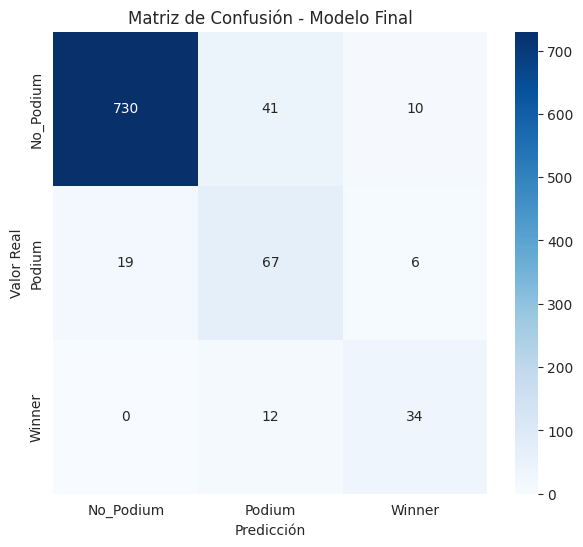

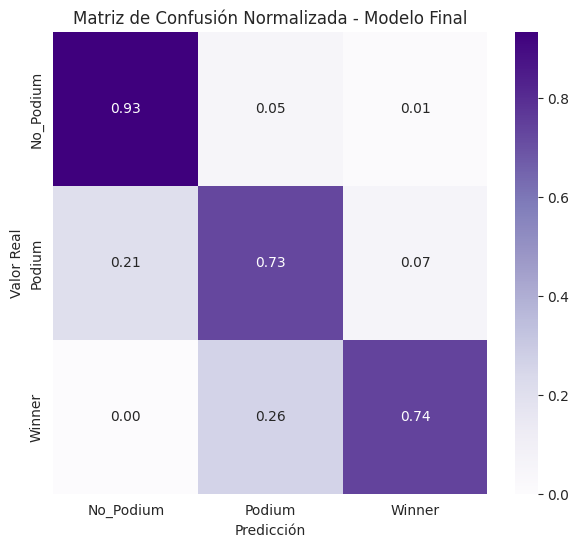

In [32]:
# Matriz de confusion sin normalizar
cm = confusion_matrix(y_test_enc, y_pred)
plt.figure(figsize=(7, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Matriz de Confusión - Modelo Final")
plt.xlabel("Predicción")
plt.ylabel("Valor Real")
plt.show()


# Matriz normalizada por fila
cm_norm = confusion_matrix(y_test_enc, y_pred, normalize='true')

plt.figure(figsize=(7, 6))
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Purples',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Matriz de Confusión Normalizada - Modelo Final")
plt.xlabel("Predicción")
plt.ylabel("Valor Real")
plt.show()

### Importancia de features

Dado que el mejor modelo resulta ser LightGBM, podemos analizar la importancia de las features en el proceso de decision

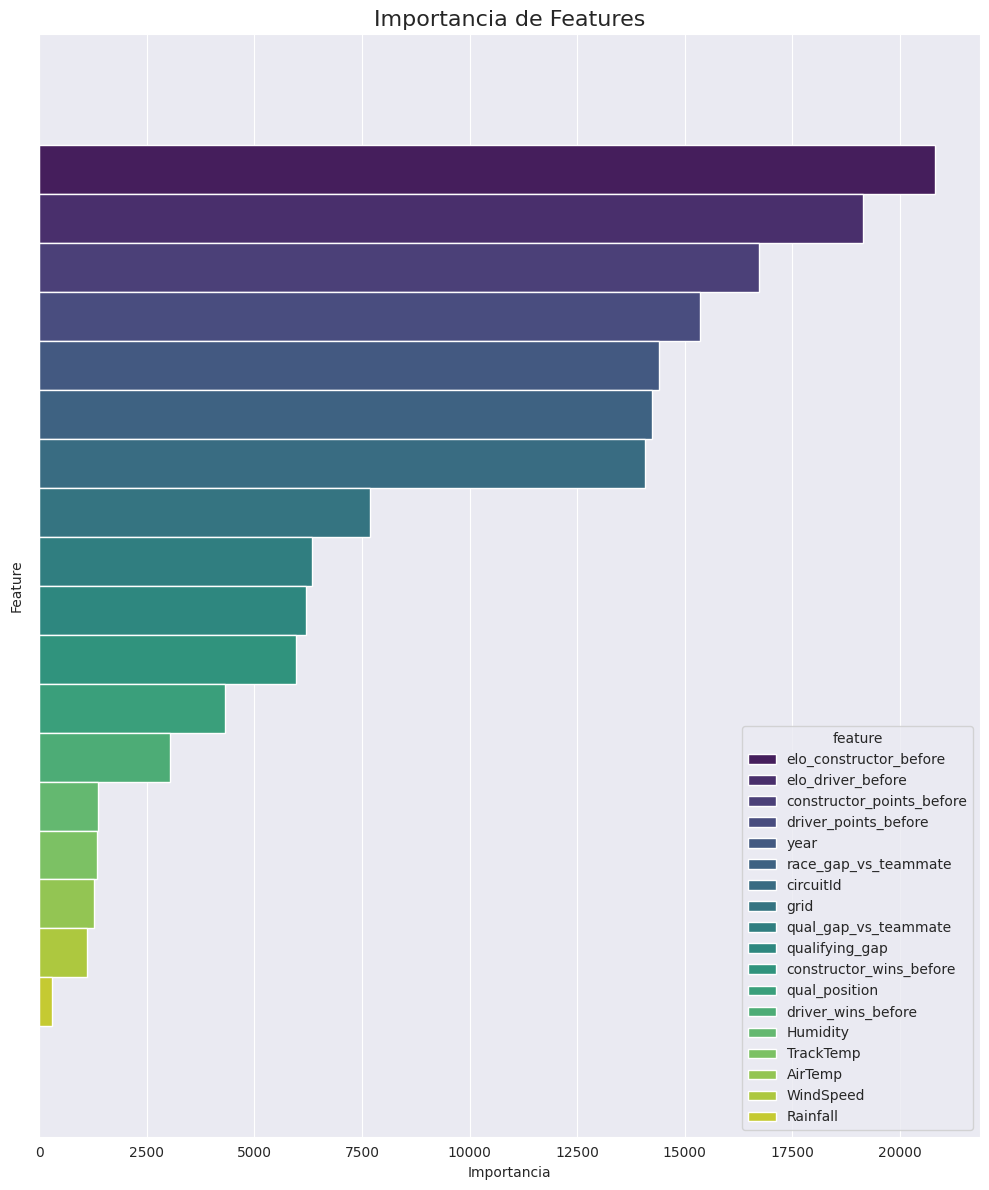

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Extraer importancias desde el modelo final (LightGBM)
importances = model.feature_importances_

# Crear DataFrame con nombres de columnas
feat_imp = pd.DataFrame({
    "feature": X_train.columns,
    "importance": importances
})

# Ordenar descendente
feat_imp = feat_imp.sort_values("importance", ascending=False)

# Graficar
plt.figure(figsize=(10, 12))
sns.barplot(
    data=feat_imp,
    x="importance",
    hue="feature",
    palette="viridis"
)
plt.title("Importancia de Features", fontsize=16)
plt.xlabel("Importancia")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

### Performance en test set por año

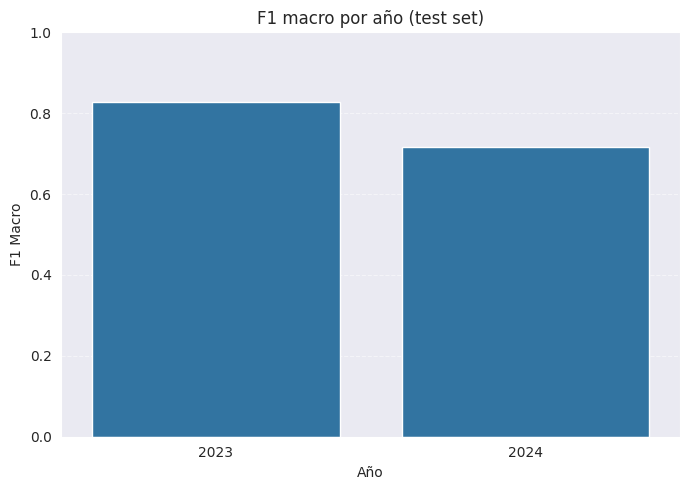

In [40]:
df_test_info = X_test.copy()
# Necesitamos columna 'year' en df/X_test. Si no está, intentar tomarla de df global
df_test_info['year'] = X_test['year']

df_test_info['pred'] = model.predict(X_test)
df_test_info['true'] = y_test_enc
years = sorted(df_test_info['year'].unique())
year_stats = []
for y in years:
    mask = df_test_info['year'] == y
    if mask.sum() < 5:
        continue
    f1y = f1_score(df_test_info.loc[mask,'true'], df_test_info.loc[mask,'pred'], average='macro')
    year_stats.append({"year": y, "f1_macro": f1y, "n": mask.sum()})
year_df = pd.DataFrame(year_stats)
year_df_filtered = year_df[year_df["year"].isin([2023, 2024])]

plt.figure(figsize=(7, 5))
sns.barplot(data=year_df_filtered, x="year", y="f1_macro")

plt.title("F1 macro por año (test set)")
plt.xlabel("Año")
plt.ylabel("F1 Macro")
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

### 👩‍⚕️Análisis de los resultados

Aquí se analizan los resultados, tanto en términos de la eficacia de los modelos como del conocimiento que aportan.

El modelo basado en LightGBM resultó ser el que mejor desempeño tuvo en la predicción de los resultados de las carreras de Fórmula 1, superando tanto al SVM como al Random Forest, y también al ensemble que combinaba los tres modelos. Esto sugiere que el enfoque de boosting utilizado por LightGBM es particularmente efectivo para capturar las complejidades y patrones presentes en los datos de carreras de F1. El Macro F1 = 0.76 es especialmente relevante, ya que penaliza el desequilibrio entre clases y refleja mejor la capacidad del modelo para predecir correctamente Podium y Winner, que eran las más difíciles.
El hecho de que el ensemble no haya superado al LightGBM individual puede deberse a que los otros modelos (SVM y Random Forest) no aportaban suficiente diversidad o información adicional para mejorar las predicciones del modelo base. En este caso, el LightGBM ya estaba capturando la mayoría de los patrones relevantes, y la combinación con modelos menos efectivos no añadió valor significativo.
Sorprendentemente, el modelo parece ser mejor para determinar ganadores que para predecir podios completos. Esto puede deberse a que las características que definen al ganador son más claras y consistentes (como el ELO del piloto y constructor, puntos previos, etc.), mientras que predecir el podio completo implica más variabilidad y factores externos que pueden influir en los resultados.

Viendo la matriz de confusión, se observa que el modelo tiene una alta tasa de aciertos para la clase "No_Podium", lo cual es esperado dado que es la clase mayoritaria. Sin embargo, también muestra una capacidad razonable para identificar correctamente a los "Winners" y "Podiums", aunque con algunas confusiones entre estas dos clases. Esto indica que, aunque el modelo es efectivo, todavía hay margen para mejorar en la distinción entre los pilotos que terminan en el podio y aquellos que ganan la carrera.

Observando la importancia de features que toma el modelo, se observa que el ELO y puntos previos a la carrera, tanto del conductor como el constructor son los factores más relevantes para la predicción del resultado de carreras futuras. El año también tiene un peso importante, lo que indica que los resultados más recientes tienen mayor relevancia para predecir los proximos resultados. También se puede observar que las condiciones climaticas tienen un peso menor, lo que indica que si bien afectan el rendimiento, no son tan determinantes como las habilidades y desempeño historico de pilotos y equipos.

El valor del F1 Score Macro es menor para el año 2024 en comparación con 2023. Esto evidencia la importancia de mantener el modelo actualizado con datos recientes, puesto que los patrones en los resultados de las carreras pueden cambiar con el tiempo debido a diversos factores como cambios en regulaciones, mejoras tecnológicas y variaciones en el rendimiento de pilotos y equipos. Esto subraya la necesidad de un proceso continuo de reentrenamiento y ajuste del modelo para asegurar su relevancia y precisión en predicciones futuras.

## 💾 Persistencia del modelo seleccionado

Guardamos el mejor modelo para usarlo luego en una nueva notebook.

In [42]:
joblib.dump(model, "f1_predictor_model.joblib")
print("Modelo guardado como f1_predictor_model.joblib")
joblib.dump(le, "label_encoder.joblib")
print("LabelEncoder guardado como label_encoder.joblib")

Modelo guardado como f1_predictor_model.joblib
LabelEncoder guardado como label_encoder.joblib


## 🛫 Cierre de la entrega: Reflexiones finales

El desarrollo de este modelo de predicción de resultados en Fórmula 1 permitió explorar los procesos de recopilación, preparación y modelado de datos en un caso de uso real. Los resultados obtenidos son más que buenos, considerando la complejidad del deporte y la cantidad de variables involucradas. El proceso de entrenamiento del modelo nos mostro las importancía del feature engineering: incorporar variables de desempeño historico y diferencias respecto al compañero de equipo resultó determinante para mejorar la capacidad predictiva de los modelos, mejorando significativamente los resultados obtenidos respecto a lo que conseguiamos usando los datos "crudos" de nuestro dataset.

El proceso también destacó la importancia de una correcta metodología de evaluación. Dado que los datos representan eventos en el tiempo, fue fundamental utilizar validación temporal en lugar de k-fold tradicional, evitando leakage y obteniendo una estimación realista del rendimiento futuro del modelo. También, durante el desarrollo, se obtuvo un caso en donde los resultados obtenidos eran sospechosamente buenos, lo que nos llevó a analizar y luego comprender la importancia de evitar el data leakage en las features.

La optimización de hiperparametros resulto ser una herramienta poderosa para mejorar el rendimiento de los modelos, permitiendo aumentar significativamente la capacidad predictiva de los mismos
También, durante el proyecto y la cursada de la materia, aprendimos sobre las distintas metricas que existen para medir las capacidades de un modelo de clasificación, y los distintos casos en donde puede aplicarse cada una.

En nuestra entrega de la primera parte del proyecto, colocamos como KPIs de éxito a la precisión y al recall, basandonos en nuestro limitado conocimiento de materias anteriores. Si bien estas metricas fueron mayormente alcanzadas, también aprendimos que en el caso específico de nuestro proyecto, la metrica de F1 Score es un mejor indicador del rendimiento del modelo, ya que toma en cuenta tanto precision como recall, y nos permite balancear ambos aspectos en un solo valor. La metrica de precisión de ganadores puede subirse "artificialmente" si el modelo predice muy pocas veces que un piloto va a ganar, lo que no es realmente util para un modelo predictivo. El recall, por otro lado, mide la capacidad del modelo para detectar todos los casos verdaderos, lo que tampoco es ideal si nuestro modelo predice que un piloto va a ganar demasiadas veces y se ignoran los falsos positivos. El F1 Score, al combinar tanto recall como precision, nos da una visión más equilibrada del rendimiento del modelo para nuestro caso, y refleja mejor el rendimiento real del modelo en las clases minoritarias (Winner y Podium).

Predecir resultados de Fórmula 1 es un desafío inherentemente complejo: el deporte presenta alta variabilidad, múltiples factores externos, cambios reglamentarios y diferencias año a año que complican la modelización. Aun así, los resultados obtenidos muestran que, con buen diseño experimental, ingeniería de variables y modelos bien ajustados, es posible capturar patrones significativos y lograr predicciones sorprendentemente sólidas.

Como posibles proximos pasos, se podria ampliar el dataset y elaborar nuevas features que incorporen más información contextual, como por ejemplo estrategias de pit stop, datos específicos de autos o cambios climáticos en tiempo real. También, se podrían explorar modelos más avanzados, de mayor costo computacional, pero potencialmente mejor rendimiento. Adicionalmente, se podría implementar un sistema de actualización continua del modelo, que permita incorporar datos de nuevas carreras y ajustar las predicciones en tiempo real sin la necesidad de reentrenar desde cero.
Como una futura idea, se podria implementar una variante del sistema que permita tomar como entrada el conjunto de pilotos y constructores que participan en una carrera específica, y usando esa información predecir el resultado completo de esa carrera, aunque esto requeriría un enfoque diferente y una mayor cantidad de datos.
